In [1]:
import os, psutil
import gc

import numpy as np
import pandas as pd
import scipy as sci
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import sklearn
sklearn.set_config(transform_output="pandas")

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB 

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_validate,cross_val_score,train_test_split, KFold, GridSearchCV, LearningCurveDisplay, ValidationCurveDisplay
from sklearn.metrics import classification_report, accuracy_score, log_loss, roc_auc_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.metrics import fowlkes_mallows_score, homogeneity_completeness_v_measure, adjusted_mutual_info_score, normalized_mutual_info_score, adjusted_rand_score, rand_score
from sklearn import ensemble,metrics,model_selection,neighbors,preprocessing, svm, tree
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

import lightgbm as lgb
from lightgbm import LGBMClassifier

from statsmodels.graphics.mosaicplot import mosaic

from time import time
import warnings

import shap

from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
%%time
# taken from https://www.kaggle.com/ryanholbrook/getting-started-september-2021-tabular-playground

def cpu_stats():
    pid = os.getpid()
    py = psutil.Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return 'memory GB:' + str(np.round(memory_use, 2))

def score(X, y, model, cv, scoring = {"AUC_OVR_Weighted": "roc_auc_ovr_weighted","AUC_OVO_Weighted": "roc_auc_ovo_weighted", "Accuracy": "accuracy"}):
    scores = cross_validate(
        model, X, y, scoring=scoring, cv=cv, return_train_score=True
    )
    scores = pd.DataFrame(scores).T
    return scores.assign(
        mean = lambda x: x.mean(axis=1),
        std = lambda x: x.std(axis=1),
    )
print('Function built')

Function built
CPU times: total: 0 ns
Wall time: 0 ns


In [3]:
%%time

## from: https://www.kaggle.com/bextuychiev/how-to-work-w-million-row-datasets-like-a-pro
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

CPU times: total: 0 ns
Wall time: 0 ns


In [4]:
# Modified from HW 5 Q2 Part a.
def train_and_evaluate_classifier(name, clf, X_train, y_train, X_test, y_test, cv=5, debug=False, learning_curve=False, confusion=False, supress_outputs=True):
  print(name)
    
  t0 = time()
  # Fit your classifier on the training set
  ### START CODE ###
  clf.fit(X_train, y_train)
  ### END CODE ###
  if supress_outputs == False:
      print("training time", round(time()-t0, 3), "s")

  t0 = time()
  y_train_pred = clf.predict(X_train)
  y_test_pred = clf.predict(X_test)
  if supress_outputs == False:
      print("predict time", round(time()-t0, 3), "s")

  if supress_outputs == False:
    print("Confusion matrix: ")
  # Print the confusion matrix computed from the test set (1 line of code only)
  ### START CODE ###
  #print(confusion_matrix(y_test, y_pred))
  # ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train)
  if confusion == True:
      ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
      plt.show()
  ### END CODE ###


  ### START CODE ###
  y_train_pred_proba = clf.predict_proba(X_train)
  y_test_pred_proba = clf.predict_proba(X_test)
    
  if debug == True:
      print(y_test_pred_proba)

  train_acc_score = accuracy_score(y_train, y_train_pred)
  test_acc_score = accuracy_score(y_test, y_test_pred)

  train_auc_score_ovo = roc_auc_score(y_train, y_train_pred_proba, multi_class='ovo')  
  train_auc_score_ovr = roc_auc_score(y_train, y_train_pred_proba, multi_class='ovr')
    
  test_auc_score_ovo = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovo')  
  test_auc_score_ovr = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr')
  ### END CODE ###
    
  if supress_outputs == False:
      print("TRAIN - Accuracy: {}, AUC_ROC_OVO: {}, AUC_ROC_OVR: {}".format(train_acc_score, train_auc_score_ovo, train_auc_score_ovr))
      print("TEST - Accuracy: {}, AUC_ROC_OVO: {}, AUC_ROC_OVR: {}".format(test_acc_score, test_auc_score_ovo, test_auc_score_ovr))

  # Display Learning curve
  if learning_curve == True:
      LearningCurveDisplay.from_estimator(clf, X_train, y_train, scoring='accuracy')
  #RocCurveDisplay.from_estimator(clf, X_test, y_test)

  train_results = [train_acc_score, train_auc_score_ovo, train_auc_score_ovr]
  test_results = [test_acc_score, test_auc_score_ovo, test_auc_score_ovr]
  return train_results, test_results

In [5]:
# Modified from HW 5 Q2 Part a.
def train_and_evaluate_classifierCV(name, clf, X_train, y_train, X_test, y_test, cv=5, debug=False, learning_curve=False, confusion=False, supress_outputs=True):
  print(name)
    
  t0 = time()
  # Fit your classifier on the training set
  ### START CODE ###
  clf.fit(X_train, y_train)
  scores = cross_validate(clf, X_train, y_train, scoring=['accuracy', 'roc_auc_ovo_weighted', 'roc_auc_ovr_weighted'], cv=cv, return_estimator=True, return_train_score=True)
  ### END CODE ###
  if supress_outputs == False:
      print("CV time", round(time()-t0, 3), "s")

  estimators = scores['estimator']
  del scores['estimator']
  scores = pd.DataFrame(scores).T
  summary = scores.assign(
        mean = lambda x: x.mean(axis=1),
        std = lambda x: x.std(axis=1),
    )

  if supress_outputs == False:
      display(summary[['mean', 'std']])

  t0 = time()
  y_train_pred = clf.predict(X_train)
  y_test_pred = clf.predict(X_test)
  if supress_outputs == False:
      print("predict time", round(time()-t0, 3), "s")

  if supress_outputs == False:
    print("Confusion matrix: ")
  # Print the confusion matrix computed from the test set (1 line of code only)
  ### START CODE ###
  #print(confusion_matrix(y_test, y_pred))
  # ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train)
  if confusion == True:
      ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
      plt.show()
  ### END CODE ###


  ### START CODE ###
  y_train_pred_proba = clf.predict_proba(X_train)
  y_test_pred_proba = clf.predict_proba(X_test)
    
  if debug == True:
      print(y_test_pred_proba)

  train_acc_score = accuracy_score(y_train, y_train_pred)
  test_acc_score = accuracy_score(y_test, y_test_pred)

  train_auc_score_ovo = roc_auc_score(y_train, y_train_pred_proba, multi_class='ovo')  
  train_auc_score_ovr = roc_auc_score(y_train, y_train_pred_proba, multi_class='ovr')
    
  test_auc_score_ovo = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovo')  
  test_auc_score_ovr = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr')
  ### END CODE ###
    
  if supress_outputs == False:
      print("TRAIN - Accuracy: {}, AUC_ROC_OVO: {}, AUC_ROC_OVR: {}".format(train_acc_score, train_auc_score_ovo, train_auc_score_ovr))
      print("TEST - Accuracy: {}, AUC_ROC_OVO: {}, AUC_ROC_OVR: {}".format(test_acc_score, test_auc_score_ovo, test_auc_score_ovr))

  # Display Learning curve
  if learning_curve == True:
      LearningCurveDisplay.from_estimator(clf, X_train, y_train, scoring='accuracy')
  #RocCurveDisplay.from_estimator(clf, X_test, y_test)

  train_results = [train_acc_score, train_auc_score_ovo, train_auc_score_ovr]
  test_results = [test_acc_score, test_auc_score_ovo, test_auc_score_ovr]
  return train_results, test_results, summary

In [6]:
df1 = pd.read_csv('dataset/ObesityDataSet.csv')

df2 = pd.read_csv('dataset/train.csv')
df2 = df2.drop(columns='id')

df = pd.concat([df1, df2], ignore_index=True)
df

Gender        Age    Height      Weight family_history_with_overweight  \
0      Female  21.000000  1.620000   64.000000                            yes   
1      Female  21.000000  1.520000   56.000000                            yes   
2        Male  23.000000  1.800000   77.000000                            yes   
3        Male  27.000000  1.800000   87.000000                             no   
4        Male  22.000000  1.780000   89.800000                             no   
...       ...        ...       ...         ...                            ...   
22864    Male  25.137087  1.766626  114.187096                            yes   
22865    Male  18.000000  1.710000   50.000000                             no   
22866    Male  20.101026  1.819557  105.580491                            yes   
22867    Male  33.852953  1.700000   83.520113                            yes   
22868    Male  26.680376  1.816547  118.134898                            yes   

      FAVC      FCVC       NCP        CAEC SMOKE      CH2O  SCC       FAF  \
0       no  2.000000  3.000000   Sometimes    no  2.000000   no  0.000000   
1       no  3.000000  3.000000   Sometimes   yes  3.000000  yes  3.000000   
2       no  2.000000  3.000000   Sometimes    no  2.000000   no  2.000000   
3       no  3.000000  3.000000   Sometimes    no  2.000000   no  2.000000   
4       no  2.000000  1.000000   Sometimes    no  2.000000   no  0.000000   
...    ...       ...       ...         ...   ...       ...  ...       ...   
22864  yes  2.919584  3.000000   Sometimes    no  2.151809   no  1.330519   
22865  yes  3.000000  4.000000  Frequently    no  1.000000   no  2.000000   
22866  yes  2.407817  3.000000   Sometimes    no  2.000000   no  1.158040   
22867  yes  2.671238  1.971472   Sometimes    no  2.144838   no  0.000000   
22868  yes  3.000000  3.000000   Sometimes    no  2.003563   no  0.684487   

            TUE        CALC                 MTRANS           NObeyesdad  
0      1.000000          no  Public_Transportation        Normal_Weight  
1      0.000000   Sometimes  Public_Transportation        Normal_Weight  
2      1.000000  Frequently  Public_Transportation        Normal_Weight  
3      0.000000  Frequently                Walking   Overweight_Level_I  
4      0.000000   Sometimes  Public_Transportation  Overweight_Level_II  
...         ...         ...                    ...                  ...  
22864  0.196680   Sometimes  Public_Transportation      Obesity_Type_II  
22865  1.000000   Sometimes  Public_Transportation  Insufficient_Weight  
22866  1.198439          no  Public_Transportation      Obesity_Type_II  
22867  0.973834          no             Automobile  Overweight_Level_II  
22868  0.713823   Sometimes  Public_Transportation      Obesity_Type_II  

[22869 rows x 17 columns]

In [7]:
df['BMI'] = df['Weight'] / (df['Height'] ** 2)
# df['BMI'].hist()
# df['BMI'].describe()

In [8]:
WHObmi_boys = pd.read_csv("dataset/bmi_boys_perc_WHO2007.csv")
WHObmi_girls = pd.read_csv("dataset/bmi_girls_perc_WHO2007.csv")

CDCbmi_boys = pd.read_csv("dataset/bmiagerev_boys.csv")
CDCbmi_girls = pd.read_csv("dataset/bmiagerv_girls.csv")

In [9]:
WHObmi_boys.insert(0, "Age", WHObmi_boys['Month']/12)
WHObmi_boys = WHObmi_boys[WHObmi_boys['Age'] >= 14]

WHObmi_girls.insert(0, "Age", WHObmi_girls['Month']/12)
WHObmi_girls = WHObmi_girls[WHObmi_girls['Age'] >= 14]

CDCbmi_boys.insert(0, "Age", CDCbmi_boys['Agemos']/12)
CDCbmi_boys = CDCbmi_boys[CDCbmi_boys['Age'] >= 14]

CDCbmi_girls.insert(0, "Age", CDCbmi_girls['Agemos']/12)
CDCbmi_girls = CDCbmi_girls[CDCbmi_girls['Age'] >= 14]

In [10]:
df['Adult'] = np.select([df['Age'] >= 20, df['Age'] < 20], ["True", "False"]) 

# from https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/
# create a list of our conditions
conditions = [
    (df['Adult'] == "False"),
    (df['Adult'] == "True") & (df['BMI'] < 18.5),
    (df['Adult'] == "True") & (df['BMI'] >= 18.5) & (df['BMI'] < 25),
    (df['Adult'] == "True") & (df['BMI'] >= 25) & (df['BMI'] < 30),
    (df['Adult'] == "True") & (df['BMI'] >= 30) & (df['BMI'] < 35),
    (df['Adult'] == "True") & (df['BMI'] >= 35) & (df['BMI'] < 40),
    (df['Adult'] == "True") & (df['BMI'] >= 40)
    ]

# create a list of the values we want to assign for each condition
values = ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3']

# create a new column and use np.select to assign values to it using our lists as arguments
df['Adult BMI Predictions'] = np.select(conditions, values)

In [11]:
WHOBMI_pred = []
CDCBMI_pred = []
df_temp = df[df['Adult'] == "False"]
df_needed = df_temp[['Gender', 'Age', 'BMI']]
for index, row in df_needed.iterrows():
    if row['Gender'] == "Male":
        WHO_entry = WHObmi_boys.loc[(WHObmi_boys.Age - row['Age']).abs().idxmin()]
        CDC_entry = CDCbmi_boys.loc[(CDCbmi_boys.Age - row['Age']).abs().idxmin()]

        for (pred, entry) in [(WHOBMI_pred, WHO_entry), (CDCBMI_pred, CDC_entry)]:
            if row['BMI'] < entry['P5']:
                pred.append('underweight')
            elif row['BMI'] >= entry['P5'] and row['BMI'] < entry['P85']:
                pred.append('healthy')
            elif row['BMI'] >= entry['P85'] and row['BMI'] < entry['P95']:
                pred.append('overweight')
            elif row['BMI'] >= entry['P95'] and row['BMI'] < (1.25 * entry['P95']):
                pred.append('obseity class 1')
            elif row['BMI'] >= (1.25 * entry['P95']) and row['BMI'] < (1.4 * entry['P95']):
                pred.append('obseity class 2')
            else:
                pred.append('obseity class 3')

    elif row['Gender'] == "Female":
        WHO_entry = WHObmi_girls.loc[(WHObmi_girls.Age - row['Age']).abs().idxmin()]
        CDC_entry = CDCbmi_girls.loc[(CDCbmi_girls.Age - row['Age']).abs().idxmin()]

        for (pred, entry) in [(WHOBMI_pred, WHO_entry), (CDCBMI_pred, CDC_entry)]:
            if row['BMI'] < entry['P5']:
                pred.append('underweight')
            elif row['BMI'] >= entry['P5'] and row['BMI'] < entry['P85']:
                pred.append('healthy')
            elif row['BMI'] >= entry['P85'] and row['BMI'] < entry['P95']:
                pred.append('overweight')
            elif row['BMI'] >= entry['P95'] and row['BMI'] < (1.25 * entry['P95']):
                pred.append('obseity class 1')
            elif row['BMI'] >= (1.25 * entry['P95']) and row['BMI'] < (1.4 * entry['P95']):
                pred.append('obseity class 2')
            else:
                pred.append('obseity class 3')
        
# df_temp['WHO BMI Predictions'] = WHOBMI_pred
# df_temp['CDC BMI Predicitons'] = CDCBMI_pred
# df_temp

In [12]:
df['WHO BMI Predictions'] = 'N/A'
df['CDC BMI Predictions'] = 'N/A'

df.loc[df['Adult'] == 'False', 'WHO BMI Predictions'] = WHOBMI_pred
df.loc[df['Adult'] == 'False', 'CDC BMI Predictions'] = CDCBMI_pred
# df

In [13]:
df_lean = reduce_memory_usage(df.copy(), verbose=True)
# test = reduce_memory_usage(test, verbose=True)
print(cpu_stats())
print('Memory reduced')

Mem. usage decreased to 2.66 Mb (30.7% reduction)
memory GB:0.24
Memory reduced


features obtained


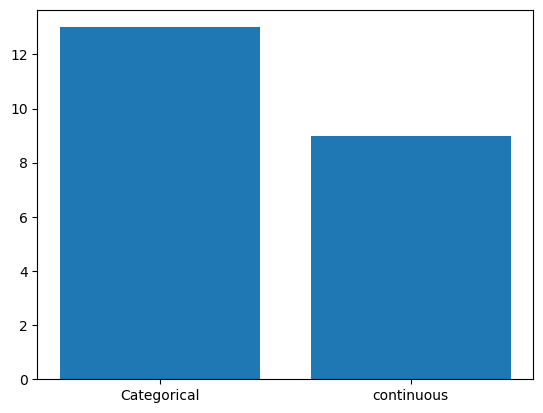

CPU times: total: 109 ms
Wall time: 100 ms


In [14]:
%%time
features=[]
cat_features=[]
cont_features=[]
for feature in df_lean.columns:
    features.append(feature)
    if df_lean.dtypes[feature] in ['int8', 'object', 'bool']:
        cat_features.append(feature)
    if df_lean.dtypes[feature]=='float16':
        cont_features.append(feature)
    #print(test.dtypes[feature])
print('features obtained')

plt.bar([1,2],[len(cat_features),len(cont_features)])
plt.xticks([1,2],('Categorical','continuous'))
plt.show()

In [15]:
y = df['NObeyesdad']
X = df.drop(columns='NObeyesdad')

y_lean = df_lean['NObeyesdad']
X_lean = df_lean.drop(columns='NObeyesdad')

In [16]:
cat_features.remove('NObeyesdad')
cat_features

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS',
 'Adult',
 'Adult BMI Predictions',
 'WHO BMI Predictions',
 'CDC BMI Predictions']

In [17]:
nominal_features = [cat_features[i] for i in [0, 1, 2, 4, 5, 7, 9]]
print(nominal_features)

ordinal_features = [cat_features[i] for i in [3, 6, 9, 10, 11]]
print(ordinal_features)

['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS', 'Adult BMI Predictions']
['CAEC', 'CALC', 'Adult BMI Predictions', 'WHO BMI Predictions', 'CDC BMI Predictions']


In [18]:
cont_features

['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI']

In [19]:
cat_features

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS',
 'Adult',
 'Adult BMI Predictions',
 'WHO BMI Predictions',
 'CDC BMI Predictions']

In [20]:
ordinal_features

['CAEC',
 'CALC',
 'Adult BMI Predictions',
 'WHO BMI Predictions',
 'CDC BMI Predictions']

In [21]:
nominal_features

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'SMOKE',
 'SCC',
 'MTRANS',
 'Adult BMI Predictions']

In [22]:
for cat_feat in cat_features:
    print(X[cat_feat].unique())

['Female' 'Male']
['yes' 'no']
['no' 'yes']
['Sometimes' 'Frequently' 'Always' 'no']
['no' 'yes']
['no' 'yes']
['no' 'Sometimes' 'Frequently' 'Always']
['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
['True' 'False']
['healthy' 'overweight' 'obseity class 1' 'N/A' 'underweight'
 'obseity class 2' 'obseity class 3']
['N/A' 'healthy' 'overweight' 'obseity class 1' 'underweight'
 'obseity class 3' 'obseity class 2']
['N/A' 'healthy' 'underweight' 'obseity class 1' 'overweight'
 'obseity class 3' 'obseity class 2']


In [23]:
# Manual encoding
manual_enc = ColumnTransformer(
    [
        ('numerical', 'passthrough', cont_features),
        ('ordinal', OrdinalEncoder(categories=[
            ['no', 'Sometimes', 'Frequently', 'Always'],
            ['no', 'Sometimes', 'Frequently', 'Always'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3']
        ]), ordinal_features),
        ('nominal', OneHotEncoder(sparse_output=False), nominal_features)
    ], verbose_feature_names_out=False
)

In [24]:
# Manual encoding
col_enc1 = ColumnTransformer(
    [
        ('numerical', 'passthrough', cont_features),
        ('ordinal', OrdinalEncoder(categories=[
            ['no', 'Sometimes', 'Frequently', 'Always'],
            ['no', 'Sometimes', 'Frequently', 'Always'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3']
        ]), ordinal_features),
        ('nominal', OneHotEncoder(sparse_output=False), nominal_features)
    ], verbose_feature_names_out=False
)

In [25]:
col_enc2 = ColumnTransformer(
    [
        ('numerIteract', Pipeline(
            [
                ('interact', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
                ('scale', StandardScaler())
            ]), slice(0, 9)),
        ('catInteract', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False), slice(14, 31))
    ], verbose_feature_names_out=False
)

manual_enc2 = Pipeline([('Categorical Preprocessing', col_enc1), ('Interaction Terms', col_enc2)])

In [26]:
ordinalCT = OrdinalEncoder()

ordinalCatOnlyCT = ColumnTransformer(
        [
            ("numerical", "passthrough", cont_features),
            ("categorical", OrdinalEncoder(), cat_features),
        ], verbose_feature_names_out=False
    )

ordinalCatStandardCT = ColumnTransformer(
        [
            ("numerical", StandardScaler(), cont_features),
            ("categorical", OrdinalEncoder(), cat_features),
        ], verbose_feature_names_out=False
    )

ordinalCatRobustCT = ColumnTransformer(
        [
            ("numerical", RobustScaler(), cont_features),
            ("categorical", OrdinalEncoder(), cat_features),
        ], verbose_feature_names_out=False
    )

# Removed due to memory issues
# oneHotCT = OneHotEncoder() 


oneHotCatOnlyCT = ColumnTransformer(
        [
            ("numerical", "passthrough", cont_features),
            ("categorical", OneHotEncoder(drop='if_binary', sparse_output=False), cat_features),
        ], verbose_feature_names_out=False
    )

oneHotCatStandardCT = ColumnTransformer(
        [
            ("numerical", StandardScaler(), cont_features),
            ("categorical", OneHotEncoder(drop='if_binary', sparse_output=False), cat_features),
        ], verbose_feature_names_out=False
    )

oneHotCatRobustCT = ColumnTransformer(
        [
            ("numerical", RobustScaler(), cont_features),
            ("categorical", OneHotEncoder(drop='if_binary', sparse_output=False), cat_features),
        ], verbose_feature_names_out=False
    )

CTs = [ordinalCT, ordinalCatOnlyCT, ordinalCatStandardCT, ordinalCatRobustCT, 
       # oneHotCT, 
       oneHotCatOnlyCT, oneHotCatStandardCT, oneHotCatRobustCT, manual_enc, manual_enc2]
preprocessed = ["(Ordinal)", "(Ordinal Categorical Only - No Scaling)", "(Ordinal Categorical Only - Standard Scaler)", "(Ordinal Categorical Only - Robust Scaler)",
                # "(One Hot)", 
                "(One Hot Categorical Only - No Scaling)", "(One Hot Categorical Only - Standard Scaler)", "(One Hot Categorical Only - Robust Scaler)",
               'Manual Encoding 1', 'Manual Encoding 2']

if len(CTs) != len(preprocessed):
    print("NUMBER OF TRANSFORMERS != NUMBER OF PREPROCESSED DATASETS") 

In [27]:
X.flags

<Flags(allows_duplicate_labels=True)>

In [28]:
X[X['Adult'] == 'False']

Gender        Age    Height     Weight family_history_with_overweight  \
28       Male  19.000000  1.750000  76.000000                            yes   
58     Female  17.000000  1.650000  67.000000                            yes   
73       Male  19.000000  1.850000  65.000000                            yes   
80     Female  19.000000  1.630000  58.000000                             no   
83     Female  19.000000  1.600000  45.000000                             no   
...       ...        ...       ...        ...                            ...   
22854  Female  19.000000  1.740000  78.000000                            yes   
22856  Female  19.979810  1.742901  49.932199                             no   
22857  Female  18.000000  1.610000  64.000000                            yes   
22861    Male  18.827008  1.753321  80.000000                            yes   
22865    Male  18.000000  1.710000  50.000000                             no   

      FAVC      FCVC       NCP        CAEC SMOKE  ...  SCC       FAF  \
28     yes  3.000000  3.000000   Sometimes    no  ...  yes  3.000000   
58     yes  3.000000  1.000000   Sometimes    no  ...   no  1.000000   
73      no  2.000000  3.000000   Sometimes    no  ...   no  2.000000   
80      no  3.000000  3.000000   Sometimes    no  ...  yes  0.000000   
83      no  3.000000  3.000000          no    no  ...  yes  2.000000   
...    ...       ...       ...         ...   ...  ...  ...       ...   
22854  yes  3.000000  1.000000   Sometimes    no  ...   no  1.000000   
22856  yes  2.969233  3.489918  Frequently    no  ...   no  2.000000   
22857  yes  3.000000  3.000000   Sometimes    no  ...   no  1.000000   
22861  yes  2.826251  2.256119   Sometimes    no  ...   no  0.753782   
22865  yes  3.000000  4.000000  Frequently    no  ...   no  2.000000   

            TUE       CALC                 MTRANS        BMI  Adult  \
28     1.000000  Sometimes  Public_Transportation  24.816327  False   
58     1.000000         no                Walking  24.609734  False   
73     1.000000  Sometimes                   Bike  18.991965  False   
80     0.000000         no  Public_Transportation  21.829952  False   
83     0.000000         no                Walking  17.578125  False   
...         ...        ...                    ...        ...    ...   
22854  0.000000  Sometimes  Public_Transportation  25.762981  False   
22856  1.000000  Sometimes  Public_Transportation  16.437481  False   
22857  1.000000  Sometimes  Public_Transportation  24.690405  False   
22861  0.051858         no  Public_Transportation  26.023585  False   
22865  1.000000  Sometimes  Public_Transportation  17.099278  False   

      Adult BMI Predictions WHO BMI Predictions CDC BMI Predictions  
28                      N/A             healthy             healthy  
58                      N/A             healthy             healthy  
73                      N/A             healthy             healthy  
80                      N/A             healthy             healthy  
83                      N/A             healthy         underweight  
...                     ...                 ...                 ...  
22854                   N/A          overweight             healthy  
22856                   N/A         underweight         underweight  
22857                   N/A             healthy             healthy  
22861                   N/A          overweight             healthy  
22865                   N/A         underweight         underweight  

[5677 rows x 21 columns]

In [29]:
# TEST WITH DIFFERENT ENCODERS: ORDINAL, ONE-HOT, TARGET
lean = True
if lean == True:
    X_split = X_lean
    y_split = y_lean
else:
    X_split = X
    y_split = y

X_s = []
for i, CT in enumerate(CTs):
    # print(i)
    X_s.append(CT.fit_transform(X_split.copy(), y_split))

X_train = [None] * len(X_s)
X_test = [None] * len(X_s)
y_train = [None] * len(X_s)
y_test = [None] * len(X_s)

for i, X in enumerate(X_s):
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X, y_split, test_size=1/4, random_state=42)


In [30]:
# pipes[1]['columntransformer'].get_params()['categorical'].categories_

In [31]:
X

Age    Height    Weight      FCVC       NCP      CH2O       FAF  \
0     -0.501465 -0.913086 -0.901367 -0.831543  0.344727 -0.045074 -1.172852   
1     -0.501465 -2.056641 -1.205078  1.043945  0.344727  1.597656  2.400391   
2     -0.153809  1.131836 -0.408447 -0.831543  0.344727 -0.045074  1.209961   
3      0.541504  1.131836 -0.029114  1.043945  0.344727 -0.045074  1.209961   
4     -0.327637  0.909180  0.077576 -0.831543 -2.460938 -0.045074 -1.172852   
...         ...       ...       ...       ...       ...       ...       ...   
22864  0.218262  0.753418  1.001953  0.893555  0.344727  0.205078  0.411865   
22865 -1.023438  0.109009 -1.433594  1.043945  1.748047 -1.687500  1.209961   
22866 -0.658691  1.353516  0.675293 -0.066040  0.344727 -0.045074  0.207031   
22867  1.731445 -0.002079 -0.161743  0.428223 -1.098633  0.192261 -1.172852   
22868  0.487061  1.320312  1.151367  1.043945  0.344727 -0.038666 -0.357178   

            TUE       BMI  Age Height  ...  \
0      0.629395 -0.698242   -0.662598  ...   
1     -1.029297 -0.717285   -0.877441  ...   
2      0.629395 -0.773438    0.080505  ...   
3     -1.029297 -0.401123    0.805176  ...   
4     -1.029297 -0.222412   -0.146240  ...   
...         ...       ...         ...  ...   
22864 -0.703125  0.770996    0.383057  ...   
22865  0.629395 -1.577148   -0.990723  ...   
22866  0.958008  0.204590   -0.407471  ...   
22867  0.585449 -0.154785    1.706055  ...   
22868  0.154785  0.676758    0.792480  ...   

       MTRANS_Motorbike MTRANS_Public_Transportation  \
0                                                0.0   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   
...                                              ...   
22864                                            0.0   
22865                                            0.0   
22866                                            0.0   
22867                                            0.0   
22868                                            0.0   

       MTRANS_Motorbike MTRANS_Walking  \
0                                  0.0   
1                                  0.0   
2                                  0.0   
3                                  0.0   
4                                  0.0   
...                                ...   
22864                              0.0   
22865                              0.0   
22866                              0.0   
22867                              0.0   
22868                              0.0   

       MTRANS_Motorbike Adult BMI Predictions_N/A  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             0.0   
4                                             0.0   
...                                           ...   
22864                                         0.0   
22865                                         0.0   
22866                                         0.0   
22867                                         0.0   
22868                                         0.0   

       MTRANS_Motorbike Adult BMI Predictions_healthy  \
0                                                 0.0   
1                                                 0.0   
2                                                 0.0   
3                                                 0.0   
4                                                 0.0   
...                                               ...   
22864                                             0.0   
22865                                             0.0   
22866                                             0.0   
22867                                             0.0   
22868                                             0.0   

       MTR

In [32]:
preprocessed

['(Ordinal)',
 '(Ordinal Categorical Only - No Scaling)',
 '(Ordinal Categorical Only - Standard Scaler)',
 '(Ordinal Categorical Only - Robust Scaler)',
 '(One Hot Categorical Only - No Scaling)',
 '(One Hot Categorical Only - Standard Scaler)',
 '(One Hot Categorical Only - Robust Scaler)',
 'Manual Encoding 1',
 'Manual Encoding 2']

In [33]:
X_s[8]

Age    Height    Weight      FCVC       NCP      CH2O       FAF  \
0     -0.501465 -0.913086 -0.901367 -0.831543  0.344727 -0.045074 -1.172852   
1     -0.501465 -2.056641 -1.205078  1.043945  0.344727  1.597656  2.400391   
2     -0.153809  1.131836 -0.408447 -0.831543  0.344727 -0.045074  1.209961   
3      0.541504  1.131836 -0.029114  1.043945  0.344727 -0.045074  1.209961   
4     -0.327637  0.909180  0.077576 -0.831543 -2.460938 -0.045074 -1.172852   
...         ...       ...       ...       ...       ...       ...       ...   
22864  0.218262  0.753418  1.001953  0.893555  0.344727  0.205078  0.411865   
22865 -1.023438  0.109009 -1.433594  1.043945  1.748047 -1.687500  1.209961   
22866 -0.658691  1.353516  0.675293 -0.066040  0.344727 -0.045074  0.207031   
22867  1.731445 -0.002079 -0.161743  0.428223 -1.098633  0.192261 -1.172852   
22868  0.487061  1.320312  1.151367  1.043945  0.344727 -0.038666 -0.357178   

            TUE       BMI  Age Height  ...  \
0      0.629395 -0.698242   -0.662598  ...   
1     -1.029297 -0.717285   -0.877441  ...   
2      0.629395 -0.773438    0.080505  ...   
3     -1.029297 -0.401123    0.805176  ...   
4     -1.029297 -0.222412   -0.146240  ...   
...         ...       ...         ...  ...   
22864 -0.703125  0.770996    0.383057  ...   
22865  0.629395 -1.577148   -0.990723  ...   
22866  0.958008  0.204590   -0.407471  ...   
22867  0.585449 -0.154785    1.706055  ...   
22868  0.154785  0.676758    0.792480  ...   

       MTRANS_Motorbike MTRANS_Public_Transportation  \
0                                                0.0   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   
...                                              ...   
22864                                            0.0   
22865                                            0.0   
22866                                            0.0   
22867                                            0.0   
22868                                            0.0   

       MTRANS_Motorbike MTRANS_Walking  \
0                                  0.0   
1                                  0.0   
2                                  0.0   
3                                  0.0   
4                                  0.0   
...                                ...   
22864                              0.0   
22865                              0.0   
22866                              0.0   
22867                              0.0   
22868                              0.0   

       MTRANS_Motorbike Adult BMI Predictions_N/A  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             0.0   
4                                             0.0   
...                                           ...   
22864                                         0.0   
22865                                         0.0   
22866                                         0.0   
22867                                         0.0   
22868                                         0.0   

       MTRANS_Motorbike Adult BMI Predictions_healthy  \
0                                                 0.0   
1                                                 0.0   
2                                                 0.0   
3                                                 0.0   
4                                                 0.0   
...                                               ...   
22864                                             0.0   
22865                                             0.0   
22866                                             0.0   
22867                                             0.0   
22868                                             0.0   

       MTR

Decision Tree (Ordinal)
CV time 1.608 s


mean           std
fit_time                    0.151327  2.278258e-03
score_time                  0.040244  9.004600e-04
test_accuracy               0.848755  4.188438e-03
train_accuracy              0.999898  5.830426e-05
test_roc_auc_ovo_weighted   0.907637  2.621541e-03
train_roc_auc_ovo_weighted  1.000000  9.257741e-09
test_roc_auc_ovr_weighted   0.912814  2.408539e-03
train_roc_auc_ovr_weighted  1.000000  7.639538e-09

predict time 0.007 s
Confusion matrix: 


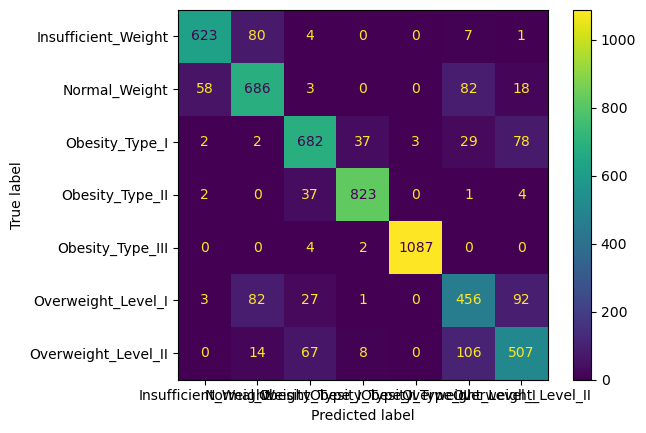

TRAIN - Accuracy: 0.9998833887236895, AUC_ROC_OVO: 0.999999983416084, AUC_ROC_OVR: 0.9999999862646322
TEST - Accuracy: 0.850647079398391, AUC_ROC_OVO: 0.9047607378249173, AUC_ROC_OVR: 0.9060864102017847

Decision Tree (Ordinal Categorical Only - No Scaling)
CV time 1.629 s


mean           std
fit_time                    0.151755  3.170618e-03
score_time                  0.041260  1.145779e-03
test_accuracy               0.850329  3.167604e-03
train_accuracy              0.999898  5.830426e-05
test_roc_auc_ovo_weighted   0.908650  2.038191e-03
train_roc_auc_ovo_weighted  1.000000  9.257741e-09
test_roc_auc_ovr_weighted   0.913753  1.876256e-03
train_roc_auc_ovr_weighted  1.000000  7.639538e-09

predict time 0.008 s
Confusion matrix: 


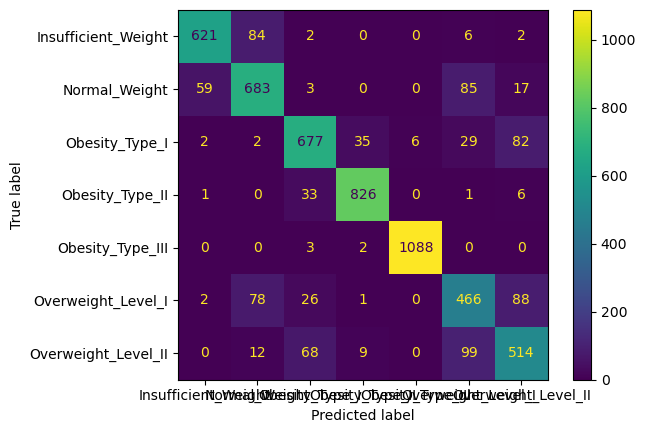

TRAIN - Accuracy: 0.9998833887236895, AUC_ROC_OVO: 0.999999983416084, AUC_ROC_OVR: 0.9999999862646322
TEST - Accuracy: 0.8525708289611752, AUC_ROC_OVO: 0.9061887816978578, AUC_ROC_OVR: 0.9074669145724837

Decision Tree (Ordinal Categorical Only - Standard Scaler)
CV time 1.616 s


mean           std
fit_time                    0.151047  2.115171e-03
score_time                  0.041510  5.272743e-04
test_accuracy               0.850913  3.514878e-03
train_accuracy              0.999898  5.830426e-05
test_roc_auc_ovo_weighted   0.908944  2.138561e-03
train_roc_auc_ovo_weighted  1.000000  9.257741e-09
test_roc_auc_ovr_weighted   0.914081  2.013413e-03
train_roc_auc_ovr_weighted  1.000000  7.639538e-09

predict time 0.009 s
Confusion matrix: 


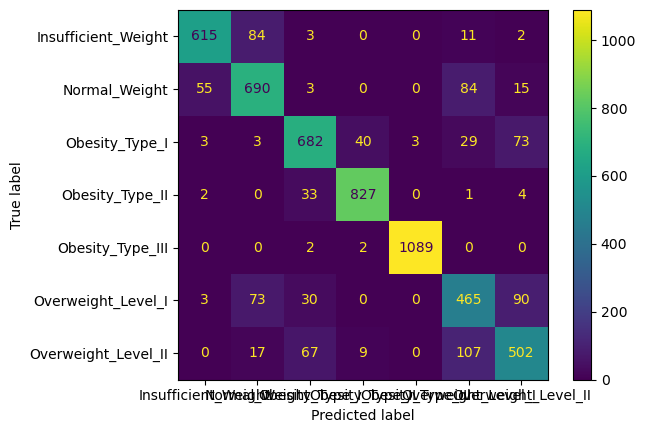

TRAIN - Accuracy: 0.9998833887236895, AUC_ROC_OVO: 0.999999983416084, AUC_ROC_OVR: 0.9999999862646322
TEST - Accuracy: 0.8516963973417279, AUC_ROC_OVO: 0.9053003583342525, AUC_ROC_OVR: 0.9066357780264875

Decision Tree (Ordinal Categorical Only - Robust Scaler)
CV time 1.625 s


mean           std
fit_time                    0.151365  2.192034e-03
score_time                  0.041069  1.096643e-03
test_accuracy               0.850854  7.093288e-03
train_accuracy              0.999898  5.830426e-05
test_roc_auc_ovo_weighted   0.908940  4.401546e-03
train_roc_auc_ovo_weighted  1.000000  9.257741e-09
test_roc_auc_ovr_weighted   0.914020  4.090137e-03
train_roc_auc_ovr_weighted  1.000000  7.639538e-09

predict time 0.008 s
Confusion matrix: 


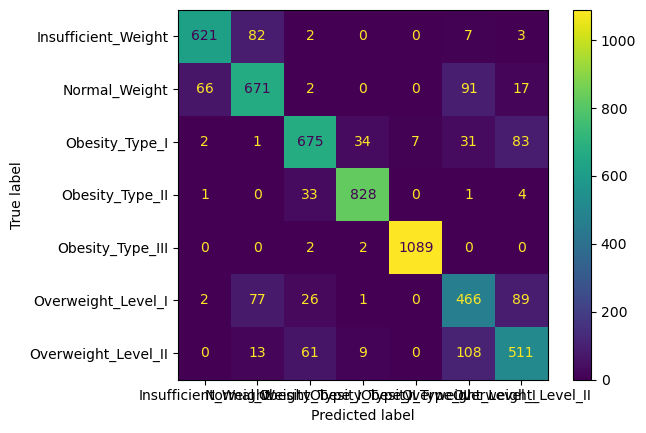

TRAIN - Accuracy: 0.9998833887236895, AUC_ROC_OVO: 0.999999983416084, AUC_ROC_OVR: 0.9999999862646322
TEST - Accuracy: 0.8501224204267226, AUC_ROC_OVO: 0.9047203846665057, AUC_ROC_OVR: 0.9060147406635038

Decision Tree (One Hot Categorical Only - No Scaling)
CV time 1.809 s


mean           std
fit_time                    0.175525  5.027763e-03
score_time                  0.043491  6.434287e-04
test_accuracy               0.848114  2.375206e-03
train_accuracy              0.999898  5.830426e-05
test_roc_auc_ovo_weighted   0.907310  1.497149e-03
train_roc_auc_ovo_weighted  1.000000  9.257741e-09
test_roc_auc_ovr_weighted   0.912489  1.353920e-03
train_roc_auc_ovr_weighted  1.000000  7.639538e-09

predict time 0.012 s
Confusion matrix: 


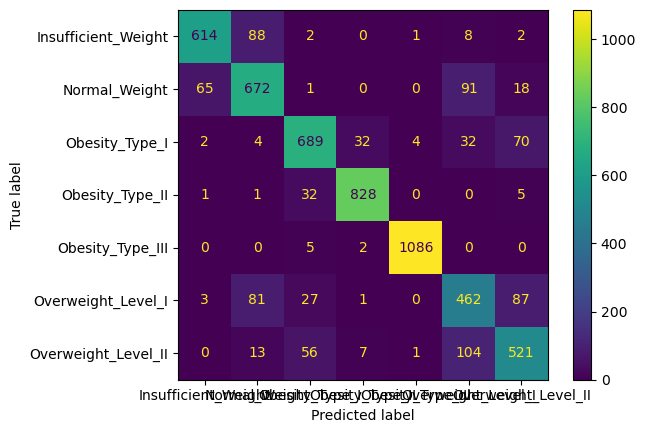

TRAIN - Accuracy: 0.9998833887236895, AUC_ROC_OVO: 0.999999983416084, AUC_ROC_OVR: 0.9999999862646322
TEST - Accuracy: 0.8520461699895068, AUC_ROC_OVO: 0.905844897570615, AUC_ROC_OVR: 0.907132959993363

Decision Tree (One Hot Categorical Only - Standard Scaler)
CV time 1.799 s


mean           std
fit_time                    0.171601  1.875928e-03
score_time                  0.043354  1.306585e-03
test_accuracy               0.847298  2.732021e-03
train_accuracy              0.999898  5.830426e-05
test_roc_auc_ovo_weighted   0.906745  1.698051e-03
train_roc_auc_ovo_weighted  1.000000  9.257741e-09
test_roc_auc_ovr_weighted   0.912010  1.543048e-03
train_roc_auc_ovr_weighted  1.000000  7.639538e-09

predict time 0.011 s
Confusion matrix: 


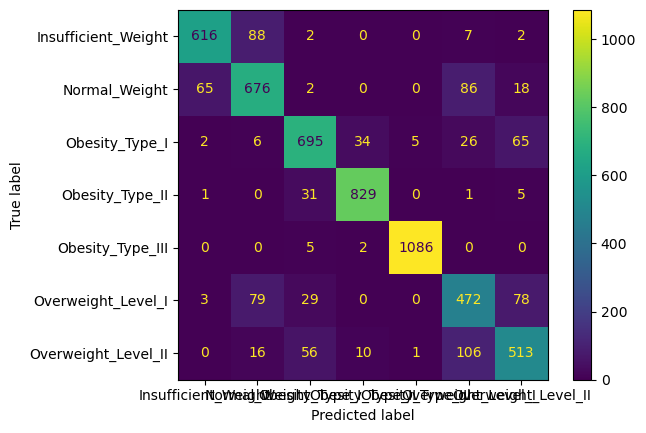

TRAIN - Accuracy: 0.9998833887236895, AUC_ROC_OVO: 0.999999983416084, AUC_ROC_OVR: 0.9999999862646322
TEST - Accuracy: 0.8546694648478489, AUC_ROC_OVO: 0.9074923886060472, AUC_ROC_OVR: 0.9087544275820549

Decision Tree (One Hot Categorical Only - Robust Scaler)
CV time 1.785 s


mean           std
fit_time                    0.171816  3.780779e-03
score_time                  0.042523  1.077720e-03
test_accuracy               0.848988  3.661885e-03
train_accuracy              0.999898  5.830426e-05
test_roc_auc_ovo_weighted   0.907865  2.205403e-03
train_roc_auc_ovo_weighted  1.000000  9.257741e-09
test_roc_auc_ovr_weighted   0.912977  2.083700e-03
train_roc_auc_ovr_weighted  1.000000  7.639538e-09

predict time 0.012 s
Confusion matrix: 


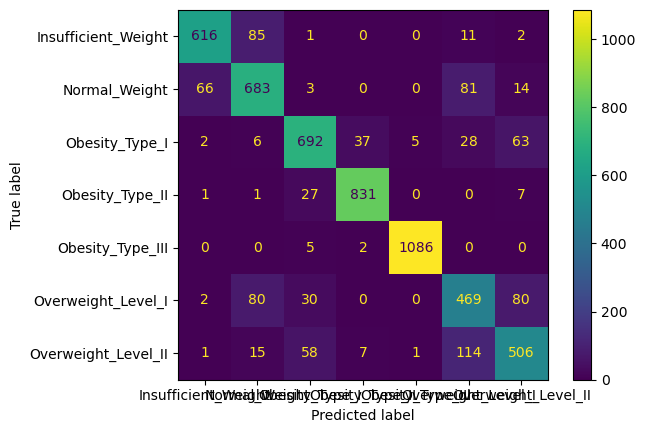

TRAIN - Accuracy: 0.9998833887236895, AUC_ROC_OVO: 0.999999983416084, AUC_ROC_OVR: 0.9999999862646322
TEST - Accuracy: 0.853969919552291, AUC_ROC_OVO: 0.906851452975923, AUC_ROC_OVR: 0.9081498887526223

Decision Tree Manual Encoding 1
CV time 1.725 s


mean           std
fit_time                    0.165600  2.359399e-03
score_time                  0.042508  1.337430e-03
test_accuracy               0.846831  1.815079e-03
train_accuracy              0.999898  5.830426e-05
test_roc_auc_ovo_weighted   0.906605  1.326682e-03
train_roc_auc_ovo_weighted  1.000000  9.257741e-09
test_roc_auc_ovr_weighted   0.911755  1.066561e-03
train_roc_auc_ovr_weighted  1.000000  7.639538e-09

predict time 0.01 s
Confusion matrix: 


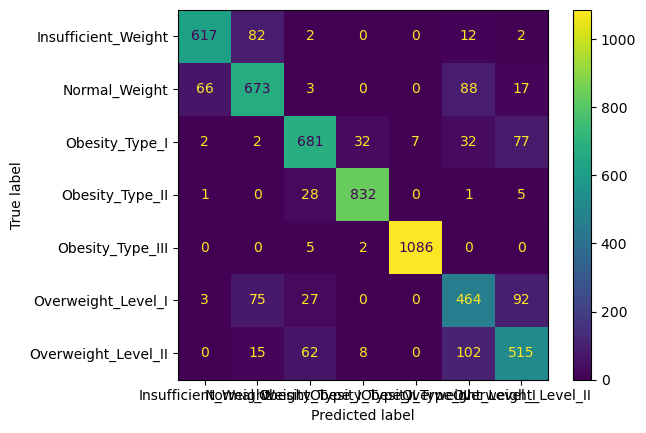

TRAIN - Accuracy: 0.9998833887236895, AUC_ROC_OVO: 0.999999983416084, AUC_ROC_OVR: 0.9999999862646322
TEST - Accuracy: 0.851346624693949, AUC_ROC_OVO: 0.9054168362608154, AUC_ROC_OVR: 0.9067118154906447

Decision Tree Manual Encoding 2
CV time 7.928 s


mean           std
fit_time                    1.139786  1.745190e-02
score_time                  0.048239  8.936388e-04
test_accuracy               0.840184  2.904479e-03
train_accuracy              0.999329  5.453658e-05
test_roc_auc_ovo_weighted   0.902687  1.895168e-03
train_roc_auc_ovo_weighted  1.000000  3.624713e-08
test_roc_auc_ovr_weighted   0.908008  1.718886e-03
train_roc_auc_ovr_weighted  1.000000  3.259400e-08

predict time 0.027 s
Confusion matrix: 


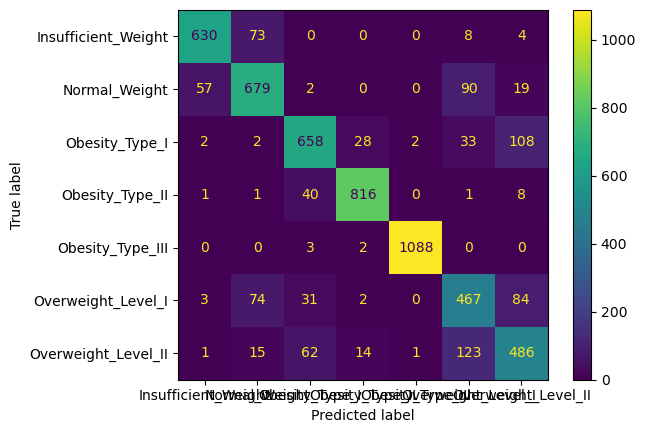

TRAIN - Accuracy: 0.9991837210658271, AUC_ROC_OVO: 0.9999995628109744, AUC_ROC_OVR: 0.9999996168279186
TEST - Accuracy: 0.8436516264428122, AUC_ROC_OVO: 0.9009518885592149, AUC_ROC_OVR: 0.9022904241905366



cv_test_mean  cv_test_std
(Ordinal)                                         0.848755     0.004188
(Ordinal Categorical Only - No Scaling)           0.850329     0.003168
(Ordinal Categorical Only - Standard Scaler)      0.850913     0.003515
(Ordinal Categorical Only - Robust Scaler)        0.850854     0.007093
(One Hot Categorical Only - No Scaling)           0.848114     0.002375
(One Hot Categorical Only - Standard Scaler)      0.847298     0.002732
(One Hot Categorical Only - Robust Scaler)        0.848988     0.003662
Manual Encoding 1                                 0.846831     0.001815
Manual Encoding 2                                 0.840184     0.002904

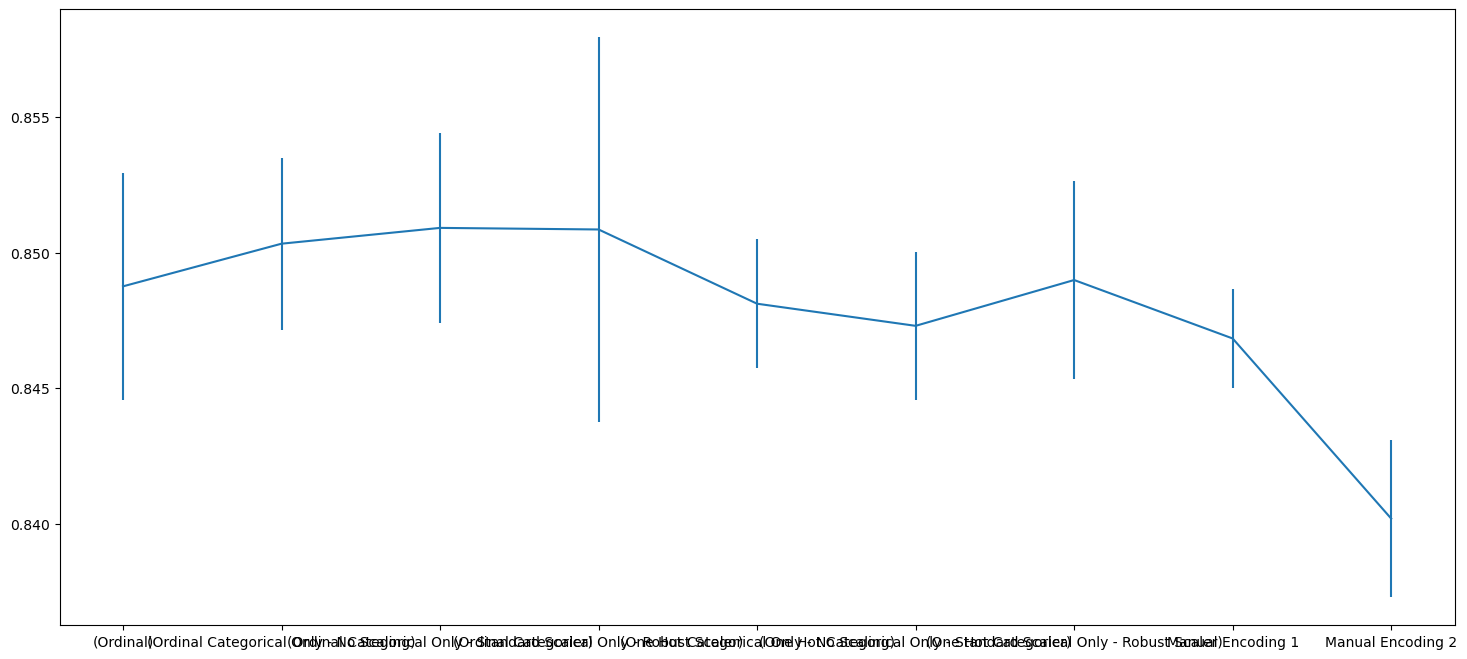

Best Preprocessing: (One Hot Categorical Only - Standard Scaler) - Test Accuracy: 0.8546694648478489


In [34]:
# Model 1 - Decision Tree
test = []
models = []
summaries = []
for i, name in enumerate(preprocessed):
    model = DecisionTreeClassifier()
    train_results, test_results, summary = train_and_evaluate_classifierCV(f"Decision Tree {name}", 
                                                                            model, 
                                                                            X_train[i], 
                                                                            y_train[i], 
                                                                            X_test[i], 
                                                                            y_test[i], 
                                                                            confusion=True, 
                                                                            supress_outputs=False)
    test.append(test_results[0])
    models.append(model)
    summaries.append(summary)
    print()

cv_test_mean = [summary['mean']['test_accuracy'] for summary in summaries]
cv_test_std =  [summary['std']['test_accuracy'] for summary in summaries]
cv_results = pd.DataFrame({'cv_test_mean':cv_test_mean, 'cv_test_std':cv_test_std})
cv_results.index = preprocessed
display(cv_results)
plt.figure(figsize=(18, 8))
plt.errorbar(cv_results.index, cv_results['cv_test_mean'], yerr=cv_results['cv_test_std'])
plt.show()

test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

(17151, 49, 7)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


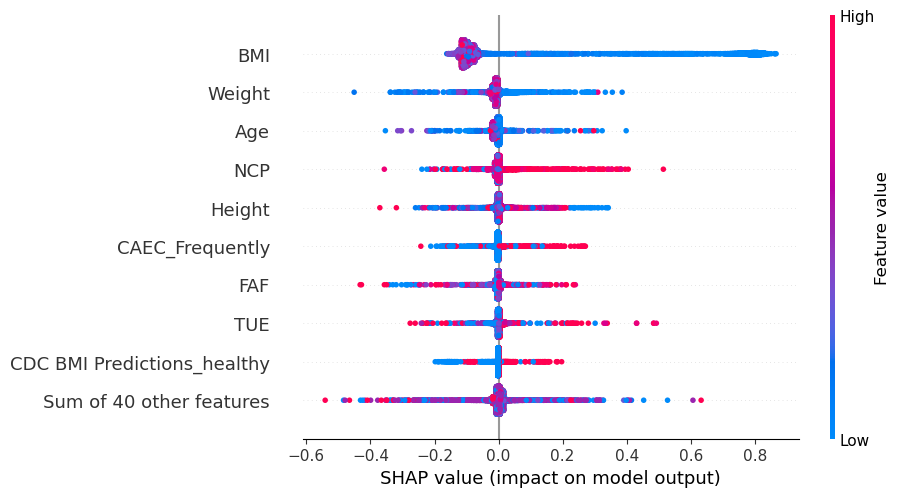

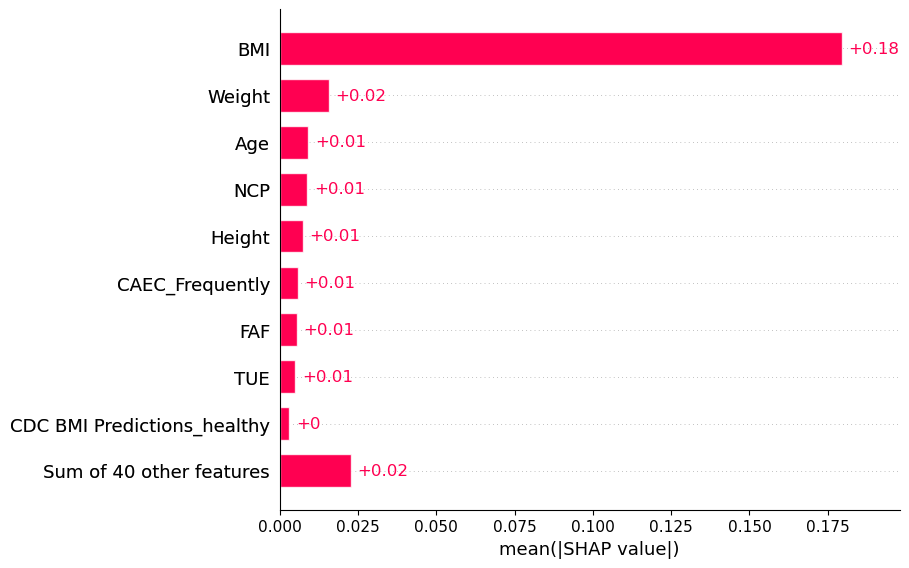

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


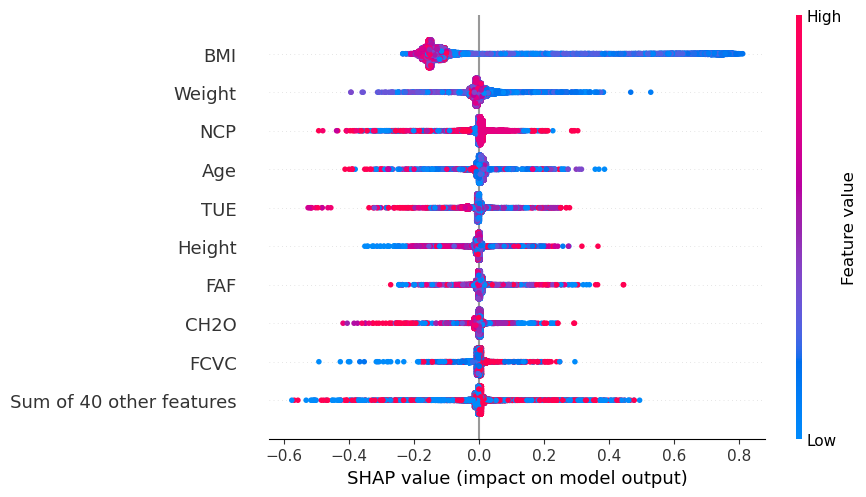

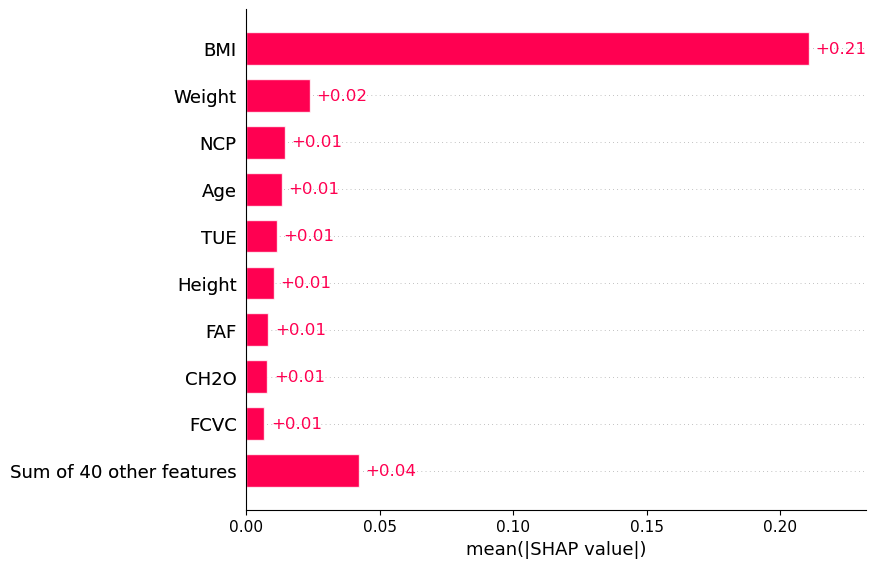

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


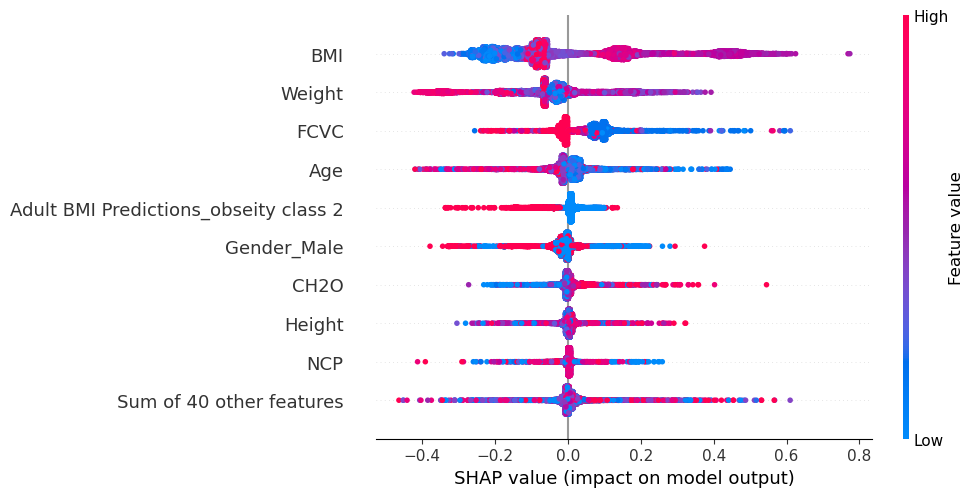

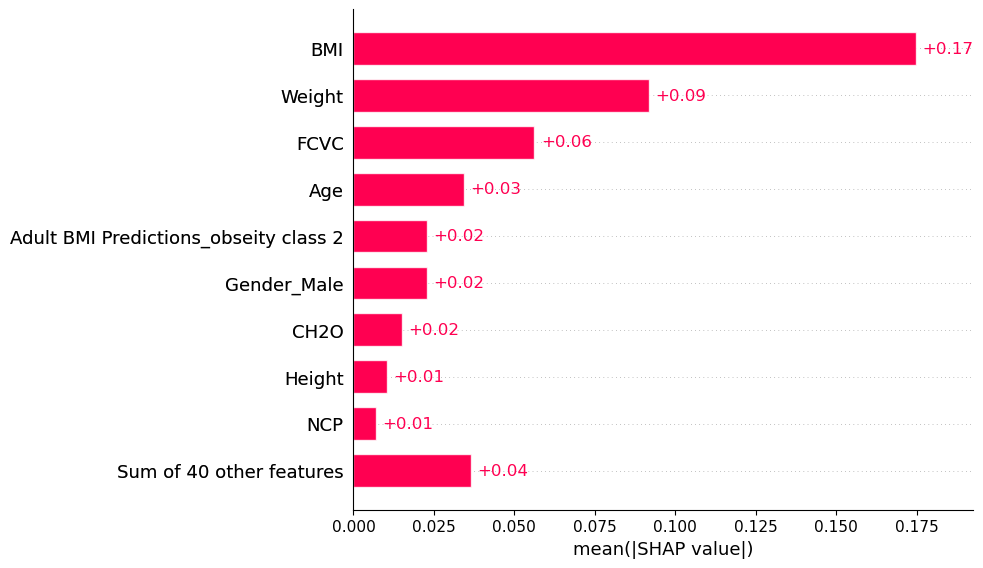

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


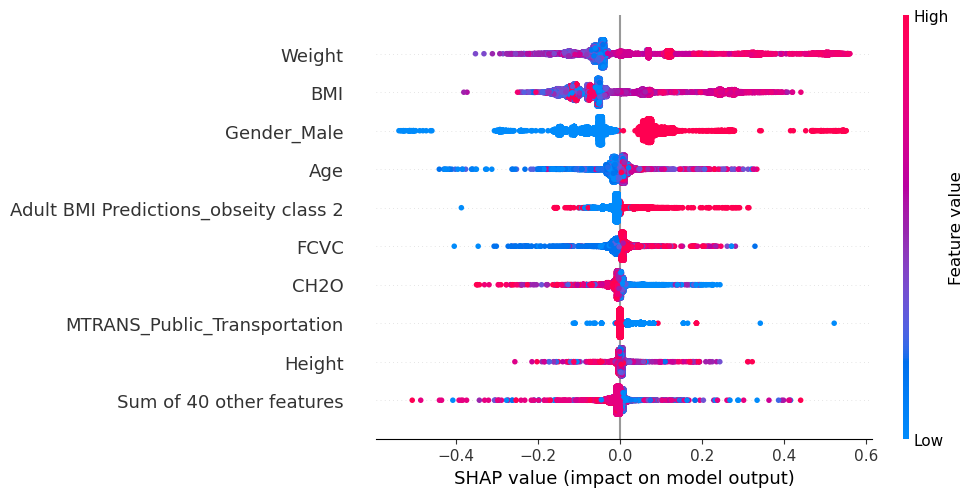

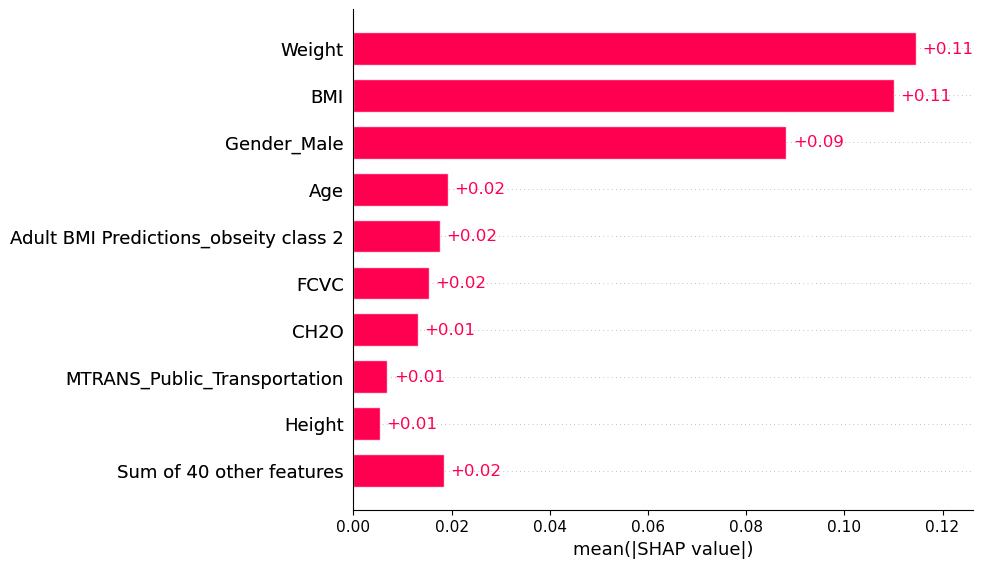

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


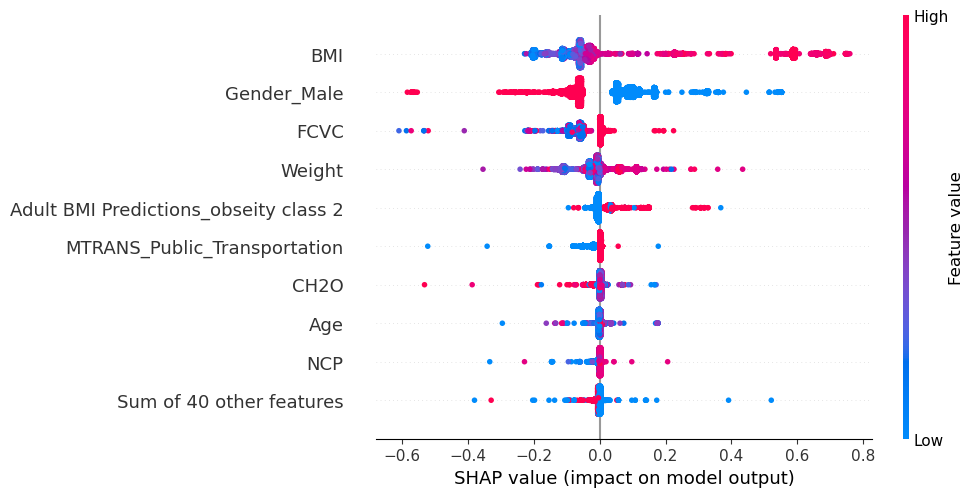

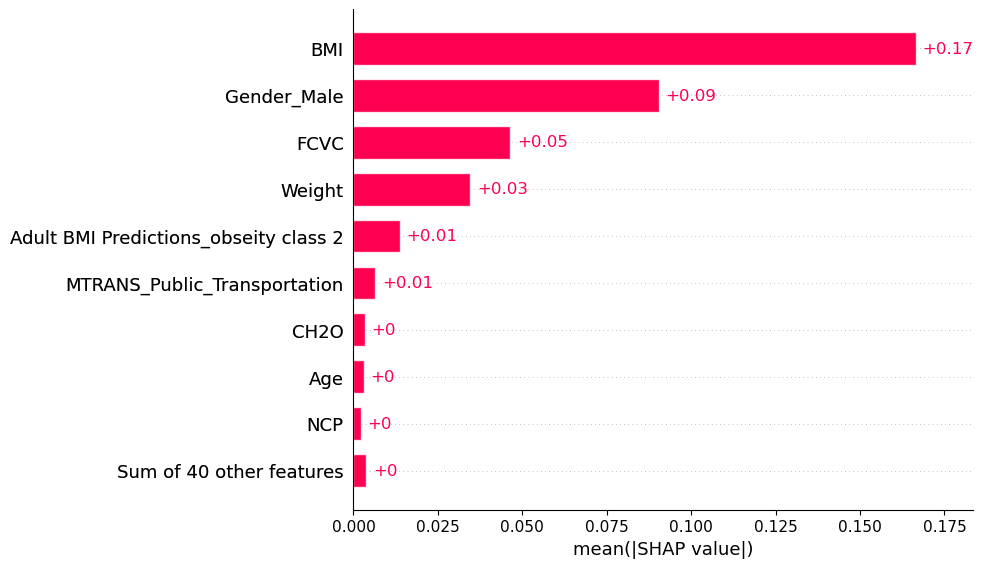

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


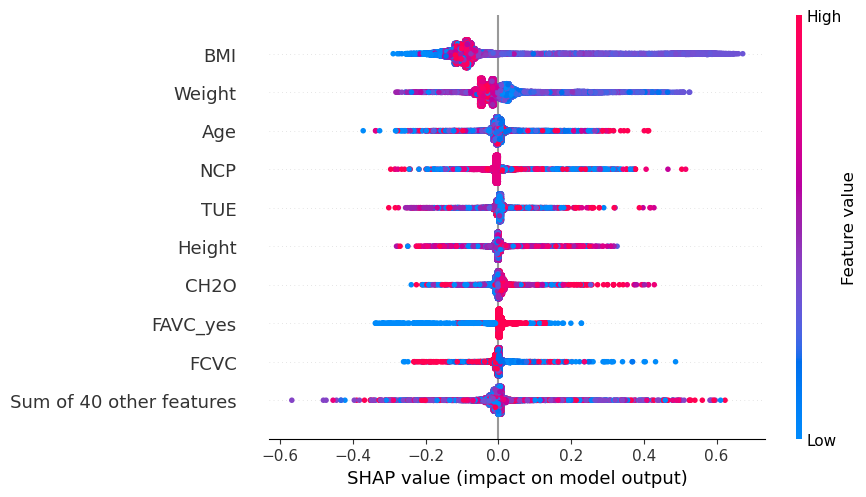

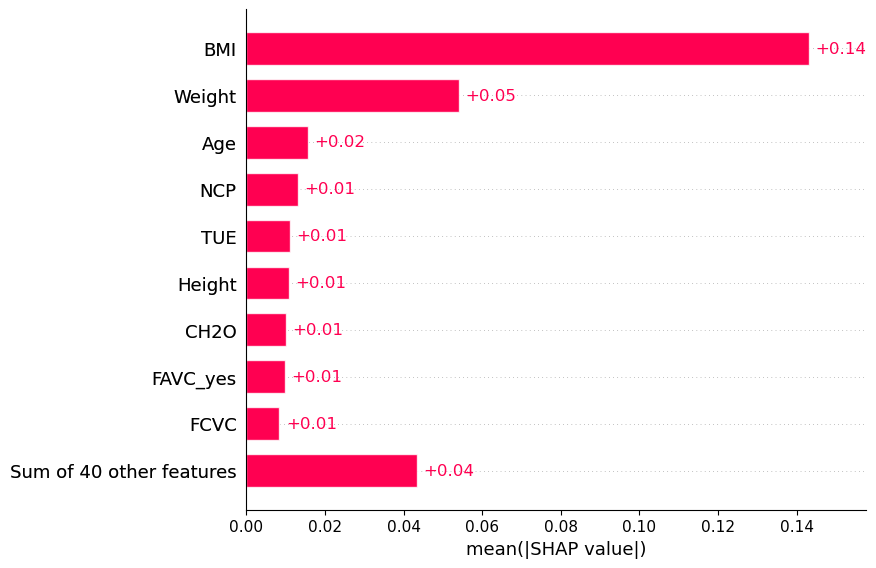

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


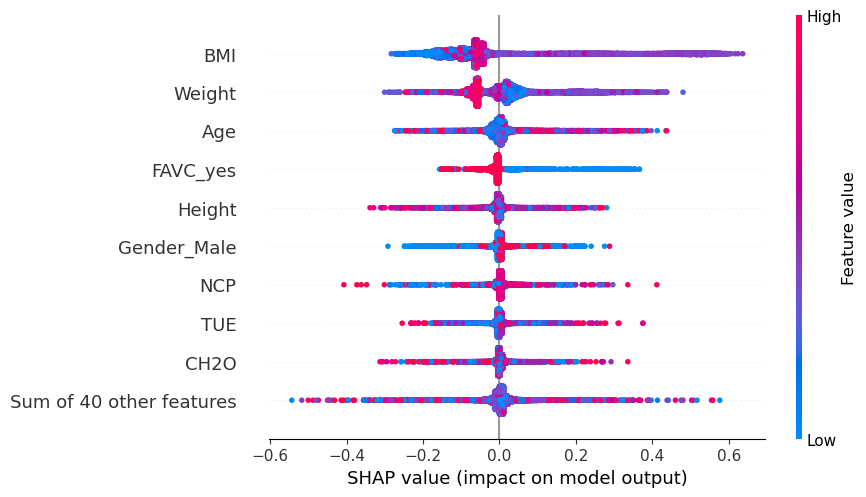

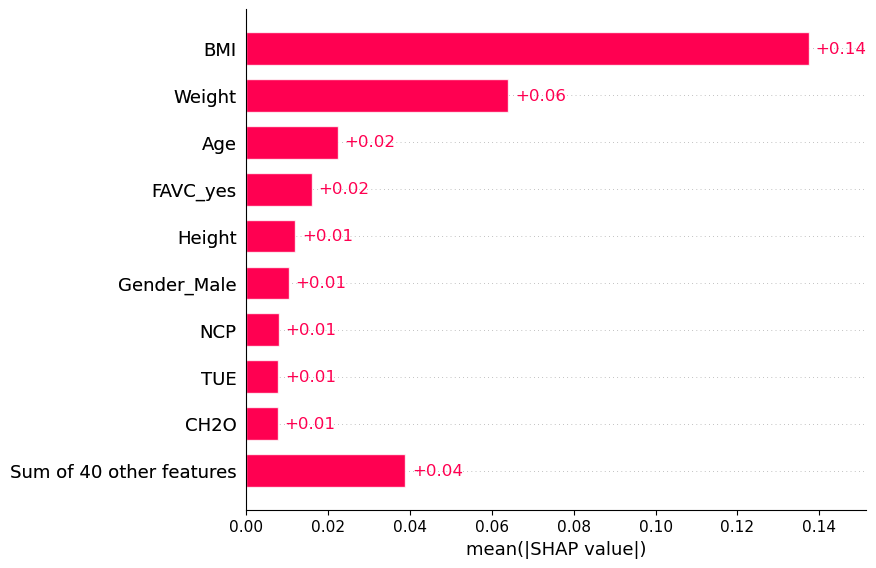

In [35]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(best_model)
shap_values = explainer(dataset)
print(shap_values.shape)

for i in range(shap_values.shape[2]):
    # summarize the effects of all the features
    shap.plots.beeswarm(shap_values[:, :, i])
    
    shap.plots.bar(shap_values[:, :, i])

Logistic Regression (Ordinal)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

CV time 74.647 s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


mean       std
fit_time                    11.841331  0.382325
score_time                   0.047516  0.003503
test_accuracy                0.864672  0.004745
train_accuracy               0.866655  0.002375
test_roc_auc_ovo_weighted    0.979537  0.001103
train_roc_auc_ovo_weighted   0.980087  0.000376
test_roc_auc_ovr_weighted    0.981611  0.001023
train_roc_auc_ovr_weighted   0.982113  0.000342

predict time 0.005 s
Confusion matrix: 


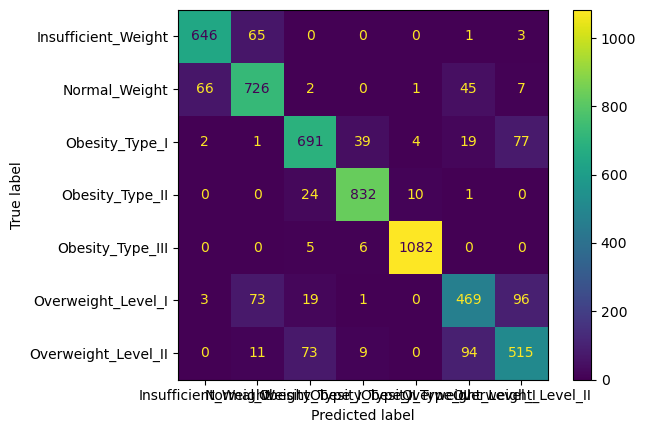

TRAIN - Accuracy: 0.866188560433794, AUC_ROC_OVO: 0.9782507696301892, AUC_ROC_OVR: 0.9804362702304982
TEST - Accuracy: 0.8676110528156699, AUC_ROC_OVO: 0.9777182214388986, AUC_ROC_OVR: 0.9798444480452805

Logistic Regression (Ordinal Categorical Only - No Scaling)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

CV time 81.293 s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


mean       std
fit_time                    13.156788  1.471358
score_time                   0.050351  0.004891
test_accuracy                0.873301  0.004762
train_accuracy               0.876217  0.002564
test_roc_auc_ovo_weighted    0.980671  0.001251
train_roc_auc_ovo_weighted   0.981488  0.000656
test_roc_auc_ovr_weighted    0.982610  0.001157
train_roc_auc_ovr_weighted   0.983360  0.000594

predict time 0.005 s
Confusion matrix: 


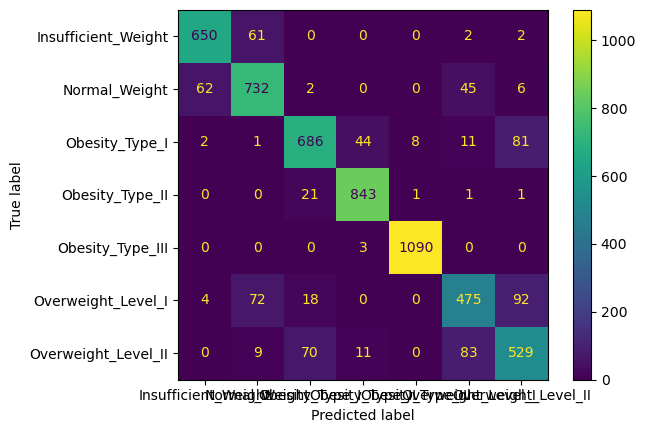

TRAIN - Accuracy: 0.8772083260451286, AUC_ROC_OVO: 0.9799800015028038, AUC_ROC_OVR: 0.9819718441393945
TEST - Accuracy: 0.8753060510668066, AUC_ROC_OVO: 0.9789173011581253, AUC_ROC_OVR: 0.9809251974081008

Logistic Regression (Ordinal Categorical Only - Standard Scaler)
CV time 14.268 s


mean       std
fit_time                    2.155663  0.183247
score_time                  0.046284  0.001227
test_accuracy               0.875109  0.004615
train_accuracy              0.878404  0.001617
test_roc_auc_ovo_weighted   0.981187  0.001405
train_roc_auc_ovo_weighted  0.981943  0.000392
test_roc_auc_ovr_weighted   0.983096  0.001290
train_roc_auc_ovr_weighted  0.983786  0.000353

predict time 0.005 s
Confusion matrix: 


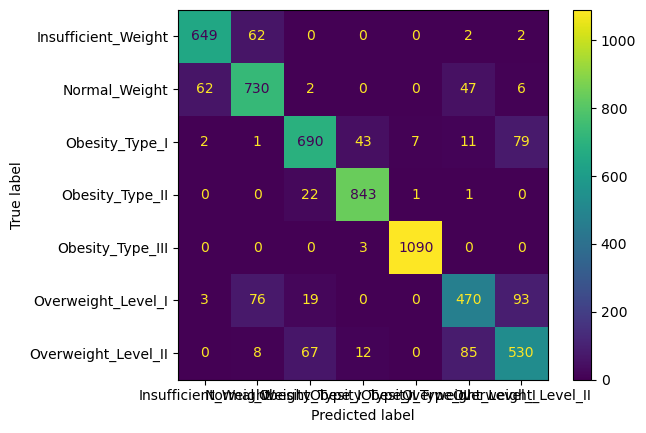

TRAIN - Accuracy: 0.8788408839134745, AUC_ROC_OVO: 0.9801940277929733, AUC_ROC_OVR: 0.9821764901307951
TEST - Accuracy: 0.8747813920951382, AUC_ROC_OVO: 0.979063388667112, AUC_ROC_OVR: 0.9810578663514278

Logistic Regression (Ordinal Categorical Only - Robust Scaler)
CV time 14.302 s


mean       std
fit_time                    2.100637  0.090555
score_time                  0.046519  0.000609
test_accuracy               0.872310  0.005802
train_accuracy              0.875722  0.001402
test_roc_auc_ovo_weighted   0.980554  0.001355
train_roc_auc_ovo_weighted  0.981305  0.000384
test_roc_auc_ovr_weighted   0.982539  0.001253
train_roc_auc_ovr_weighted  0.983223  0.000347

predict time 0.006 s
Confusion matrix: 


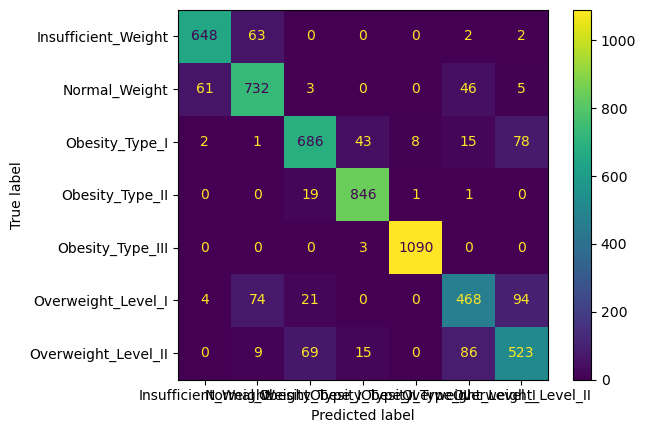

TRAIN - Accuracy: 0.8764503527491109, AUC_ROC_OVO: 0.979592444196231, AUC_ROC_OVR: 0.9816481276132425
TEST - Accuracy: 0.8732074151801329, AUC_ROC_OVO: 0.9784921550658884, AUC_ROC_OVR: 0.9805633423374154

Logistic Regression (One Hot Categorical Only - No Scaling)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

CV time 95.421 s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


mean       std
fit_time                    15.096604  0.415186
score_time                   0.049045  0.001513
test_accuracy                0.876450  0.007518
train_accuracy               0.879555  0.002208
test_roc_auc_ovo_weighted    0.981832  0.001536
train_roc_auc_ovo_weighted   0.982970  0.000502
test_roc_auc_ovr_weighted    0.983615  0.001384
train_roc_auc_ovr_weighted   0.984660  0.000443

predict time 0.008 s
Confusion matrix: 


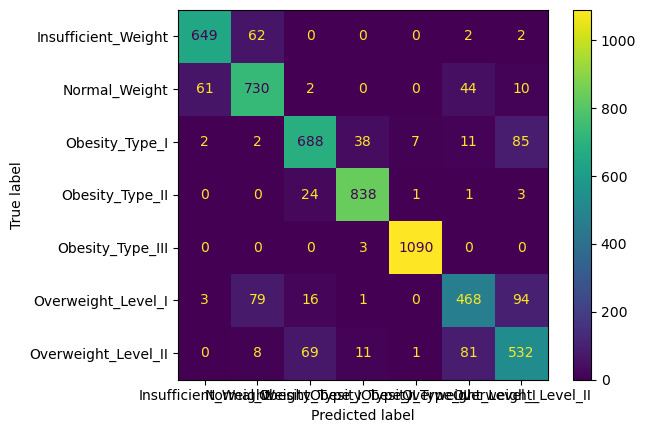

TRAIN - Accuracy: 0.8788408839134745, AUC_ROC_OVO: 0.9810012617431403, AUC_ROC_OVR: 0.9828574879333677
TEST - Accuracy: 0.8735571878279118, AUC_ROC_OVO: 0.9797215312870559, AUC_ROC_OVR: 0.9816336352103232

Logistic Regression (One Hot Categorical Only - Standard Scaler)
CV time 9.54 s


mean       std
fit_time                    1.350704  0.104753
score_time                  0.047592  0.000870
test_accuracy               0.878199  0.006057
train_accuracy              0.880780  0.001632
test_roc_auc_ovo_weighted   0.982310  0.001434
train_roc_auc_ovo_weighted  0.983377  0.000355
test_roc_auc_ovr_weighted   0.984064  0.001287
train_roc_auc_ovr_weighted  0.985041  0.000316

predict time 0.009 s
Confusion matrix: 


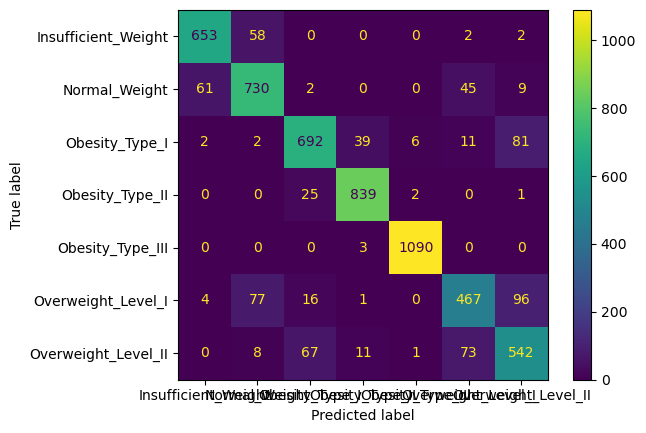

TRAIN - Accuracy: 0.8811148038015276, AUC_ROC_OVO: 0.9817935337968906, AUC_ROC_OVR: 0.9835755238712725
TEST - Accuracy: 0.8767051416579223, AUC_ROC_OVO: 0.9803415284808177, AUC_ROC_OVR: 0.9821755478157588

Logistic Regression (One Hot Categorical Only - Robust Scaler)
CV time 9.333 s


mean       std
fit_time                    1.383487  0.048223
score_time                  0.047893  0.000506
test_accuracy               0.875284  0.006322
train_accuracy              0.877719  0.001495
test_roc_auc_ovo_weighted   0.981577  0.001384
train_roc_auc_ovo_weighted  0.982649  0.000340
test_roc_auc_ovr_weighted   0.983421  0.001244
train_roc_auc_ovr_weighted  0.984399  0.000303

predict time 0.008 s
Confusion matrix: 


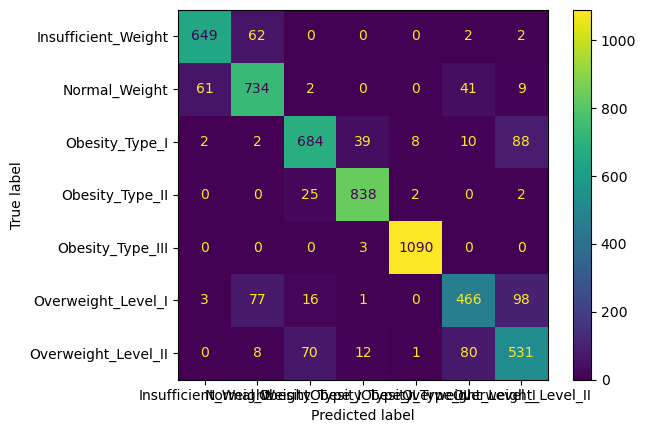

TRAIN - Accuracy: 0.8782578275319224, AUC_ROC_OVO: 0.9810985964153031, AUC_ROC_OVR: 0.9829634551825759
TEST - Accuracy: 0.8730325288562435, AUC_ROC_OVO: 0.9797377146075379, AUC_ROC_OVR: 0.9816538952158477

Logistic Regression Manual Encoding 1


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

CV time 90.216 s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


mean       std
fit_time                    14.225233  0.361423
score_time                   0.047724  0.000657
test_accuracy                0.874468  0.004172
train_accuracy               0.877237  0.001152
test_roc_auc_ovo_weighted    0.981094  0.001478
train_roc_auc_ovo_weighted   0.981984  0.000459
test_roc_auc_ovr_weighted    0.982994  0.001348
train_roc_auc_ovr_weighted   0.983804  0.000405

predict time 0.008 s
Confusion matrix: 


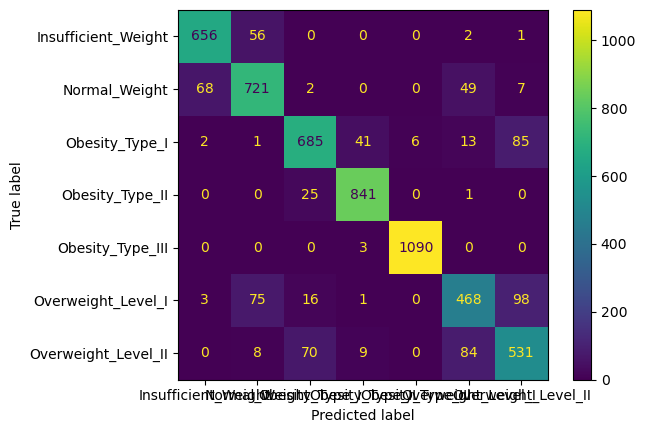

TRAIN - Accuracy: 0.8775581598740598, AUC_ROC_OVO: 0.9802092001232735, AUC_ROC_OVR: 0.9821790577967523
TEST - Accuracy: 0.8730325288562435, AUC_ROC_OVO: 0.9791652154526679, AUC_ROC_OVR: 0.9811486299799502

Logistic Regression Manual Encoding 2
CV time 38.903 s


mean       std
fit_time                    6.107033  0.286868
score_time                  0.053722  0.001290
test_accuracy               0.874351  0.005856
train_accuracy              0.883666  0.002380
test_roc_auc_ovo_weighted   0.981501  0.000961
train_roc_auc_ovo_weighted  0.984065  0.000326
test_roc_auc_ovr_weighted   0.983368  0.000890
train_roc_auc_ovr_weighted  0.985711  0.000291

predict time 0.043 s
Confusion matrix: 


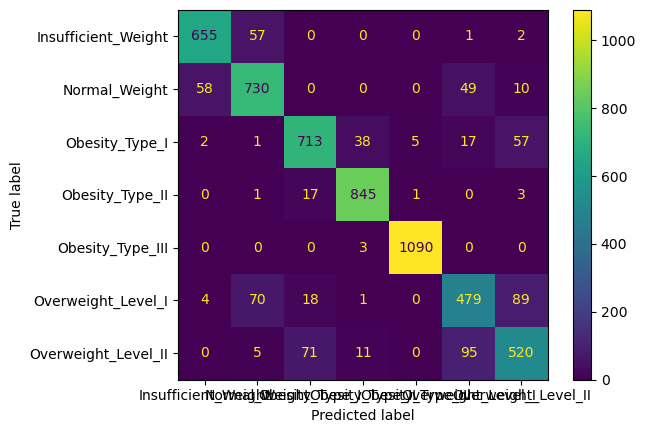

TRAIN - Accuracy: 0.8827473616698734, AUC_ROC_OVO: 0.9822865018496042, AUC_ROC_OVR: 0.9840617791952123
TEST - Accuracy: 0.8800279818118223, AUC_ROC_OVO: 0.9798598704334096, AUC_ROC_OVR: 0.9818019464280029



cv_test_mean  cv_test_std
(Ordinal)                                         0.864672     0.004745
(Ordinal Categorical Only - No Scaling)           0.873301     0.004762
(Ordinal Categorical Only - Standard Scaler)      0.875109     0.004615
(Ordinal Categorical Only - Robust Scaler)        0.872310     0.005802
(One Hot Categorical Only - No Scaling)           0.876450     0.007518
(One Hot Categorical Only - Standard Scaler)      0.878199     0.006057
(One Hot Categorical Only - Robust Scaler)        0.875284     0.006322
Manual Encoding 1                                 0.874468     0.004172
Manual Encoding 2                                 0.874351     0.005856

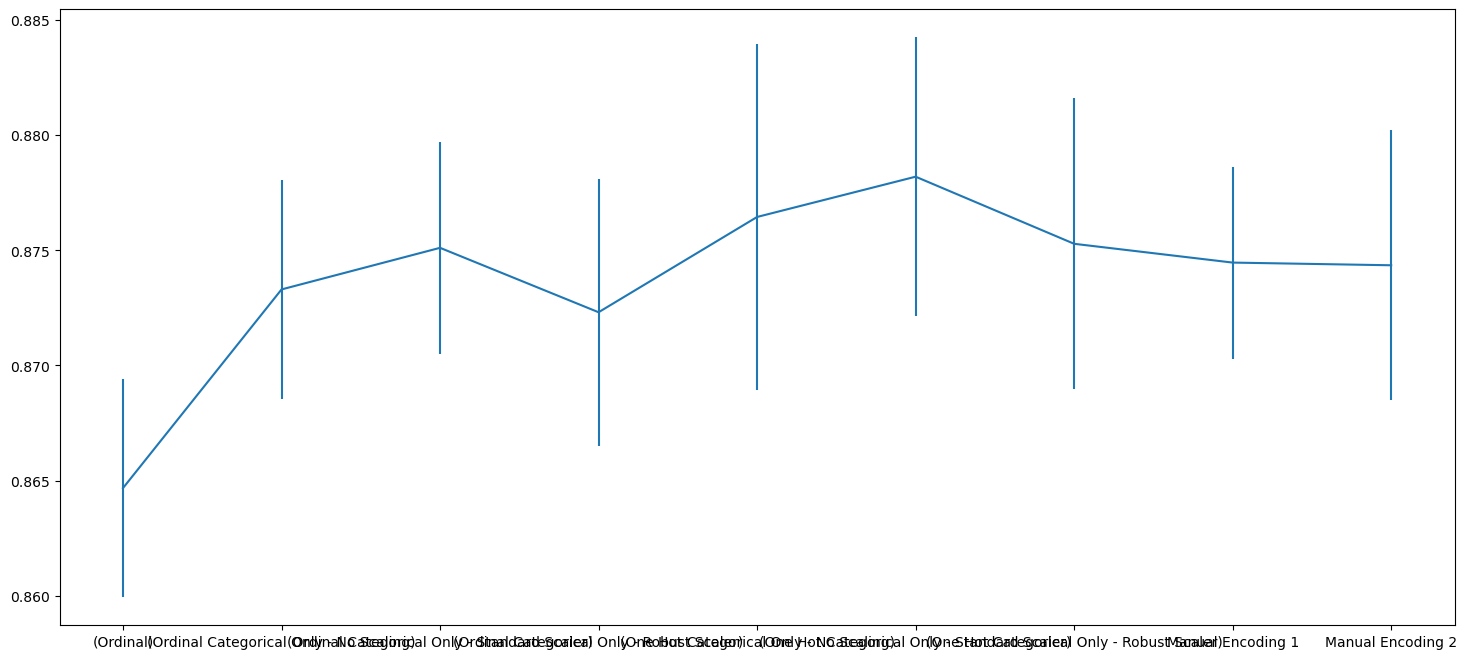

Best Preprocessing: Manual Encoding 2 - Test Accuracy: 0.8800279818118223


In [54]:
# Model 2a - Logistic Regression
test = []
models = []
summaries = []
for i, name in enumerate(preprocessed):
    model = LogisticRegression(max_iter = 5000)
    train_results, test_results, summary = train_and_evaluate_classifierCV(f"Logistic Regression {name}", 
                                                                            model, 
                                                                            X_train[i], 
                                                                            y_train[i], 
                                                                            X_test[i], 
                                                                            y_test[i], 
                                                                            confusion=True, 
                                                                            supress_outputs=False)
    test.append(test_results[0])
    models.append(model)
    summaries.append(summary)
    print()

cv_test_mean = [summary['mean']['test_accuracy'] for summary in summaries]
cv_test_std =  [summary['std']['test_accuracy'] for summary in summaries]
cv_results = pd.DataFrame({'cv_test_mean':cv_test_mean, 'cv_test_std':cv_test_std})
cv_results.index = preprocessed
display(cv_results)
plt.figure(figsize=(18, 8))
plt.errorbar(cv_results.index, cv_results['cv_test_mean'], yerr=cv_results['cv_test_std'])
plt.show()

test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

(17151, 198, 7)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


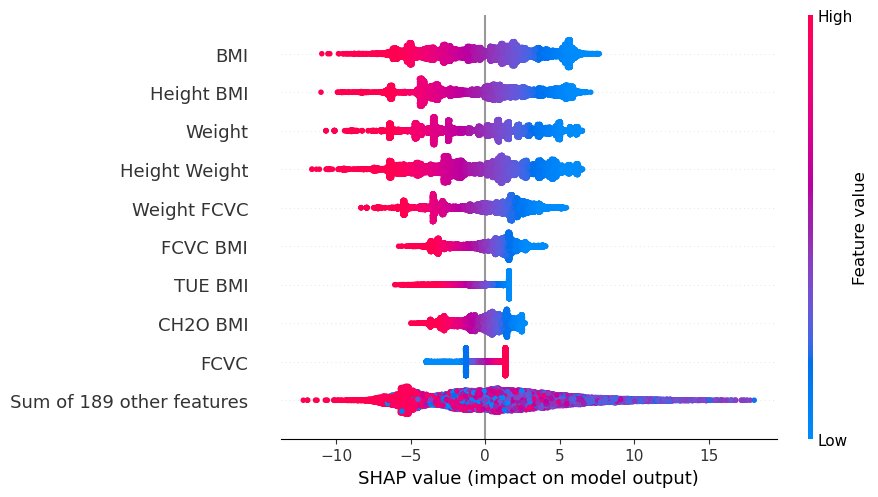

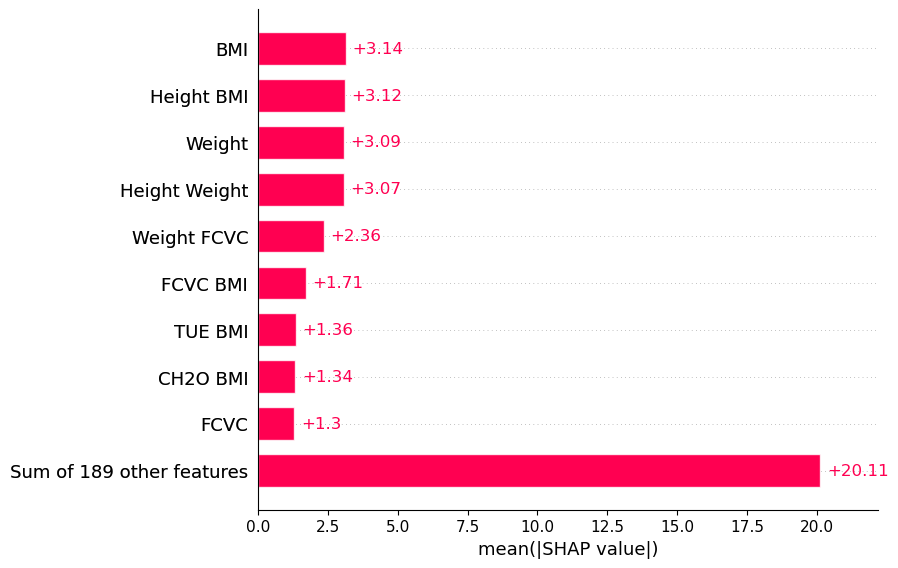

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


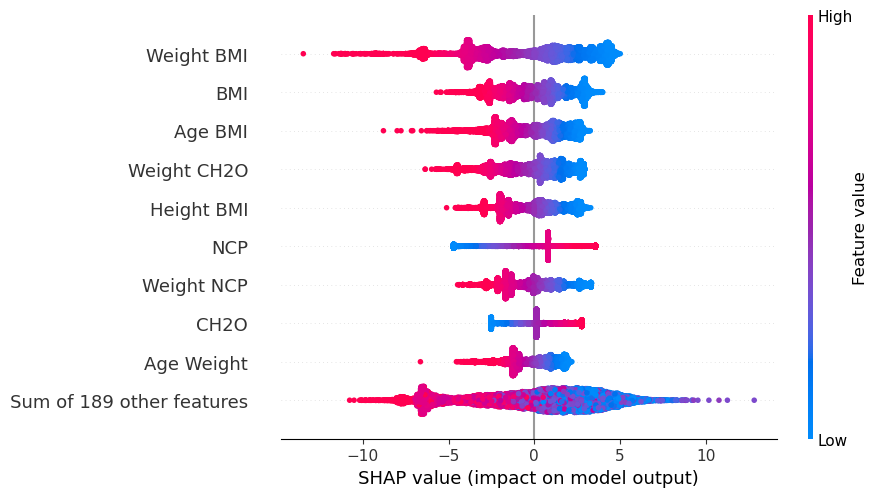

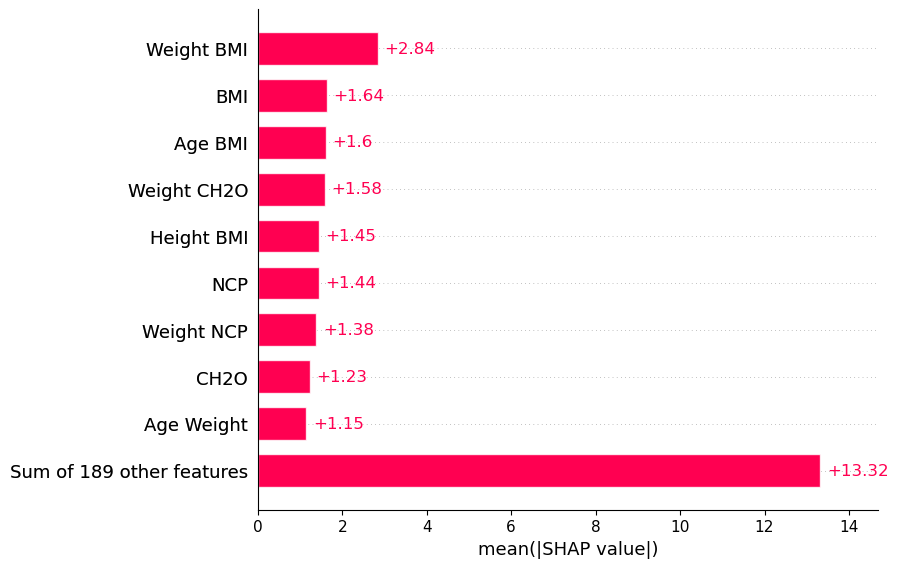

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


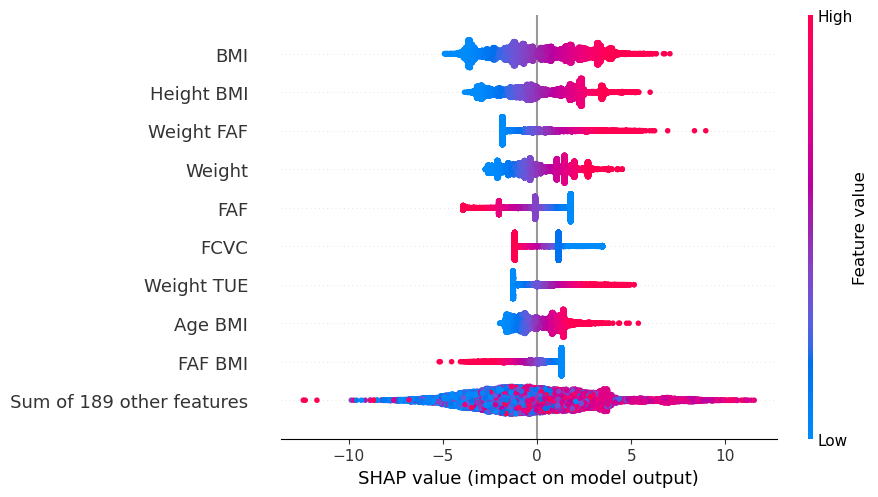

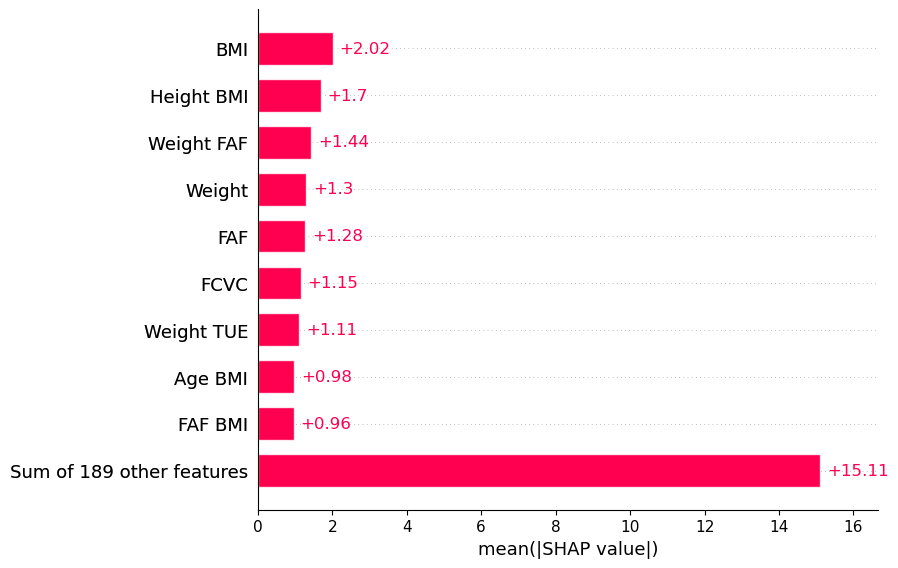

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


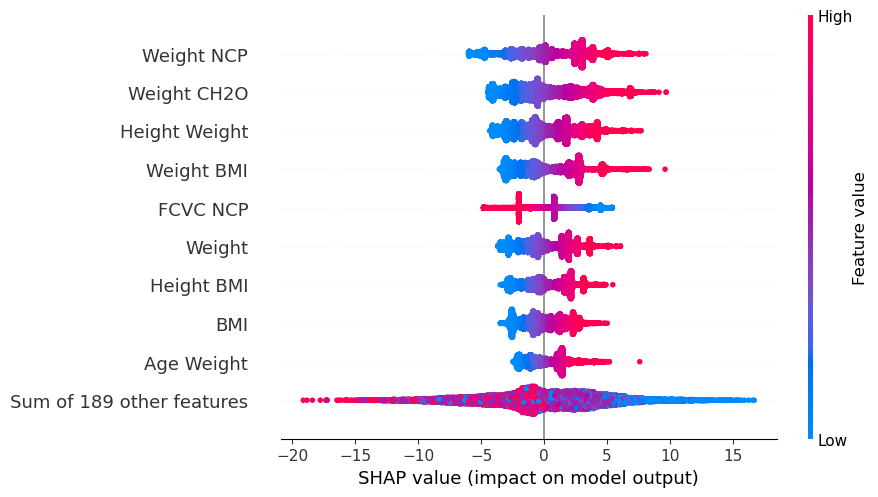

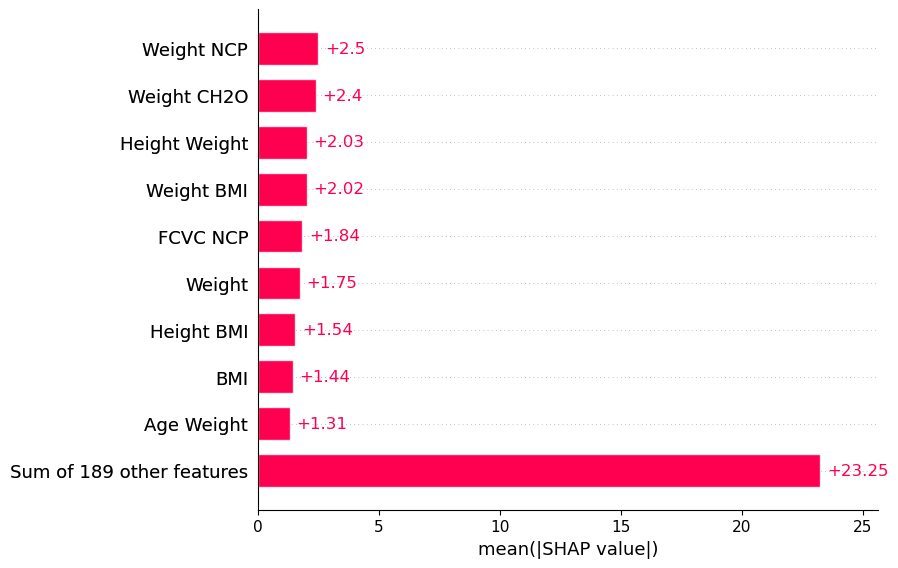

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


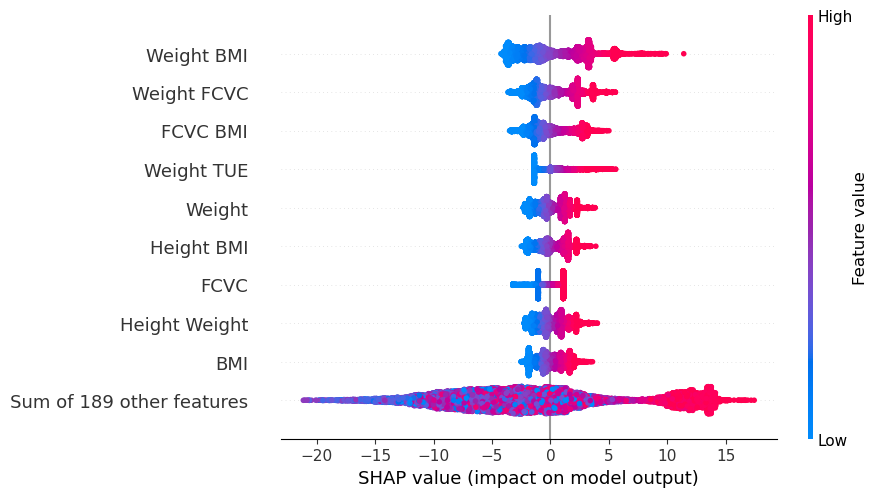

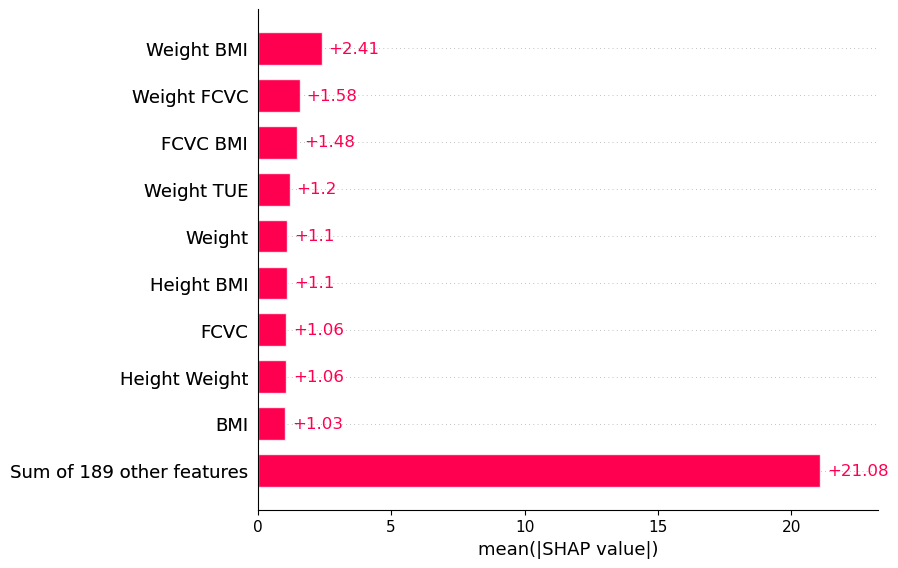

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


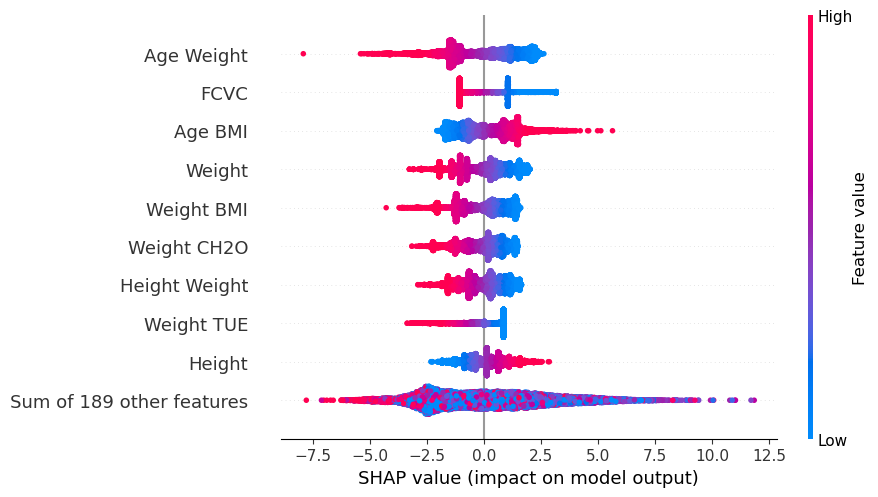

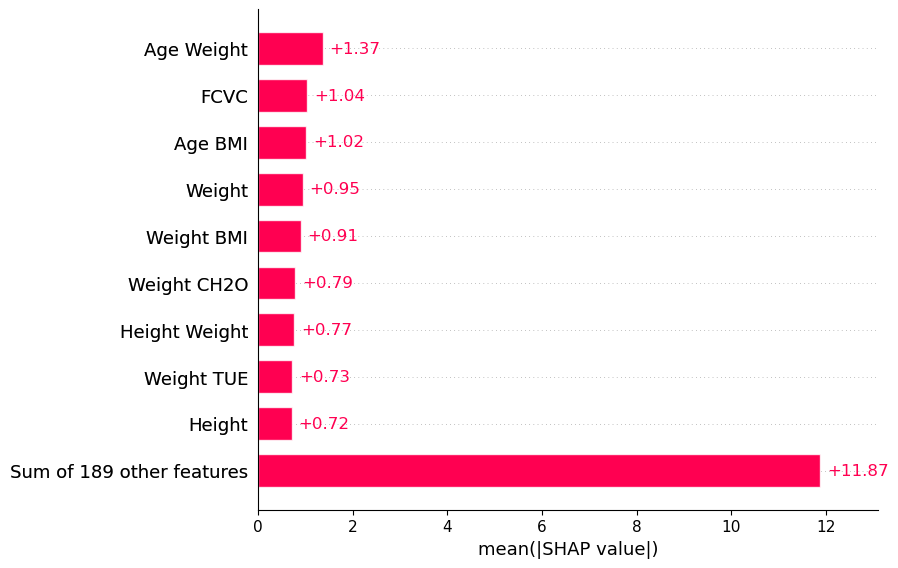

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


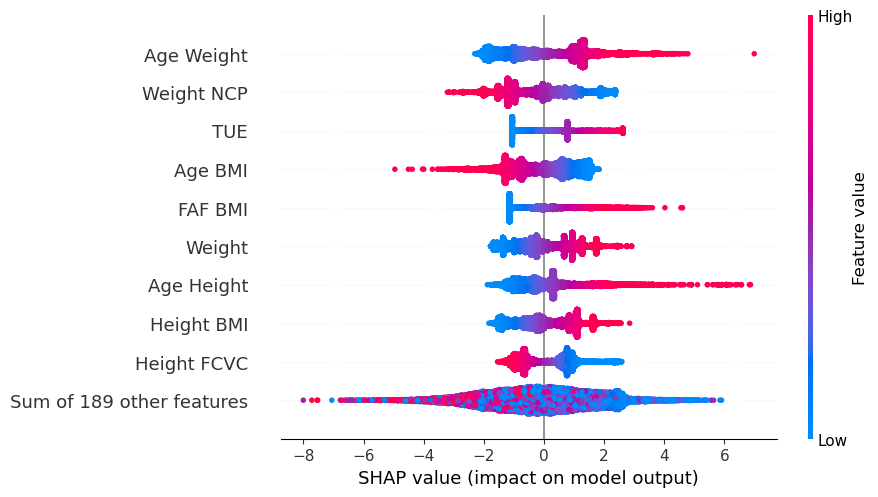

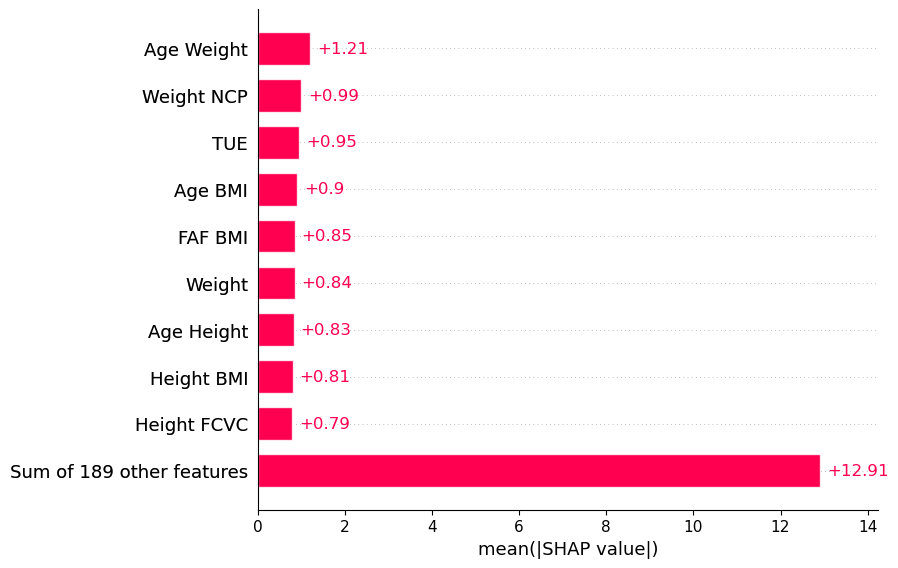

In [37]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.LinearExplainer(best_model, dataset)
shap_values = explainer(dataset)
print(shap_values.shape)

for i in range(shap_values.shape[2]):
    # summarize the effects of all the features
    shap.plots.beeswarm(shap_values[:, :, i])
    
    shap.plots.bar(shap_values[:, :, i])

In [38]:
# Model 2b - Logistic Regression w/ CV
# warnings.filterwarnings('ignore')

# test = []
# models = []
# for i, name in enumerate(preprocessed):
#     model = LogisticRegressionCV(max_iter = 1000)
#     train_results, test_results = train_and_evaluate_classifier(f"Logistic Regression CV {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False)
#     test.append(test_results[0])
#     print()
    
# test = np.array(test)
# loc_best_test = np.argmax(test)
# print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
# best_model = models[loc_best_test]
# dataset = X_train[loc_best_test]

In [39]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# explainer = shap.LinearExplainer(best_model, dataset)
# shap_values = explainer(dataset)
# print(shap_values.shape)

# for i in range(shap_values.shape[2]):
#     # summarize the effects of all the features
#     shap.plots.beeswarm(shap_values[:, :, i])
    
#     shap.plots.bar(shap_values[:, :, i])

MLP (Ordinal)
CV time 20.561 s


mean       std
fit_time                    3.335737  0.304596
score_time                  0.048662  0.000915
test_accuracy               0.817971  0.018471
train_accuracy              0.836525  0.018416
test_roc_auc_ovo_weighted   0.972679  0.002528
train_roc_auc_ovo_weighted  0.979024  0.002029
test_roc_auc_ovr_weighted   0.975447  0.002495
train_roc_auc_ovr_weighted  0.981169  0.001995

predict time 0.015 s
Confusion matrix: 


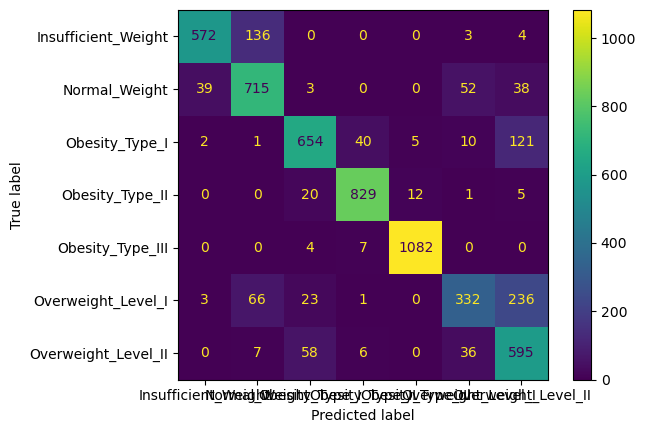

TRAIN - Accuracy: 0.8516704565331468, AUC_ROC_OVO: 0.9788125172617493, AUC_ROC_OVR: 0.9808873019417577
TEST - Accuracy: 0.835781741867786, AUC_ROC_OVO: 0.973580742987818, AUC_ROC_OVR: 0.9761173094901079

MLP (Ordinal Categorical Only - No Scaling)


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


CV time 44.068 s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


mean       std
fit_time                    7.320341  0.206828
score_time                  0.050928  0.000797
test_accuracy               0.872368  0.009867
train_accuracy              0.880765  0.007052
test_roc_auc_ovo_weighted   0.982641  0.001133
train_roc_auc_ovo_weighted  0.985057  0.000805
test_roc_auc_ovr_weighted   0.984415  0.001052
train_roc_auc_ovr_weighted  0.986608  0.000680

predict time 0.016 s
Confusion matrix: 


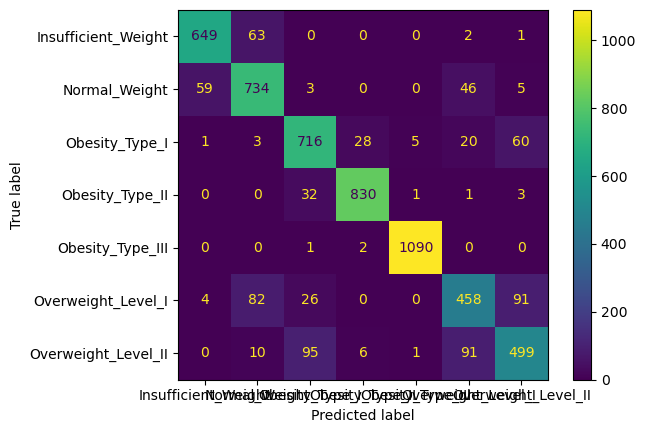

TRAIN - Accuracy: 0.8819893883738558, AUC_ROC_OVO: 0.9825297526664581, AUC_ROC_OVR: 0.9843225699494533
TEST - Accuracy: 0.8702343476740119, AUC_ROC_OVO: 0.9805002337054075, AUC_ROC_OVR: 0.9824365697920124

MLP (Ordinal Categorical Only - Standard Scaler)


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


CV time 49.939 s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


mean       std
fit_time                    7.868137  0.070814
score_time                  0.048227  0.000419
test_accuracy               0.883039  0.004432
train_accuracy              0.914495  0.002583
test_roc_auc_ovo_weighted   0.984633  0.000913
train_roc_auc_ovo_weighted  0.991684  0.000367
test_roc_auc_ovr_weighted   0.986190  0.000813
train_roc_auc_ovr_weighted  0.992569  0.000324

predict time 0.015 s
Confusion matrix: 


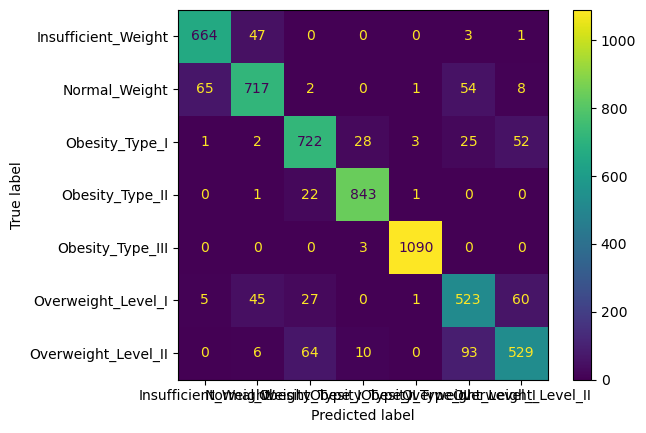

TRAIN - Accuracy: 0.9153985190367908, AUC_ROC_OVO: 0.9908049473973409, AUC_ROC_OVR: 0.9917377207272039
TEST - Accuracy: 0.8898216159496327, AUC_ROC_OVO: 0.9844294685947869, AUC_ROC_OVR: 0.9859198420686381

MLP (Ordinal Categorical Only - Robust Scaler)


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


CV time 49.472 s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


mean       std
fit_time                    7.779569  0.180891
score_time                  0.048838  0.001204
test_accuracy               0.885138  0.003361
train_accuracy              0.912702  0.001701
test_roc_auc_ovo_weighted   0.984438  0.001062
train_roc_auc_ovo_weighted  0.991113  0.000059
test_roc_auc_ovr_weighted   0.986023  0.000933
train_roc_auc_ovr_weighted  0.992053  0.000044

predict time 0.016 s
Confusion matrix: 


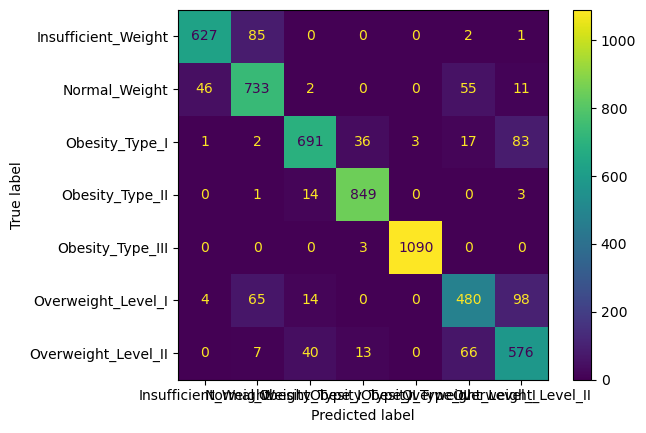

TRAIN - Accuracy: 0.9109089848988398, AUC_ROC_OVO: 0.990227431588756, AUC_ROC_OVR: 0.9912100087235131
TEST - Accuracy: 0.8824763903462749, AUC_ROC_OVO: 0.9842256308301578, AUC_ROC_OVR: 0.9857041648546357

MLP (One Hot Categorical Only - No Scaling)


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


CV time 43.516 s


mean       std
fit_time                    7.098887  1.357430
score_time                  0.050743  0.001120
test_accuracy               0.878782  0.005504
train_accuracy              0.889773  0.003306
test_roc_auc_ovo_weighted   0.983631  0.001020
train_roc_auc_ovo_weighted  0.986789  0.000733
test_roc_auc_ovr_weighted   0.985318  0.000878
train_roc_auc_ovr_weighted  0.988180  0.000674

predict time 0.019 s
Confusion matrix: 


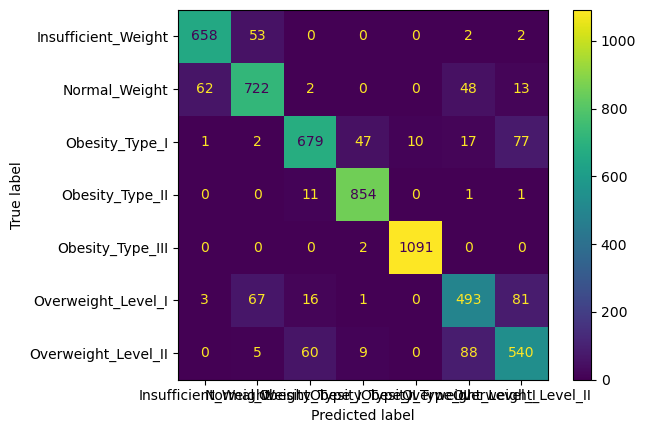

TRAIN - Accuracy: 0.890968456649758, AUC_ROC_OVO: 0.9859262573450174, AUC_ROC_OVR: 0.9873522313318281
TEST - Accuracy: 0.8809024134312696, AUC_ROC_OVO: 0.983013863475692, AUC_ROC_OVR: 0.9846858951342682

MLP (One Hot Categorical Only - Standard Scaler)


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


CV time 56.13 s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


mean       std
fit_time                    8.821522  0.052889
score_time                  0.049387  0.000587
test_accuracy               0.881465  0.003492
train_accuracy              0.931564  0.000939
test_roc_auc_ovo_weighted   0.984199  0.001010
train_roc_auc_ovo_weighted  0.994235  0.000202
test_roc_auc_ovr_weighted   0.985788  0.000891
train_roc_auc_ovr_weighted  0.994852  0.000176

predict time 0.02 s
Confusion matrix: 


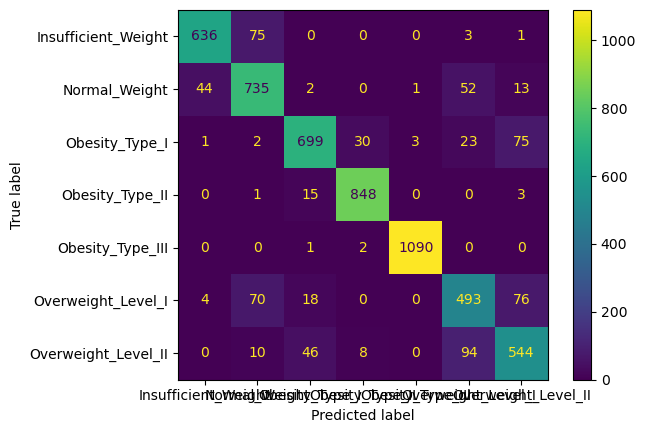

TRAIN - Accuracy: 0.9258352282665734, AUC_ROC_OVO: 0.9928646390723586, AUC_ROC_OVR: 0.9935939194527716
TEST - Accuracy: 0.8823015040223855, AUC_ROC_OVO: 0.9835553835119372, AUC_ROC_OVR: 0.9850740006540375

MLP (One Hot Categorical Only - Robust Scaler)


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


CV time 55.684 s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


mean       std
fit_time                    8.733109  0.094521
score_time                  0.050724  0.001741
test_accuracy               0.882630  0.004488
train_accuracy              0.926375  0.001290
test_roc_auc_ovo_weighted   0.984152  0.000737
train_roc_auc_ovo_weighted  0.993482  0.000250
test_roc_auc_ovr_weighted   0.985755  0.000650
train_roc_auc_ovr_weighted  0.994186  0.000229

predict time 0.018 s
Confusion matrix: 


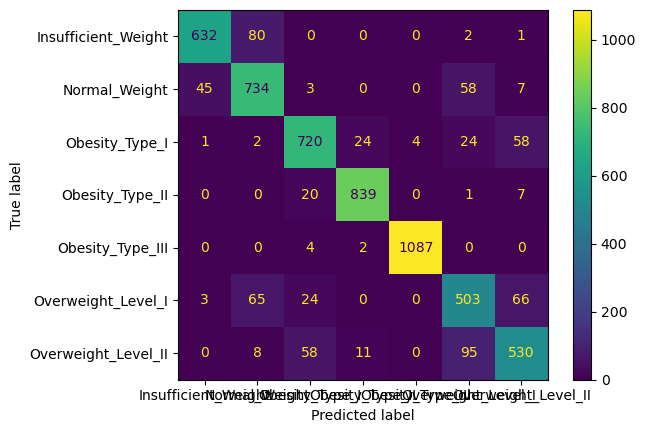

TRAIN - Accuracy: 0.9227450294443472, AUC_ROC_OVO: 0.9922252904429756, AUC_ROC_OVR: 0.9930227609945312
TEST - Accuracy: 0.8823015040223855, AUC_ROC_OVO: 0.9834840635817441, AUC_ROC_OVR: 0.9850208685962671

MLP Manual Encoding 1


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


CV time 41.811 s


mean       std
fit_time                    6.913995  0.892849
score_time                  0.050241  0.001371
test_accuracy               0.877033  0.005976
train_accuracy              0.883899  0.006572
test_roc_auc_ovo_weighted   0.983194  0.000739
train_roc_auc_ovo_weighted  0.985592  0.000925
test_roc_auc_ovr_weighted   0.984909  0.000696
train_roc_auc_ovr_weighted  0.987091  0.000809

predict time 0.017 s
Confusion matrix: 


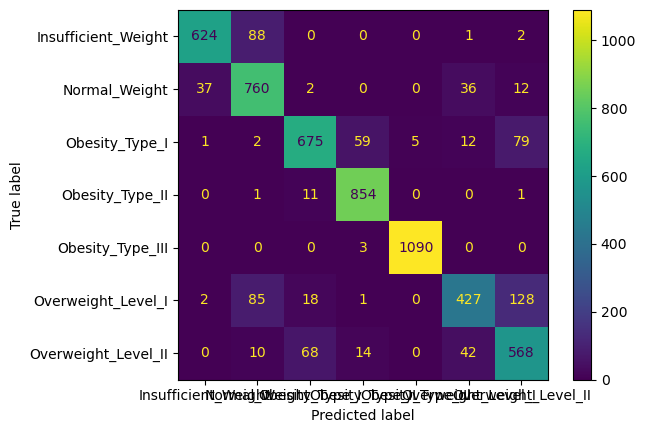

TRAIN - Accuracy: 0.8784910500845432, AUC_ROC_OVO: 0.9834449330541586, AUC_ROC_OVR: 0.9851967725397738
TEST - Accuracy: 0.8740818467995802, AUC_ROC_OVO: 0.9822385772075066, AUC_ROC_OVR: 0.9840382978583074

MLP Manual Encoding 2


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


CV time 93.708 s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


mean       std
fit_time                    14.684257  0.061178
score_time                   0.056142  0.001411
test_accuracy                0.872369  0.004240
train_accuracy               0.938327  0.001845
test_roc_auc_ovo_weighted    0.980176  0.000825
train_roc_auc_ovo_weighted   0.995364  0.000192
test_roc_auc_ovr_weighted    0.982150  0.000720
train_roc_auc_ovr_weighted   0.995853  0.000172

predict time 0.035 s
Confusion matrix: 


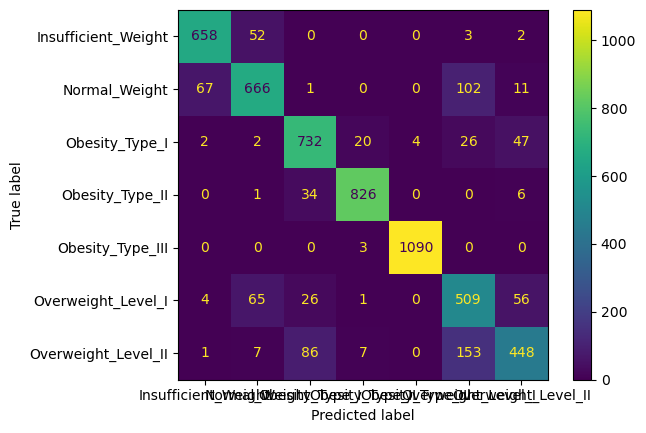

TRAIN - Accuracy: 0.9251355606087108, AUC_ROC_OVO: 0.9936664745885577, AUC_ROC_OVR: 0.9942953917691674
TEST - Accuracy: 0.8620146904512067, AUC_ROC_OVO: 0.9784234677068792, AUC_ROC_OVR: 0.9804626039726003



cv_test_mean  cv_test_std
(Ordinal)                                         0.817971     0.018471
(Ordinal Categorical Only - No Scaling)           0.872368     0.009867
(Ordinal Categorical Only - Standard Scaler)      0.883039     0.004432
(Ordinal Categorical Only - Robust Scaler)        0.885138     0.003361
(One Hot Categorical Only - No Scaling)           0.878782     0.005504
(One Hot Categorical Only - Standard Scaler)      0.881465     0.003492
(One Hot Categorical Only - Robust Scaler)        0.882630     0.004488
Manual Encoding 1                                 0.877033     0.005976
Manual Encoding 2                                 0.872369     0.004240

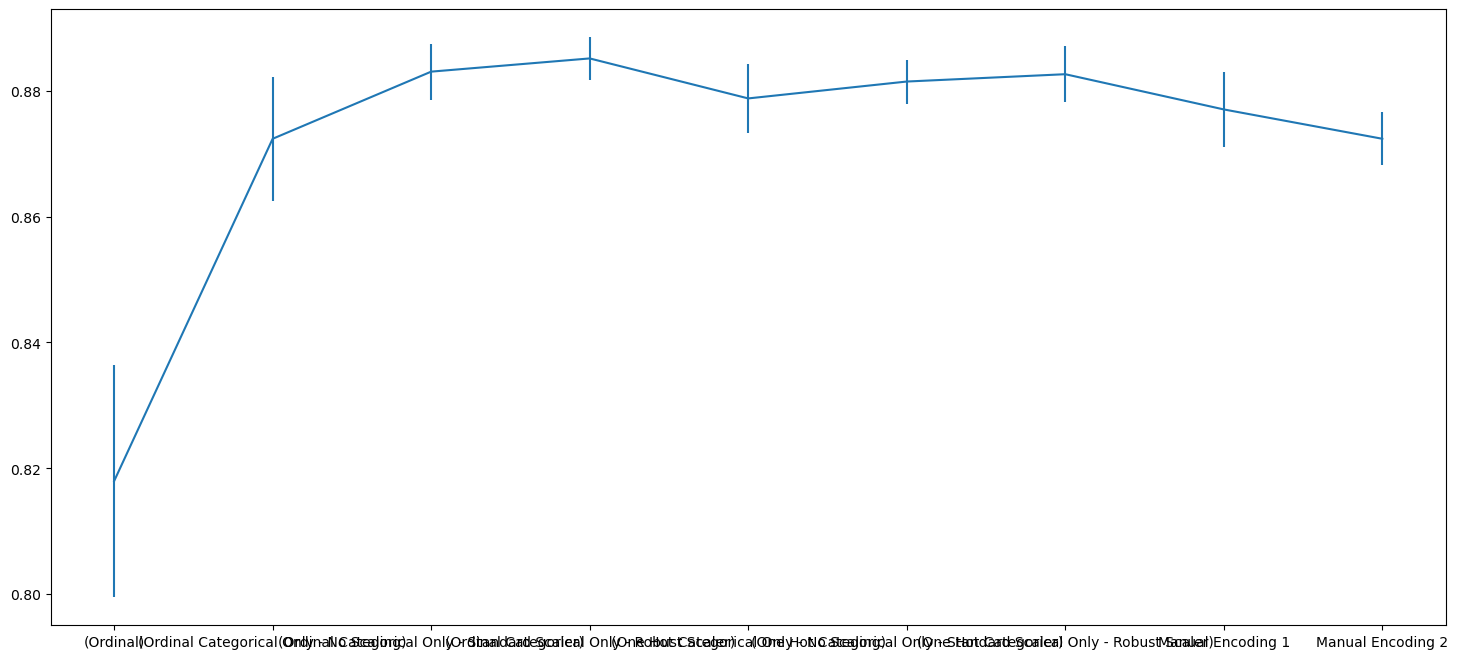

Best Preprocessing: (Ordinal Categorical Only - Standard Scaler) - Test Accuracy: 0.8898216159496327


In [40]:
# Model 3 - MLP
test = []
models = []
summaries = []
for i, name in enumerate(preprocessed):
    model = MLPClassifier(hidden_layer_sizes = (100,), solver='adam', max_iter=200, tol=1e-4, early_stopping=False, alpha=.0001)
    train_results, test_results, summary = train_and_evaluate_classifierCV(f"MLP {name}", 
                                                                            model, 
                                                                            X_train[i], 
                                                                            y_train[i], 
                                                                            X_test[i], 
                                                                            y_test[i], 
                                                                            confusion=True, 
                                                                            supress_outputs=False)
    test.append(test_results[0])
    models.append(model)
    summaries.append(summary)
    print()

cv_test_mean = [summary['mean']['test_accuracy'] for summary in summaries]
cv_test_std =  [summary['std']['test_accuracy'] for summary in summaries]
cv_results = pd.DataFrame({'cv_test_mean':cv_test_mean, 'cv_test_std':cv_test_std})
cv_results.index = preprocessed
display(cv_results)
plt.figure(figsize=(18, 8))
plt.errorbar(cv_results.index, cv_results['cv_test_mean'], yerr=cv_results['cv_test_std'])
plt.show()

test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

In [41]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# explainer = shap.KernelExplainer(best_model.predict, dataset)
# shap_values = explainer(dataset)
# print(shap_values.shape)

# for i in range(shap_values.shape[2]):
#     # summarize the effects of all the features
#     shap.plots.beeswarm(shap_values[:, :, i])
    
#     shap.plots.bar(shap_values[:, :, i])

KNN (Ordinal)
CV time 3.55 s


mean       std
fit_time                    0.011685  0.000283
score_time                  0.254414  0.089276
test_accuracy               0.837153  0.004647
train_accuracy              0.883666  0.001109
test_roc_auc_ovo_weighted   0.956392  0.001534
train_roc_auc_ovo_weighted  0.989895  0.000021
test_roc_auc_ovr_weighted   0.959566  0.001493
train_roc_auc_ovr_weighted  0.991021  0.000021

predict time 0.398 s
Confusion matrix: 


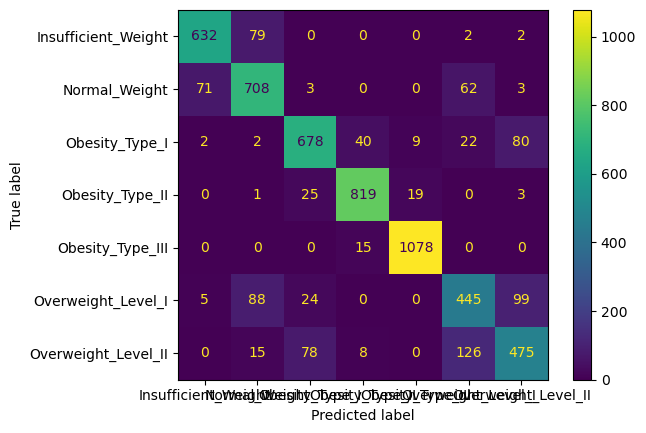

TRAIN - Accuracy: 0.8860707830447204, AUC_ROC_OVO: 0.9891975106587291, AUC_ROC_OVR: 0.9903439425893055
TEST - Accuracy: 0.8455753760055964, AUC_ROC_OVO: 0.9550866166971501, AUC_ROC_OVR: 0.9570195665378342

KNN (Ordinal Categorical Only - No Scaling)
CV time 3.348 s


mean       std
fit_time                    0.011813  0.000438
score_time                  0.214994  0.015254
test_accuracy               0.881814  0.005218
train_accuracy              0.910093  0.002501
test_roc_auc_ovo_weighted   0.966620  0.001300
train_roc_auc_ovo_weighted  0.994493  0.000185
test_roc_auc_ovr_weighted   0.968656  0.001272
train_roc_auc_ovr_weighted  0.995077  0.000166

predict time 1.541 s
Confusion matrix: 


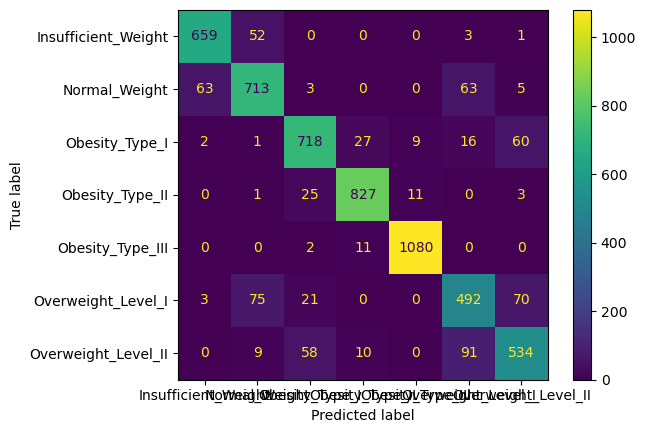

TRAIN - Accuracy: 0.9108506792606845, AUC_ROC_OVO: 0.9940814899046535, AUC_ROC_OVR: 0.9946865234126089
TEST - Accuracy: 0.878454004896817, AUC_ROC_OVO: 0.9631002937693132, AUC_ROC_OVR: 0.9642010843149096

KNN (Ordinal Categorical Only - Standard Scaler)
CV time 3.398 s


mean       std
fit_time                    0.012322  0.000446
score_time                  0.213588  0.006434
test_accuracy               0.848405  0.004826
train_accuracy              0.888097  0.000932
test_roc_auc_ovo_weighted   0.954900  0.002166
train_roc_auc_ovo_weighted  0.990543  0.000138
test_roc_auc_ovr_weighted   0.958198  0.002065
train_roc_auc_ovr_weighted  0.991620  0.000122

predict time 1.415 s
Confusion matrix: 


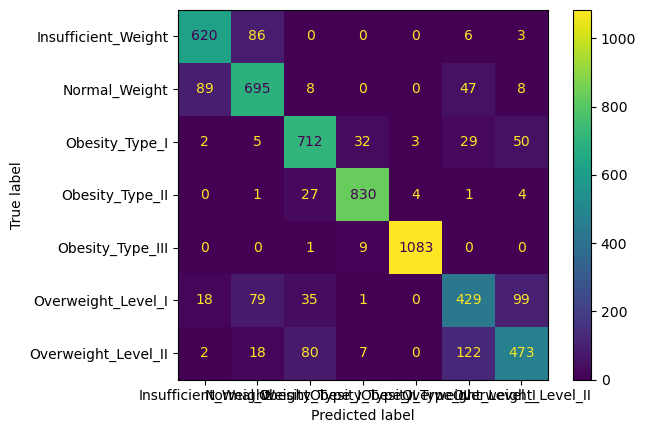

TRAIN - Accuracy: 0.8903854002682059, AUC_ROC_OVO: 0.9899148784533144, AUC_ROC_OVR: 0.9910178637712147
TEST - Accuracy: 0.8467995802728226, AUC_ROC_OVO: 0.9530663305178338, AUC_ROC_OVR: 0.9550077337385121

KNN (Ordinal Categorical Only - Robust Scaler)
CV time 3.288 s


mean       std
fit_time                    0.011743  0.000388
score_time                  0.208691  0.005222
test_accuracy               0.852836  0.002311
train_accuracy              0.890065  0.001062
test_roc_auc_ovo_weighted   0.955834  0.002507
train_roc_auc_ovo_weighted  0.991039  0.000082
test_roc_auc_ovr_weighted   0.958968  0.002403
train_roc_auc_ovr_weighted  0.992046  0.000070

predict time 1.401 s
Confusion matrix: 


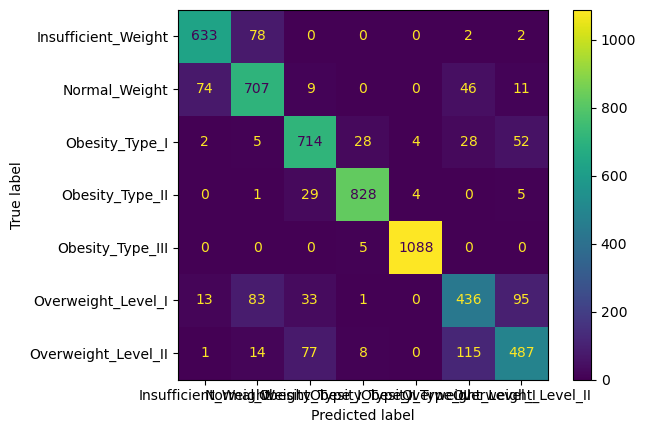

TRAIN - Accuracy: 0.891493207393155, AUC_ROC_OVO: 0.9904180238038678, AUC_ROC_OVR: 0.9914537998827243
TEST - Accuracy: 0.8557187827911857, AUC_ROC_OVO: 0.9541727285610806, AUC_ROC_OVR: 0.9560121658047764

KNN (One Hot Categorical Only - No Scaling)
CV time 3.823 s


mean       std
fit_time                    0.013844  0.000234
score_time                  0.234172  0.003194
test_accuracy               0.885196  0.005445
train_accuracy              0.912469  0.001496
test_roc_auc_ovo_weighted   0.967946  0.001221
train_roc_auc_ovo_weighted  0.994721  0.000122
test_roc_auc_ovr_weighted   0.969836  0.001244
train_roc_auc_ovr_weighted  0.995277  0.000111

predict time 1.479 s
Confusion matrix: 


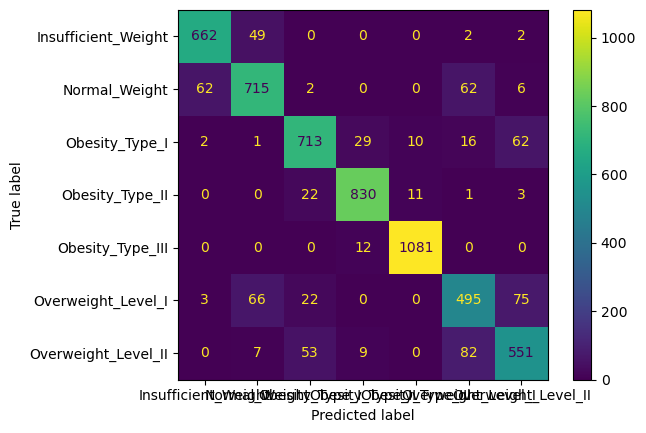

TRAIN - Accuracy: 0.9144656288263076, AUC_ROC_OVO: 0.9944287849456488, AUC_ROC_OVR: 0.9949878300633177
TEST - Accuracy: 0.8826512766701644, AUC_ROC_OVO: 0.9637740694188646, AUC_ROC_OVR: 0.9648091391478456

KNN (One Hot Categorical Only - Standard Scaler)
CV time 3.738 s


mean       std
fit_time                    0.013035  0.000228
score_time                  0.238306  0.018269
test_accuracy               0.848988  0.003697
train_accuracy              0.891449  0.001139
test_roc_auc_ovo_weighted   0.958456  0.000942
train_roc_auc_ovo_weighted  0.990864  0.000126
test_roc_auc_ovr_weighted   0.961536  0.000891
train_roc_auc_ovr_weighted  0.991898  0.000110

predict time 1.57 s
Confusion matrix: 


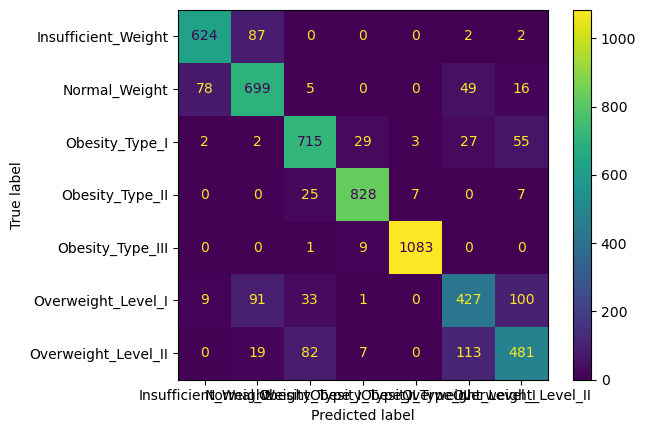

TRAIN - Accuracy: 0.8926010145181039, AUC_ROC_OVO: 0.9901824497479236, AUC_ROC_OVR: 0.991245050333215
TEST - Accuracy: 0.8494228751311648, AUC_ROC_OVO: 0.9543588119553418, AUC_ROC_OVR: 0.9562455105164512

KNN (One Hot Categorical Only - Robust Scaler)
CV time 3.729 s


mean       std
fit_time                    0.013320  0.000677
score_time                  0.227039  0.004681
test_accuracy               0.852545  0.003418
train_accuracy              0.889511  0.001231
test_roc_auc_ovo_weighted   0.956546  0.002747
train_roc_auc_ovo_weighted  0.990956  0.000117
test_roc_auc_ovr_weighted   0.959644  0.002589
train_roc_auc_ovr_weighted  0.991973  0.000102

predict time 1.468 s
Confusion matrix: 


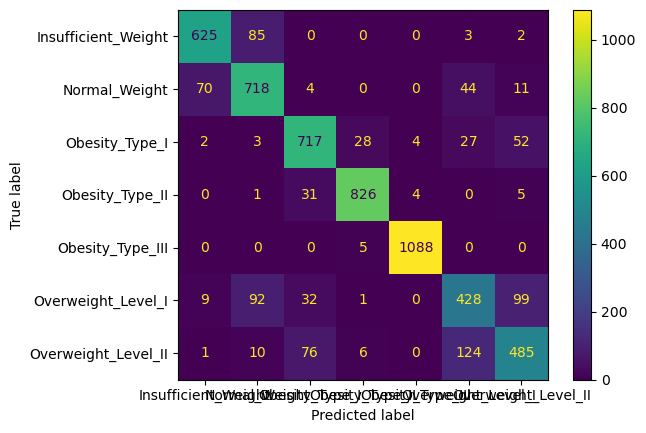

TRAIN - Accuracy: 0.8902687889918955, AUC_ROC_OVO: 0.9903134770348639, AUC_ROC_OVR: 0.9913589011758289
TEST - Accuracy: 0.8546694648478489, AUC_ROC_OVO: 0.9541617676927311, AUC_ROC_OVR: 0.9559607970545728

KNN Manual Encoding 1
CV time 3.612 s


mean       std
fit_time                    0.012750  0.000667
score_time                  0.226259  0.011560
test_accuracy               0.887470  0.005010
train_accuracy              0.913387  0.001526
test_roc_auc_ovo_weighted   0.968274  0.000845
train_roc_auc_ovo_weighted  0.994801  0.000131
test_roc_auc_ovr_weighted   0.970165  0.000805
train_roc_auc_ovr_weighted  0.995349  0.000117

predict time 1.478 s
Confusion matrix: 


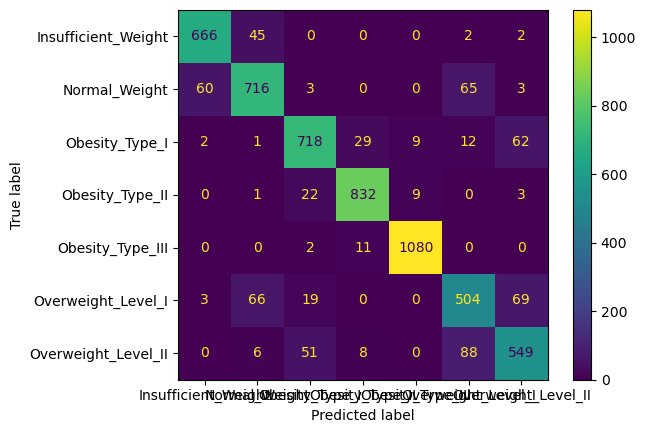

TRAIN - Accuracy: 0.9144073231881523, AUC_ROC_OVO: 0.9944371071710575, AUC_ROC_OVR: 0.9949977813747827
TEST - Accuracy: 0.8857992305001748, AUC_ROC_OVO: 0.9642756943207091, AUC_ROC_OVR: 0.9652916108403283

KNN Manual Encoding 2
CV time 6.619 s


mean       std
fit_time                    0.026042  0.001889
score_time                  0.348094  0.014676
test_accuracy               0.802344  0.004452
train_accuracy              0.859833  0.001592
test_roc_auc_ovo_weighted   0.942897  0.000730
train_roc_auc_ovo_weighted  0.985609  0.000129
test_roc_auc_ovr_weighted   0.947241  0.000653
train_roc_auc_ovr_weighted  0.987155  0.000112

predict time 2.09 s
Confusion matrix: 


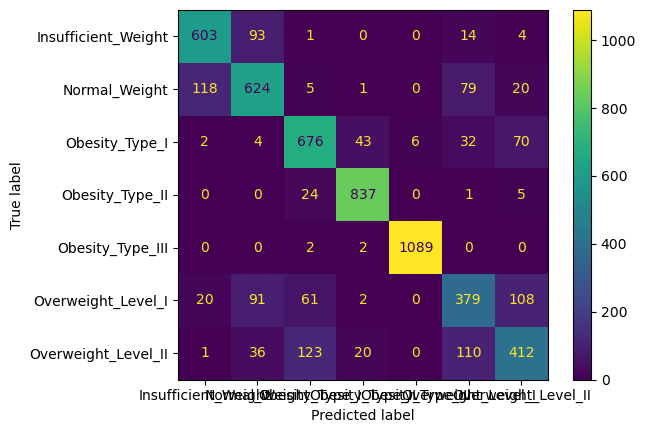

TRAIN - Accuracy: 0.8623403883155502, AUC_ROC_OVO: 0.9849711412153794, AUC_ROC_OVR: 0.9865024435584748
TEST - Accuracy: 0.8079748163693599, AUC_ROC_OVO: 0.9420109845729596, AUC_ROC_OVR: 0.9447764462873961



cv_test_mean  cv_test_std
(Ordinal)                                         0.837153     0.004647
(Ordinal Categorical Only - No Scaling)           0.881814     0.005218
(Ordinal Categorical Only - Standard Scaler)      0.848405     0.004826
(Ordinal Categorical Only - Robust Scaler)        0.852836     0.002311
(One Hot Categorical Only - No Scaling)           0.885196     0.005445
(One Hot Categorical Only - Standard Scaler)      0.848988     0.003697
(One Hot Categorical Only - Robust Scaler)        0.852545     0.003418
Manual Encoding 1                                 0.887470     0.005010
Manual Encoding 2                                 0.802344     0.004452

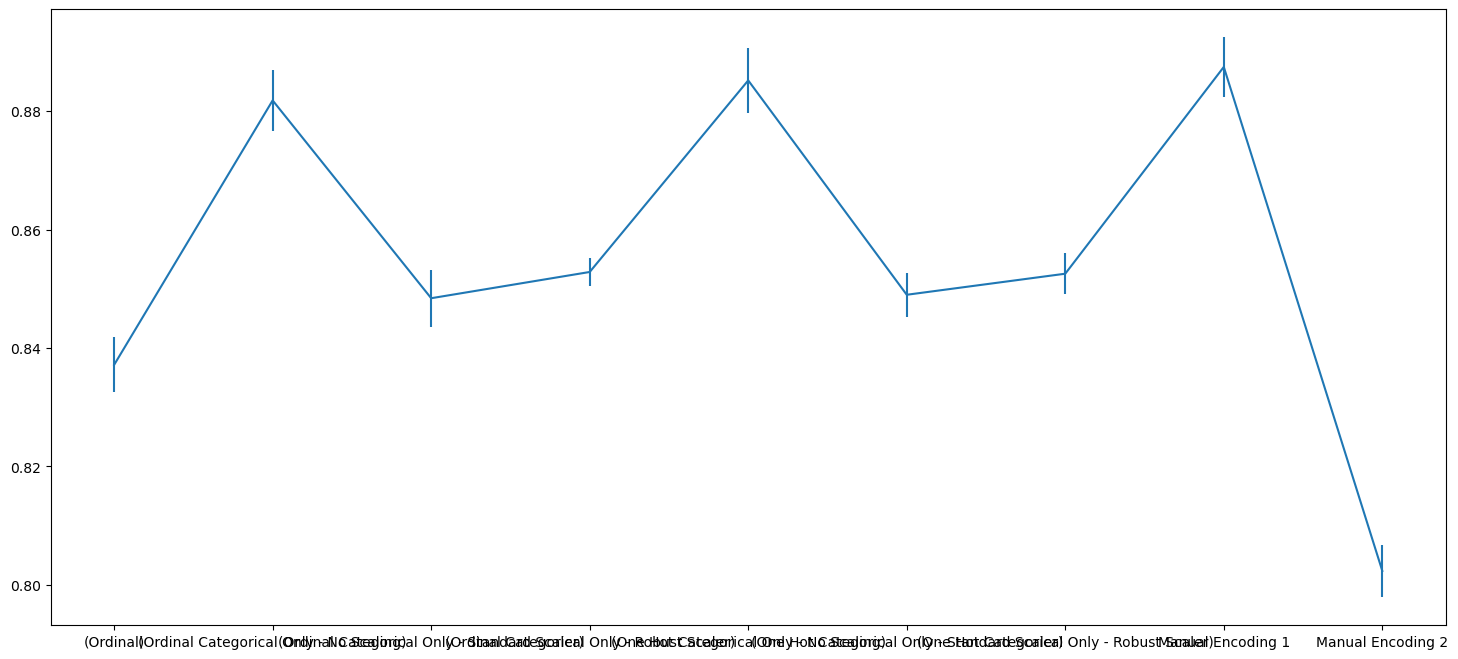

Best Preprocessing: Manual Encoding 1 - Test Accuracy: 0.8857992305001748


In [42]:
# Model 4 - KNN
test = []
models = []
summaries = []
for i, name in enumerate(preprocessed):
    model = KNeighborsClassifier()
    train_results, test_results, summary = train_and_evaluate_classifierCV(f"KNN {name}", 
                                                                            model, 
                                                                            X_train[i].values, 
                                                                            y_train[i], 
                                                                            X_test[i].values, 
                                                                            y_test[i], 
                                                                            confusion=True, 
                                                                            supress_outputs=False)
    test.append(test_results[0])
    models.append(model)
    summaries.append(summary)
    print()

cv_test_mean = [summary['mean']['test_accuracy'] for summary in summaries]
cv_test_std =  [summary['std']['test_accuracy'] for summary in summaries]
cv_results = pd.DataFrame({'cv_test_mean':cv_test_mean, 'cv_test_std':cv_test_std})
cv_results.index = preprocessed
display(cv_results)
plt.figure(figsize=(18, 8))
plt.errorbar(cv_results.index, cv_results['cv_test_mean'], yerr=cv_results['cv_test_std'])
plt.show()

test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

In [43]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# explainer = shap.Explainer(best_model)
# shap_values = explainer(dataset.values)
# print(shap_values.shape)

# for i in range(shap_values.shape[2]):
#     # summarize the effects of all the features
#     shap.plots.beeswarm(shap_values[:, :, i])
    
#     shap.plots.bar(shap_values[:, :, i])

SVM (Ordinal)
CV time 192.439 s


mean       std
fit_time                    11.669685  0.096517
score_time                   6.229951  3.972566
test_accuracy                0.867413  0.003598
train_accuracy               0.871042  0.001422
test_roc_auc_ovo_weighted    0.979707  0.001096
train_roc_auc_ovo_weighted   0.980861  0.000282
test_roc_auc_ovr_weighted    0.981784  0.000974
train_roc_auc_ovr_weighted   0.982835  0.000249

predict time 17.003 s
Confusion matrix: 


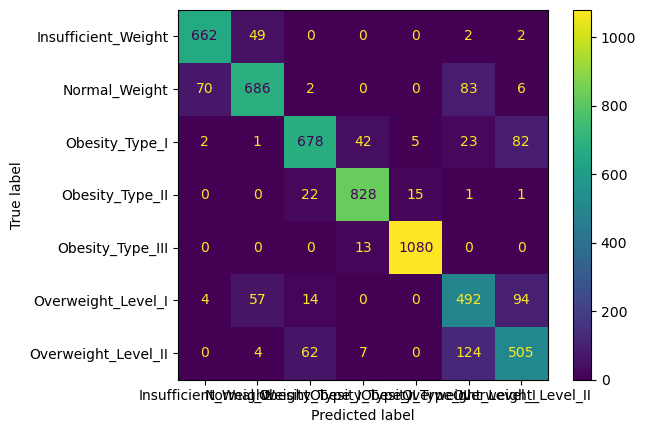

TRAIN - Accuracy: 0.8711445396769868, AUC_ROC_OVO: 0.9789858156684716, AUC_ROC_OVR: 0.9811187963129354
TEST - Accuracy: 0.8623644630989856, AUC_ROC_OVO: 0.9767761192830451, AUC_ROC_OVR: 0.9790733015692761

SVM (Ordinal Categorical Only - No Scaling)
CV time 279.265 s


mean       std
fit_time                    17.635816  0.109443
score_time                   8.867529  5.649414
test_accuracy                0.839251  0.008071
train_accuracy               0.839659  0.001808
test_roc_auc_ovo_weighted    0.974107  0.001269
train_roc_auc_ovo_weighted   0.974339  0.000299
test_roc_auc_ovr_weighted    0.976402  0.001203
train_roc_auc_ovr_weighted   0.976611  0.000282

predict time 138.184 s
Confusion matrix: 


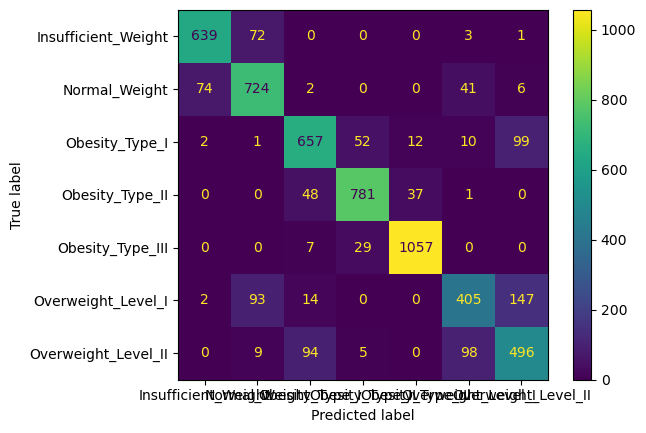

TRAIN - Accuracy: 0.8425747769809341, AUC_ROC_OVO: 0.9728656173076018, AUC_ROC_OVR: 0.9753248436804445
TEST - Accuracy: 0.8322840153899965, AUC_ROC_OVO: 0.9712079179491627, AUC_ROC_OVR: 0.9737495521657458

SVM (Ordinal Categorical Only - Standard Scaler)
CV time 210.152 s


mean       std
fit_time                    11.856239  0.046987
score_time                   5.352523  3.429553
test_accuracy                0.877558  0.004972
train_accuracy               0.885677  0.001367
test_roc_auc_ovo_weighted    0.983693  0.000874
train_roc_auc_ovo_weighted   0.986276  0.000176
test_roc_auc_ovr_weighted    0.985403  0.000778
train_roc_auc_ovr_weighted   0.987723  0.000156

predict time 14.357 s
Confusion matrix: 


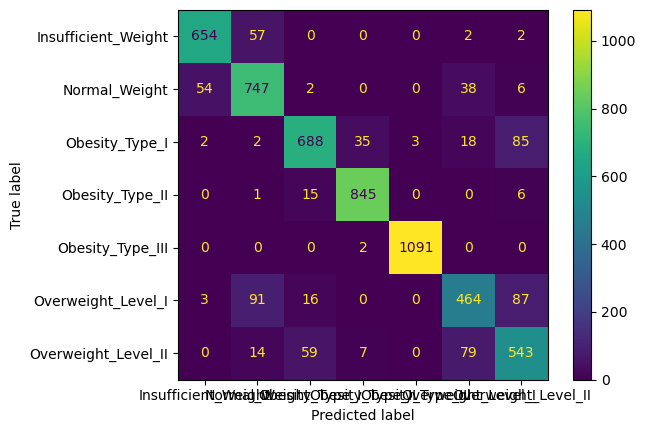

TRAIN - Accuracy: 0.88595417176841, AUC_ROC_OVO: 0.9850043248578143, AUC_ROC_OVR: 0.9865460555788286
TEST - Accuracy: 0.8800279818118223, AUC_ROC_OVO: 0.9822812432887564, AUC_ROC_OVR: 0.9840479444252793

SVM (Ordinal Categorical Only - Robust Scaler)
CV time 177.808 s


mean       std
fit_time                    12.733480  0.046351
score_time                   3.827002  0.012822
test_accuracy                0.871261  0.003668
train_accuracy               0.877529  0.001362
test_roc_auc_ovo_weighted    0.982380  0.000804
train_roc_auc_ovo_weighted   0.984510  0.000205
test_roc_auc_ovr_weighted    0.984240  0.000718
train_roc_auc_ovr_weighted   0.986149  0.000182

predict time 15.222 s
Confusion matrix: 


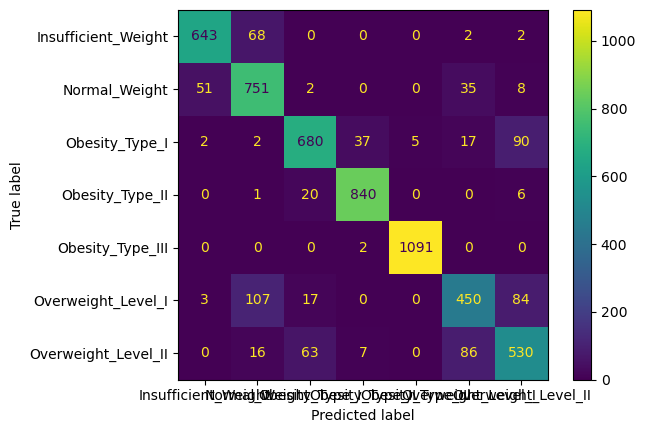

TRAIN - Accuracy: 0.8793073290187161, AUC_ROC_OVO: 0.9832348924463417, AUC_ROC_OVR: 0.9849588040170106
TEST - Accuracy: 0.8718083245890171, AUC_ROC_OVO: 0.9811192747147898, AUC_ROC_OVR: 0.9830032724725015

SVM (One Hot Categorical Only - No Scaling)
CV time 307.323 s


mean       std
fit_time                    20.948311  0.082734
score_time                   6.828921  0.028176
test_accuracy                0.832021  0.007807
train_accuracy               0.832707  0.002254
test_roc_auc_ovo_weighted    0.973068  0.001367
train_roc_auc_ovo_weighted   0.973280  0.000373
test_roc_auc_ovr_weighted    0.975403  0.001305
train_roc_auc_ovr_weighted   0.975595  0.000350

predict time 27.272 s
Confusion matrix: 


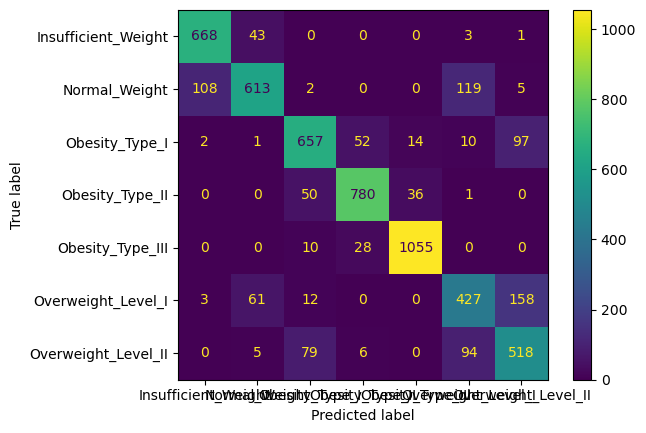

TRAIN - Accuracy: 0.8370357413561892, AUC_ROC_OVO: 0.9721971524733958, AUC_ROC_OVR: 0.9746356165296681
TEST - Accuracy: 0.8251136761105281, AUC_ROC_OVO: 0.9706065984279371, AUC_ROC_OVR: 0.9731026138158152

SVM (One Hot Categorical Only - Standard Scaler)
CV time 171.853 s


mean       std
fit_time                    12.570517  0.052030
score_time                   3.637190  0.034489
test_accuracy                0.885371  0.005059
train_accuracy               0.902251  0.001799
test_roc_auc_ovo_weighted    0.985301  0.000889
train_roc_auc_ovo_weighted   0.989382  0.000139
test_roc_auc_ovr_weighted    0.986822  0.000783
train_roc_auc_ovr_weighted   0.990495  0.000125

predict time 14.251 s
Confusion matrix: 


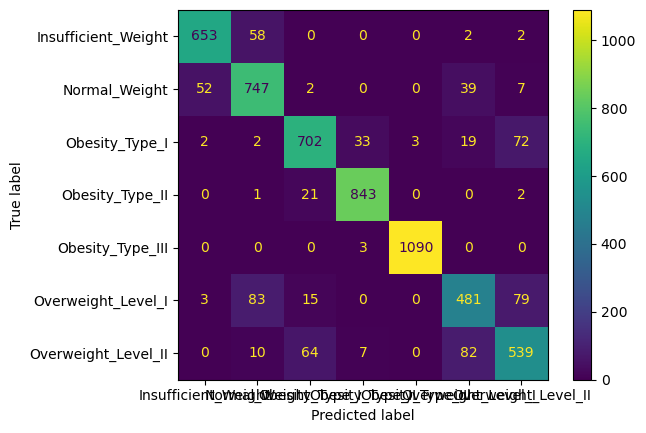

TRAIN - Accuracy: 0.9022214448137135, AUC_ROC_OVO: 0.9882515958268718, AUC_ROC_OVR: 0.9894486307196265
TEST - Accuracy: 0.8840503672612802, AUC_ROC_OVO: 0.984096290085189, AUC_ROC_OVR: 0.9856692729557116

SVM (One Hot Categorical Only - Robust Scaler)
CV time 171.759 s


mean       std
fit_time                    12.561540  0.112152
score_time                   3.620334  0.022406
test_accuracy                0.880823  0.005878
train_accuracy               0.896362  0.001274
test_roc_auc_ovo_weighted    0.984796  0.000833
train_roc_auc_ovo_weighted   0.988647  0.000146
test_roc_auc_ovr_weighted    0.986373  0.000735
train_roc_auc_ovr_weighted   0.989841  0.000131

predict time 14.48 s
Confusion matrix: 


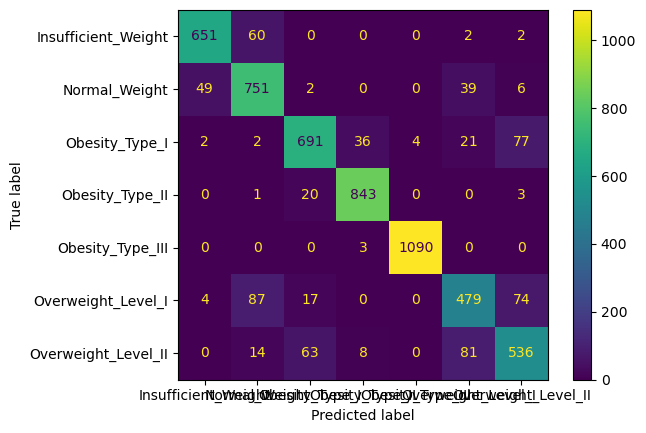

TRAIN - Accuracy: 0.8972654655705207, AUC_ROC_OVO: 0.9875091763240071, AUC_ROC_OVR: 0.988787132650162
TEST - Accuracy: 0.8816019587268276, AUC_ROC_OVO: 0.9836299622398771, AUC_ROC_OVR: 0.9852525753429625

SVM Manual Encoding 1
CV time 287.609 s


mean       std
fit_time                    19.245004  0.032558
score_time                   6.490906  0.021143
test_accuracy                0.833187  0.007487
train_accuracy               0.833683  0.002288
test_roc_auc_ovo_weighted    0.973753  0.001276
train_roc_auc_ovo_weighted   0.974004  0.000406
test_roc_auc_ovr_weighted    0.976116  0.001210
train_roc_auc_ovr_weighted   0.976343  0.000376

predict time 25.974 s
Confusion matrix: 


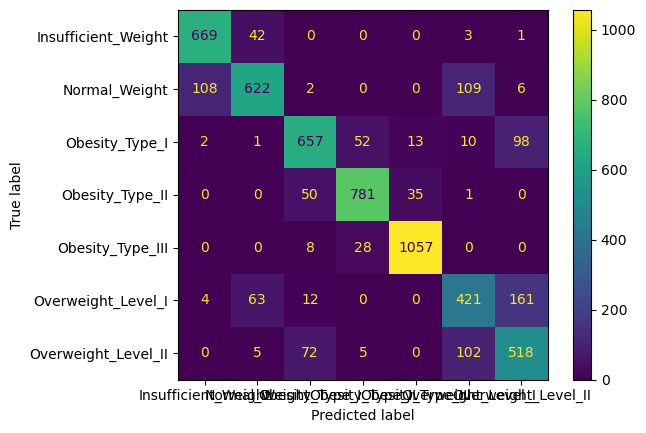

TRAIN - Accuracy: 0.8376771033758964, AUC_ROC_OVO: 0.9728278247931832, AUC_ROC_OVR: 0.9753024694969349
TEST - Accuracy: 0.8263378803777545, AUC_ROC_OVO: 0.9713515812906414, AUC_ROC_OVR: 0.9738849396866109

SVM Manual Encoding 2
CV time 370.099 s


mean       std
fit_time                    27.928729  0.133881
score_time                   7.439207  0.054818
test_accuracy                0.880940  0.006312
train_accuracy               0.899787  0.001213
test_roc_auc_ovo_weighted    0.983648  0.000820
train_roc_auc_ovo_weighted   0.987882  0.000175
test_roc_auc_ovr_weighted    0.985363  0.000727
train_roc_auc_ovr_weighted   0.989162  0.000153

predict time 30.142 s
Confusion matrix: 


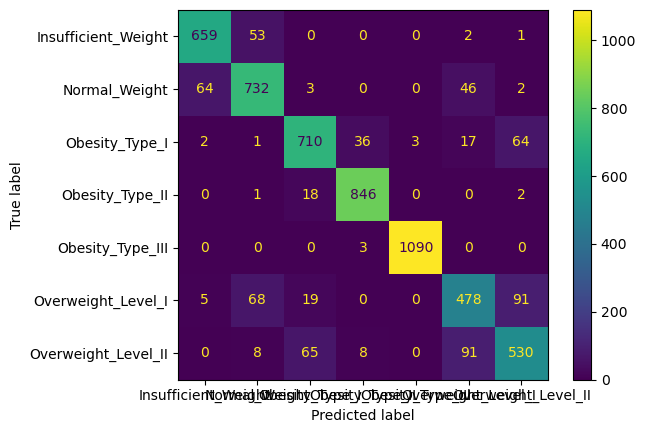

TRAIN - Accuracy: 0.899597691096729, AUC_ROC_OVO: 0.9865182299609435, AUC_ROC_OVR: 0.9879111868995263
TEST - Accuracy: 0.8823015040223855, AUC_ROC_OVO: 0.9823110186370938, AUC_ROC_OVR: 0.9841116074840365



cv_test_mean  cv_test_std
(Ordinal)                                         0.867413     0.003598
(Ordinal Categorical Only - No Scaling)           0.839251     0.008071
(Ordinal Categorical Only - Standard Scaler)      0.877558     0.004972
(Ordinal Categorical Only - Robust Scaler)        0.871261     0.003668
(One Hot Categorical Only - No Scaling)           0.832021     0.007807
(One Hot Categorical Only - Standard Scaler)      0.885371     0.005059
(One Hot Categorical Only - Robust Scaler)        0.880823     0.005878
Manual Encoding 1                                 0.833187     0.007487
Manual Encoding 2                                 0.880940     0.006312

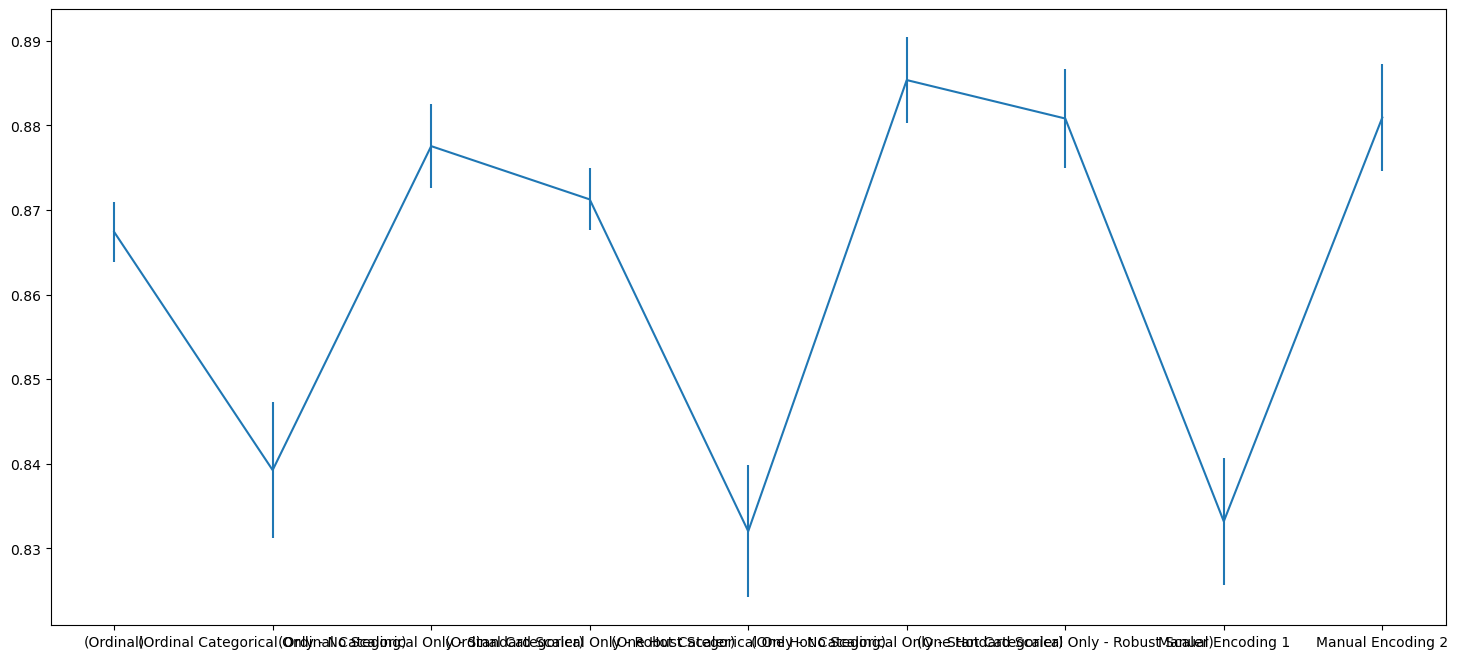

Best Preprocessing: (One Hot Categorical Only - Standard Scaler) - Test Accuracy: 0.8840503672612802


In [44]:
# Model 5 - SVM
test = []
models = []
summaries = []
for i, name in enumerate(preprocessed):
    model = SVC(probability=True)
    train_results, test_results, summary = train_and_evaluate_classifierCV(f"SVM {name}", 
                                                                    model, 
                                                                    X_train[i], 
                                                                    y_train[i], 
                                                                    X_test[i], 
                                                                    y_test[i], 
                                                                    confusion=True, 
                                                                    supress_outputs=False)
    test.append(test_results[0])
    models.append(model)
    summaries.append(summary)
    print()

cv_test_mean = [summary['mean']['test_accuracy'] for summary in summaries]
cv_test_std =  [summary['std']['test_accuracy'] for summary in summaries]
cv_results = pd.DataFrame({'cv_test_mean':cv_test_mean, 'cv_test_std':cv_test_std})
cv_results.index = preprocessed
display(cv_results)
plt.figure(figsize=(18, 8))
plt.errorbar(cv_results.index, cv_results['cv_test_mean'], yerr=cv_results['cv_test_std'])
plt.show()

test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

In [45]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# explainer = shap.KernelExplainer(best_model.predict, dataset)
# shap_values = explainer(dataset)
# print(shap_values.shape)

# for i in range(shap_values.shape[2]):
#     # summarize the effects of all the features
#     shap.plots.beeswarm(shap_values[:, :, i])
    
#     shap.plots.bar(shap_values[:, :, i])

LDA (Ordinal)
CV time 1.138 s


mean       std
fit_time                    0.054081  0.001039
score_time                  0.047331  0.001730
test_accuracy               0.856743  0.004137
train_accuracy              0.858769  0.001441
test_roc_auc_ovo_weighted   0.978431  0.001865
train_roc_auc_ovo_weighted  0.978740  0.000420
test_roc_auc_ovr_weighted   0.980574  0.001713
train_roc_auc_ovr_weighted  0.980849  0.000382

predict time 0.004 s
Confusion matrix: 


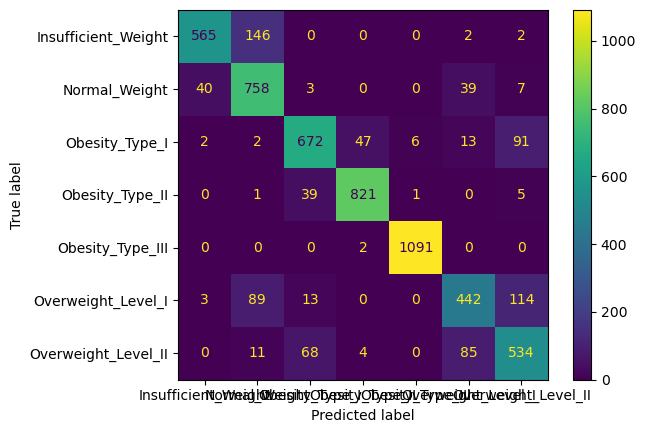

TRAIN - Accuracy: 0.8589003556643927, AUC_ROC_OVO: 0.9766599357987951, AUC_ROC_OVR: 0.9789725919891648
TEST - Accuracy: 0.853969919552291, AUC_ROC_OVO: 0.9760133437012287, AUC_ROC_OVR: 0.9784156142980871

LDA (Ordinal Categorical Only - No Scaling)
CV time 1.109 s


mean       std
fit_time                    0.052992  0.001049
score_time                  0.046444  0.000576
test_accuracy               0.838901  0.004160
train_accuracy              0.839018  0.001047
test_roc_auc_ovo_weighted   0.976058  0.001868
train_roc_auc_ovo_weighted  0.976425  0.000348
test_roc_auc_ovr_weighted   0.978432  0.001721
train_roc_auc_ovr_weighted  0.978759  0.000317

predict time 0.005 s
Confusion matrix: 


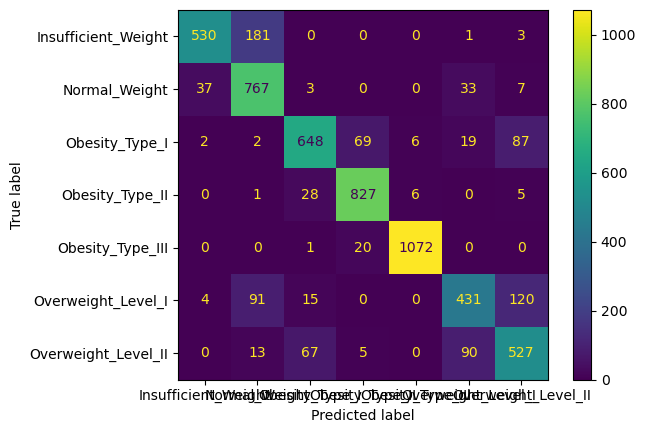

TRAIN - Accuracy: 0.8391347443297766, AUC_ROC_OVO: 0.9741161224212873, AUC_ROC_OVR: 0.9766907048209231
TEST - Accuracy: 0.8398041273172437, AUC_ROC_OVO: 0.9736958769372167, AUC_ROC_OVR: 0.9762982329872388

LDA (Ordinal Categorical Only - Standard Scaler)
CV time 1.108 s


mean       std
fit_time                    0.052612  0.000408
score_time                  0.046865  0.002226
test_accuracy               0.838843  0.004081
train_accuracy              0.839047  0.001087
test_roc_auc_ovo_weighted   0.976061  0.001869
train_roc_auc_ovo_weighted  0.976427  0.000348
test_roc_auc_ovr_weighted   0.978435  0.001721
train_roc_auc_ovr_weighted  0.978761  0.000317

predict time 0.005 s
Confusion matrix: 


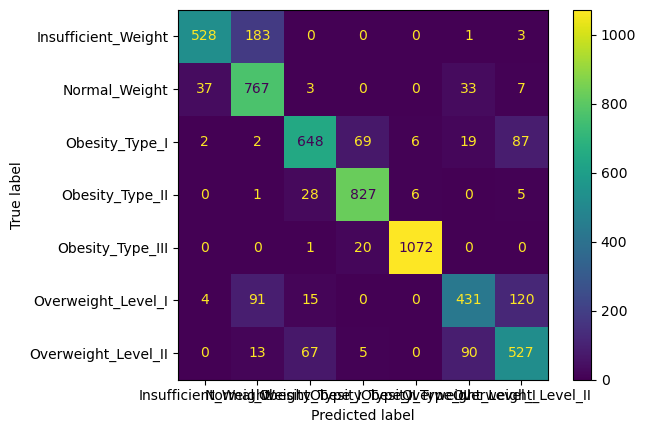

TRAIN - Accuracy: 0.838959827415311, AUC_ROC_OVO: 0.9741183025368798, AUC_ROC_OVR: 0.9766926338245675
TEST - Accuracy: 0.8394543546694648, AUC_ROC_OVO: 0.9736992299285618, AUC_ROC_OVR: 0.9763013652580218

LDA (Ordinal Categorical Only - Robust Scaler)
CV time 1.1 s


mean       std
fit_time                    0.051778  0.000653
score_time                  0.046105  0.000890
test_accuracy               0.838843  0.004110
train_accuracy              0.839018  0.001036
test_roc_auc_ovo_weighted   0.976060  0.001869
train_roc_auc_ovo_weighted  0.976426  0.000348
test_roc_auc_ovr_weighted   0.978434  0.001721
train_roc_auc_ovr_weighted  0.978760  0.000317

predict time 0.005 s
Confusion matrix: 


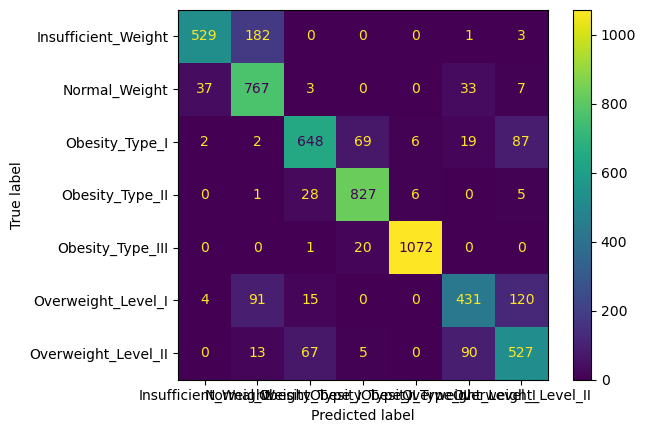

TRAIN - Accuracy: 0.8391347443297766, AUC_ROC_OVO: 0.9741179600897363, AUC_ROC_OVR: 0.9766923703253224
TEST - Accuracy: 0.8396292409933543, AUC_ROC_OVO: 0.9736969739025516, AUC_ROC_OVR: 0.9762992426040684

LDA (One Hot Categorical Only - No Scaling)
CV time 1.393 s


mean       std
fit_time                    0.094945  0.009293
score_time                  0.047648  0.000793
test_accuracy               0.813246  0.008803
train_accuracy              0.814617  0.001454
test_roc_auc_ovo_weighted   0.973117  0.001913
train_roc_auc_ovo_weighted  0.973667  0.000437
test_roc_auc_ovr_weighted   0.975530  0.001751
train_roc_auc_ovr_weighted  0.976029  0.000388

predict time 0.009 s
Confusion matrix: 


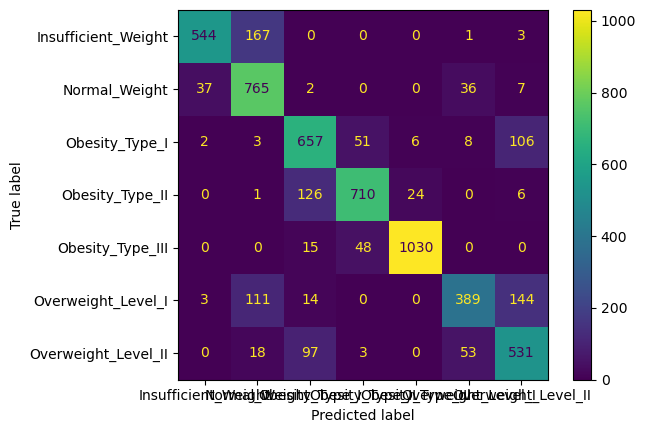

TRAIN - Accuracy: 0.814471459390123, AUC_ROC_OVO: 0.971269694242933, AUC_ROC_OVR: 0.973859296407403
TEST - Accuracy: 0.8090241343126967, AUC_ROC_OVO: 0.9704242499488351, AUC_ROC_OVR: 0.9731388890157529

LDA (One Hot Categorical Only - Standard Scaler)
CV time 1.391 s


mean       std
fit_time                    0.096902  0.008403
score_time                  0.046982  0.000491
test_accuracy               0.813305  0.008876
train_accuracy              0.814632  0.001482
test_roc_auc_ovo_weighted   0.973117  0.001912
train_roc_auc_ovo_weighted  0.973666  0.000437
test_roc_auc_ovr_weighted   0.975530  0.001750
train_roc_auc_ovr_weighted  0.976028  0.000388

predict time 0.008 s
Confusion matrix: 


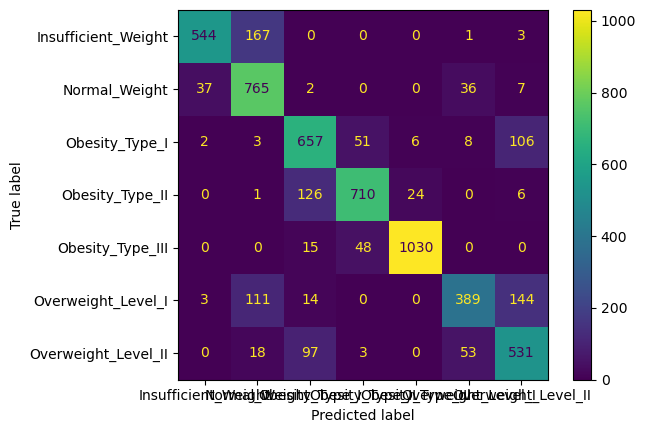

TRAIN - Accuracy: 0.814471459390123, AUC_ROC_OVO: 0.9712692632818741, AUC_ROC_OVR: 0.9738583722380182
TEST - Accuracy: 0.8090241343126967, AUC_ROC_OVO: 0.9704229843581005, AUC_ROC_OVR: 0.9731373444586099

LDA (One Hot Categorical Only - Robust Scaler)
CV time 1.364 s


mean       std
fit_time                    0.091431  0.002354
score_time                  0.046725  0.000295
test_accuracy               0.813246  0.008803
train_accuracy              0.814617  0.001466
test_roc_auc_ovo_weighted   0.973117  0.001913
train_roc_auc_ovo_weighted  0.973666  0.000437
test_roc_auc_ovr_weighted   0.975530  0.001751
train_roc_auc_ovr_weighted  0.976029  0.000388

predict time 0.008 s
Confusion matrix: 


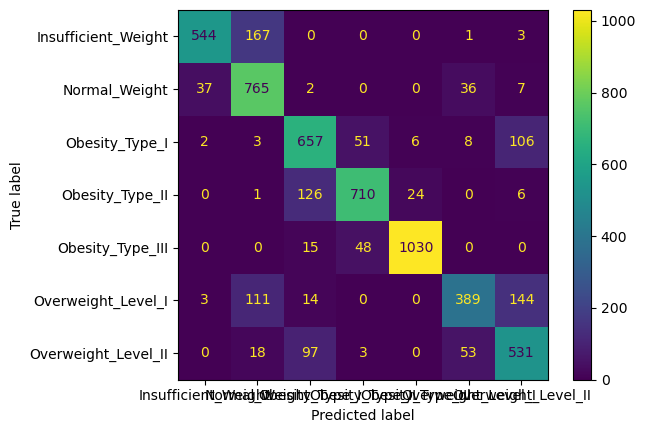

TRAIN - Accuracy: 0.814471459390123, AUC_ROC_OVO: 0.9712695866257609, AUC_ROC_OVR: 0.9738590845375112
TEST - Accuracy: 0.8090241343126967, AUC_ROC_OVO: 0.9704238293038808, AUC_ROC_OVR: 0.9731386250398858

LDA Manual Encoding 1
CV time 1.298 s


mean       std
fit_time                    0.085030  0.016158
score_time                  0.046342  0.000666
test_accuracy               0.819777  0.009459
train_accuracy              0.820958  0.001620
test_roc_auc_ovo_weighted   0.971134  0.002242
train_roc_auc_ovo_weighted  0.971583  0.000445
test_roc_auc_ovr_weighted   0.973748  0.002051
train_roc_auc_ovr_weighted  0.974149  0.000401

predict time 0.007 s
Confusion matrix: 


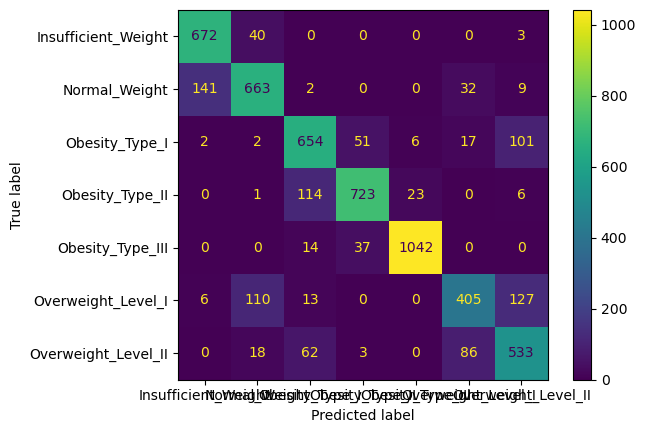

TRAIN - Accuracy: 0.8205352457582649, AUC_ROC_OVO: 0.9690273483426168, AUC_ROC_OVR: 0.9718489310854477
TEST - Accuracy: 0.8205666316894019, AUC_ROC_OVO: 0.9690097037224216, AUC_ROC_OVR: 0.9718140074591329

LDA Manual Encoding 2
CV time 3.049 s


mean       std
fit_time                    0.338433  0.004881
score_time                  0.052872  0.000696
test_accuracy               0.852195  0.006542
train_accuracy              0.856918  0.001204
test_roc_auc_ovo_weighted   0.976065  0.001093
train_roc_auc_ovo_weighted  0.977507  0.000260
test_roc_auc_ovr_weighted   0.978559  0.000989
train_roc_auc_ovr_weighted  0.979851  0.000237

predict time 0.022 s
Confusion matrix: 


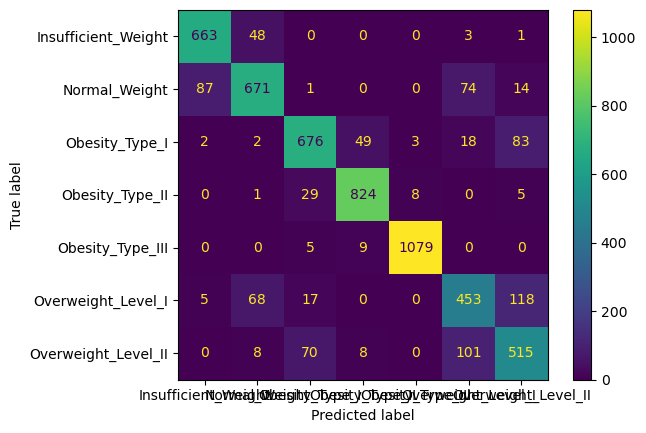

TRAIN - Accuracy: 0.8558101568421667, AUC_ROC_OVO: 0.9750822740818266, AUC_ROC_OVR: 0.9775702821914155
TEST - Accuracy: 0.853620146904512, AUC_ROC_OVO: 0.9735093831929809, AUC_ROC_OVR: 0.9761294079301425



cv_test_mean  cv_test_std
(Ordinal)                                         0.856743     0.004137
(Ordinal Categorical Only - No Scaling)           0.838901     0.004160
(Ordinal Categorical Only - Standard Scaler)      0.838843     0.004081
(Ordinal Categorical Only - Robust Scaler)        0.838843     0.004110
(One Hot Categorical Only - No Scaling)           0.813246     0.008803
(One Hot Categorical Only - Standard Scaler)      0.813305     0.008876
(One Hot Categorical Only - Robust Scaler)        0.813246     0.008803
Manual Encoding 1                                 0.819777     0.009459
Manual Encoding 2                                 0.852195     0.006542

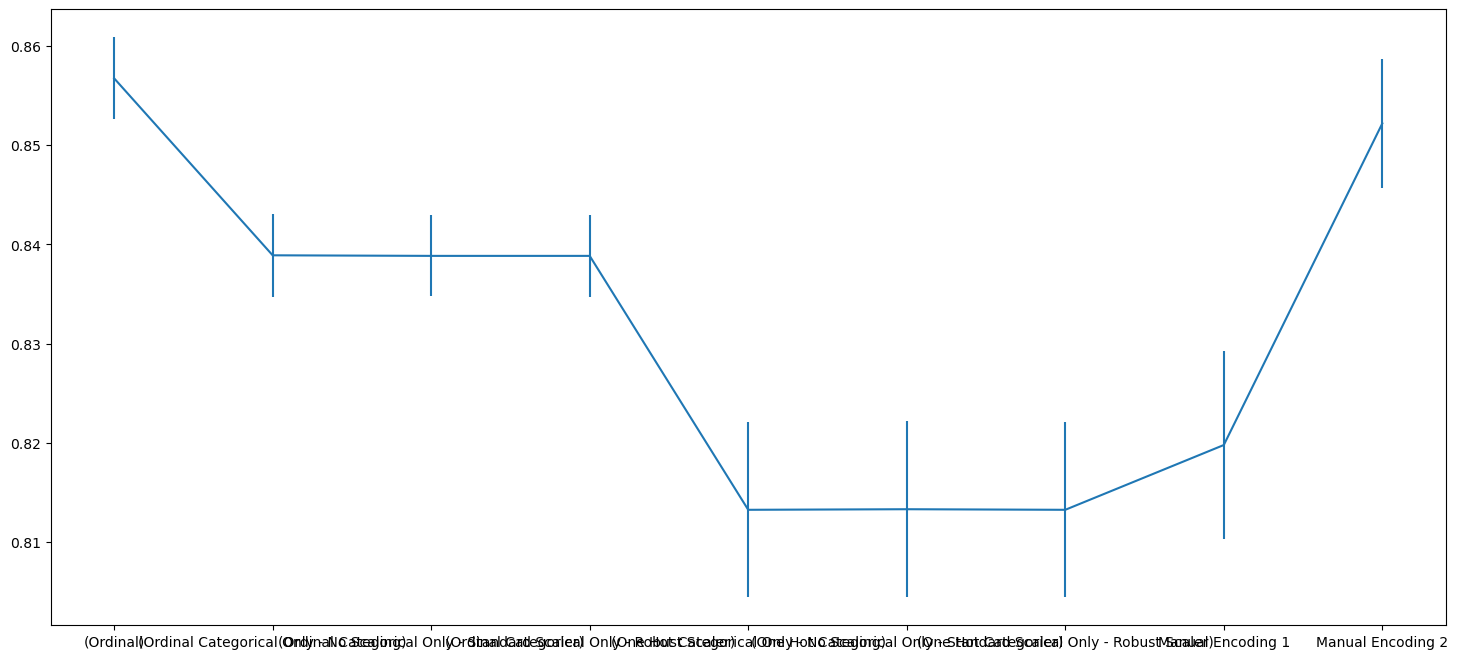

Best Preprocessing: (Ordinal) - Test Accuracy: 0.853969919552291


In [46]:
# Model 6a - LDA
test = []
models = []
summaries = []
for i, name in enumerate(preprocessed):
    model = LinearDiscriminantAnalysis()
    if sci.sparse.issparse(X_train[i]) == True:
        train_results, test_results, summary = train_and_evaluate_classifierCV(f"LDA {name}", 
                                                                                model, 
                                                                                X_train[i].to_records(), 
                                                                                y_train[i], 
                                                                                X_test[i], 
                                                                                y_test[i], 
                                                                                confusion=True, 
                                                                                supress_outputs=False)
    else:
        train_results, test_results, summary = train_and_evaluate_classifierCV(f"LDA {name}", 
                                                                                model, 
                                                                                X_train[i], 
                                                                                y_train[i], 
                                                                                X_test[i], 
                                                                                y_test[i], 
                                                                                confusion=True, 
                                                                                supress_outputs=False)
    test.append(test_results[0])
    models.append(model)
    summaries.append(summary)
    print()

cv_test_mean = [summary['mean']['test_accuracy'] for summary in summaries]
cv_test_std =  [summary['std']['test_accuracy'] for summary in summaries]
cv_results = pd.DataFrame({'cv_test_mean':cv_test_mean, 'cv_test_std':cv_test_std})
cv_results.index = preprocessed
display(cv_results)
plt.figure(figsize=(18, 8))
plt.errorbar(cv_results.index, cv_results['cv_test_mean'], yerr=cv_results['cv_test_std'])
plt.show()

test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

(17151, 21, 7)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


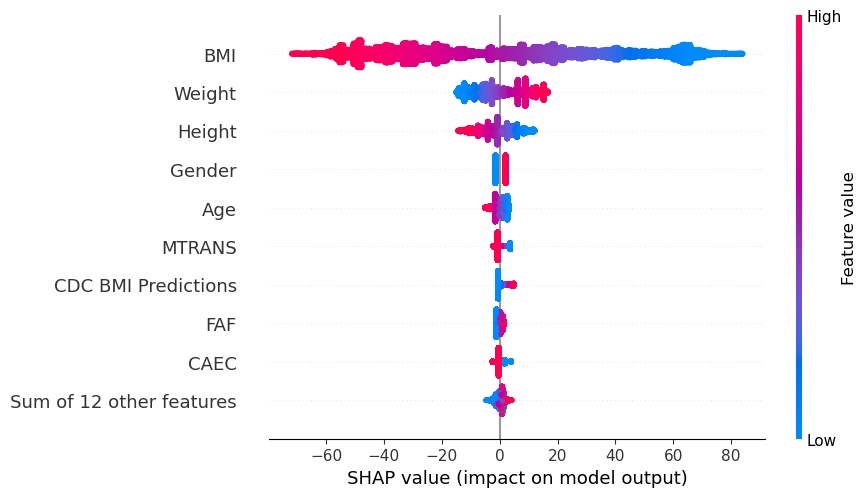

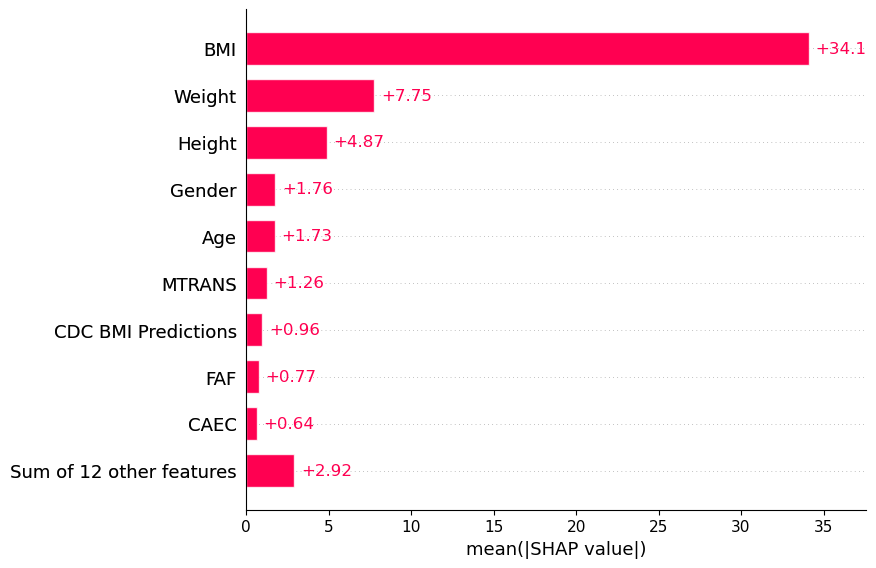

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


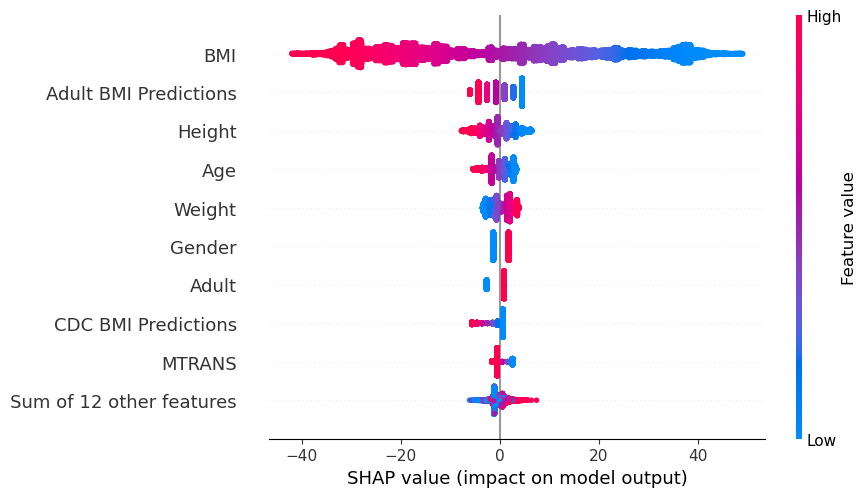

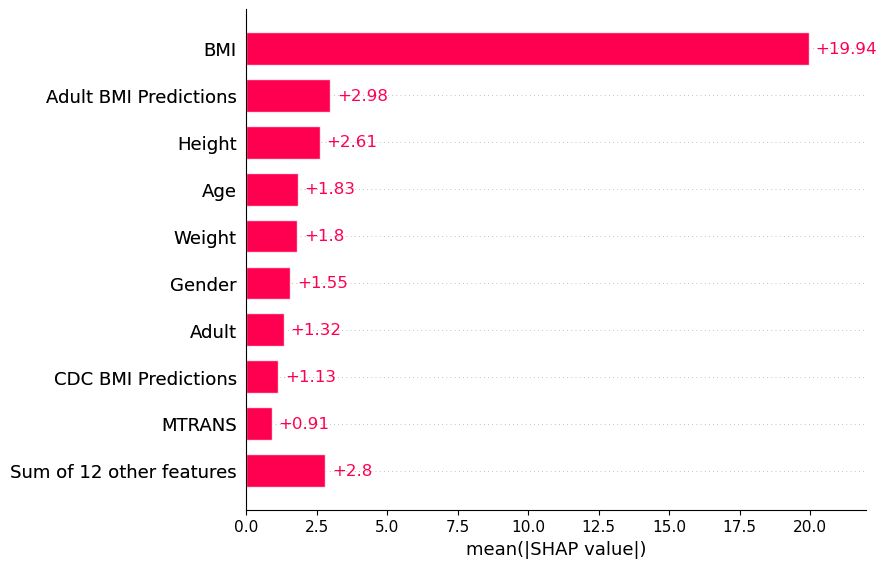

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


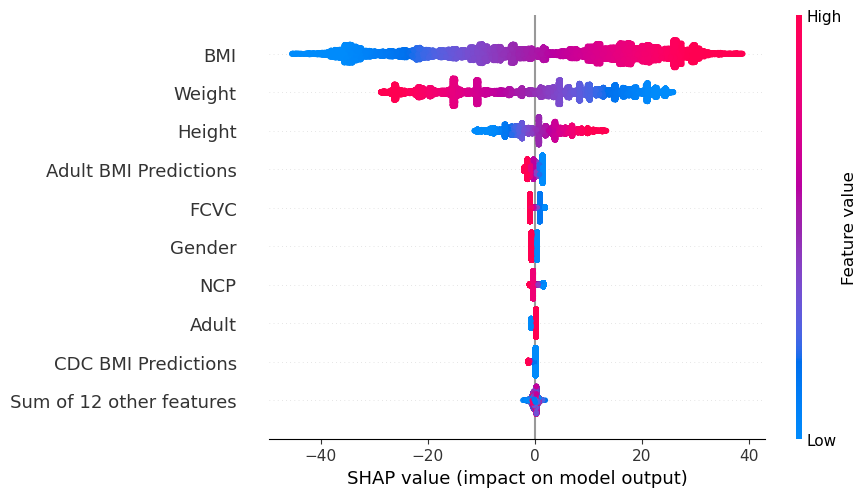

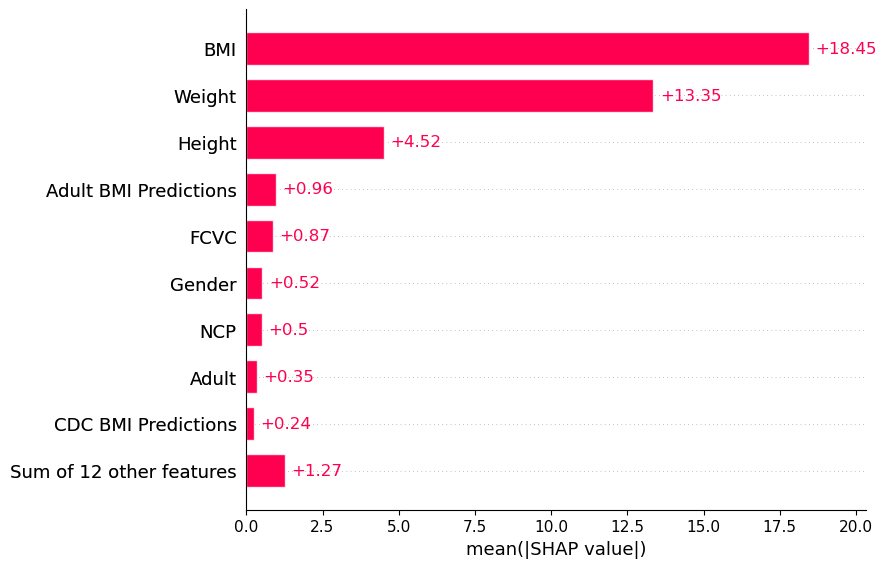

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


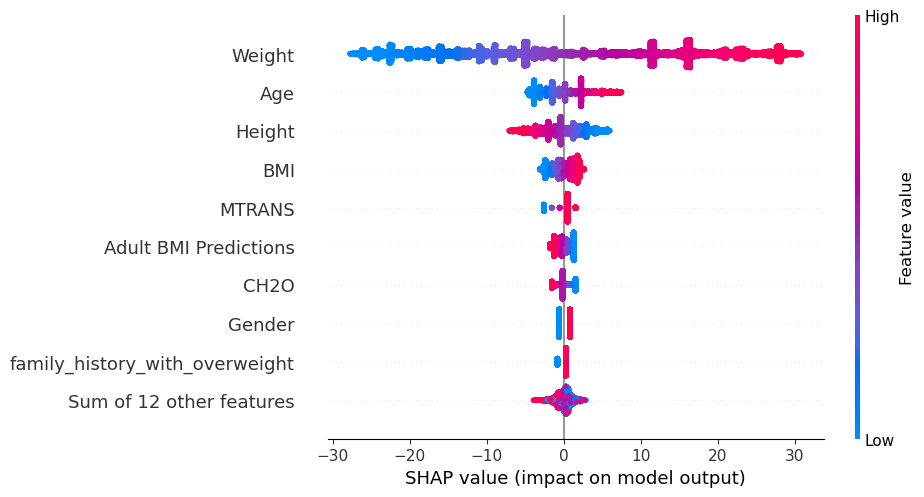

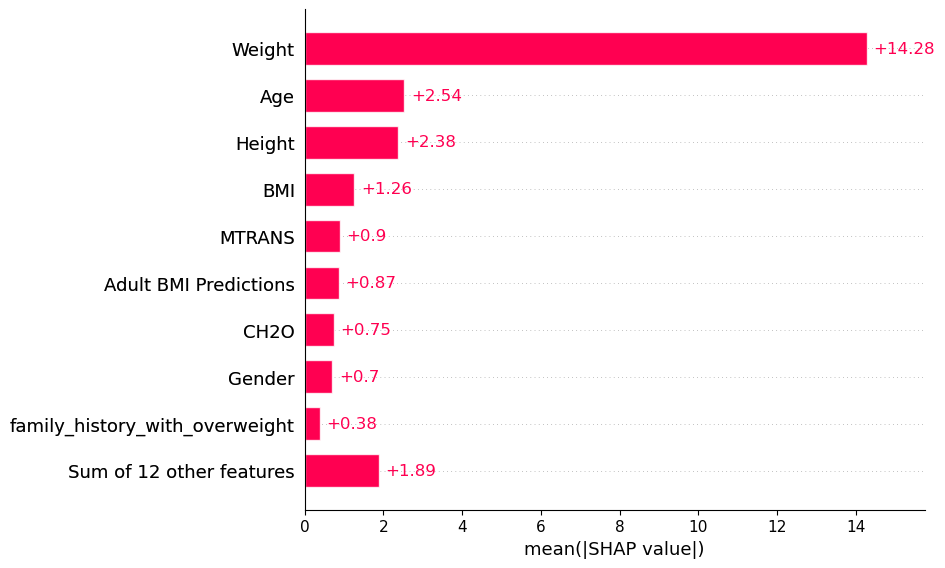

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


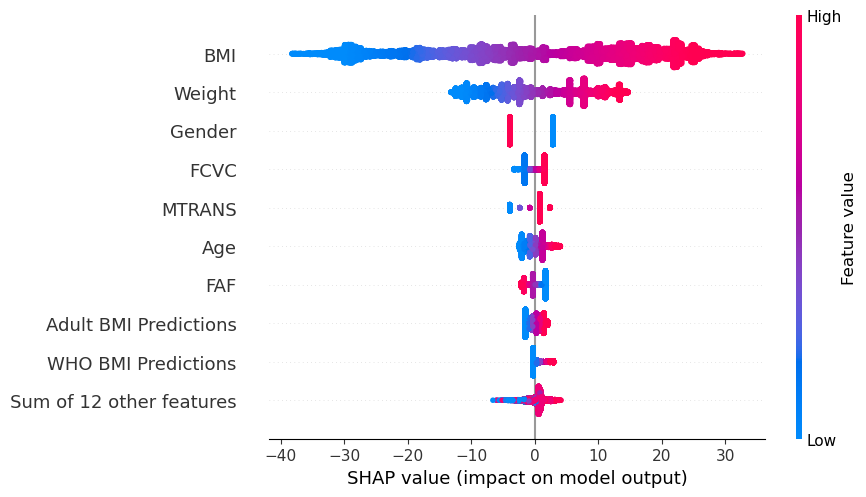

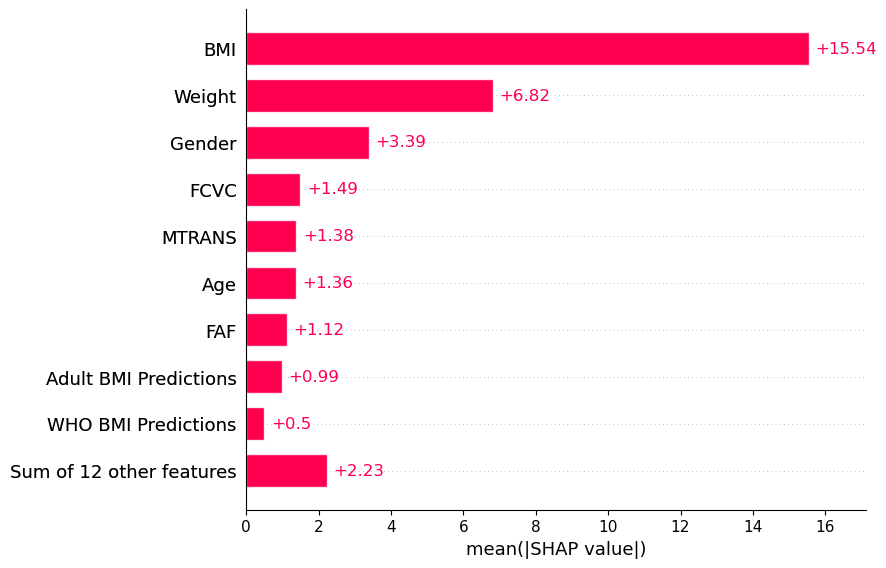

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


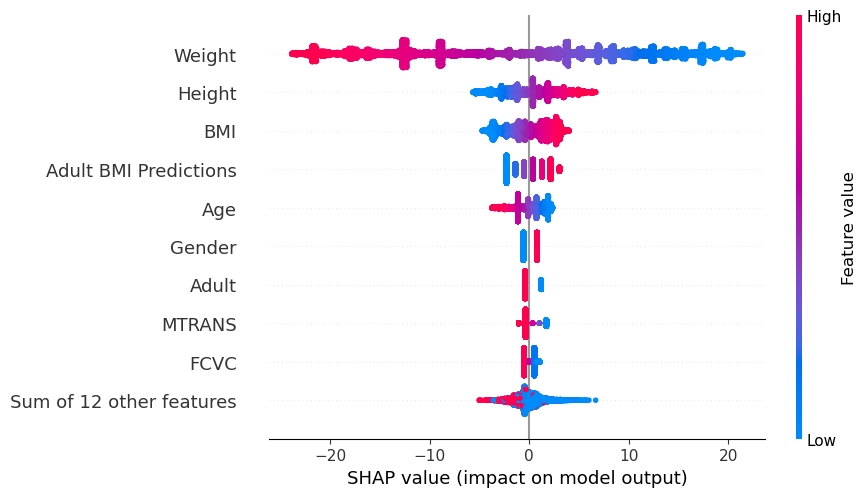

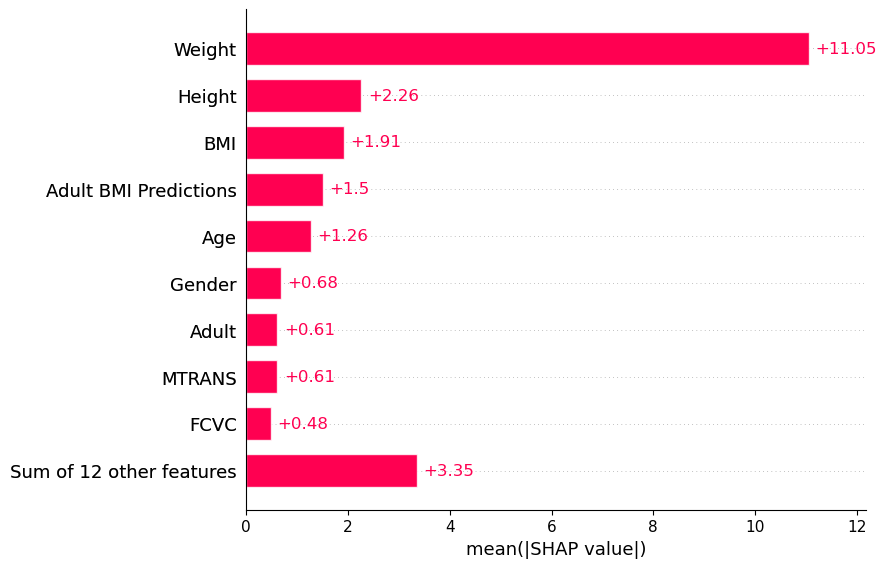

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


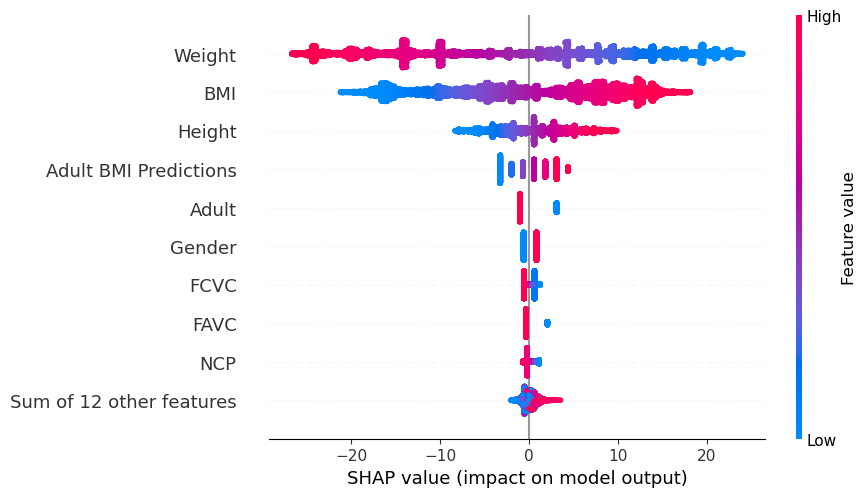

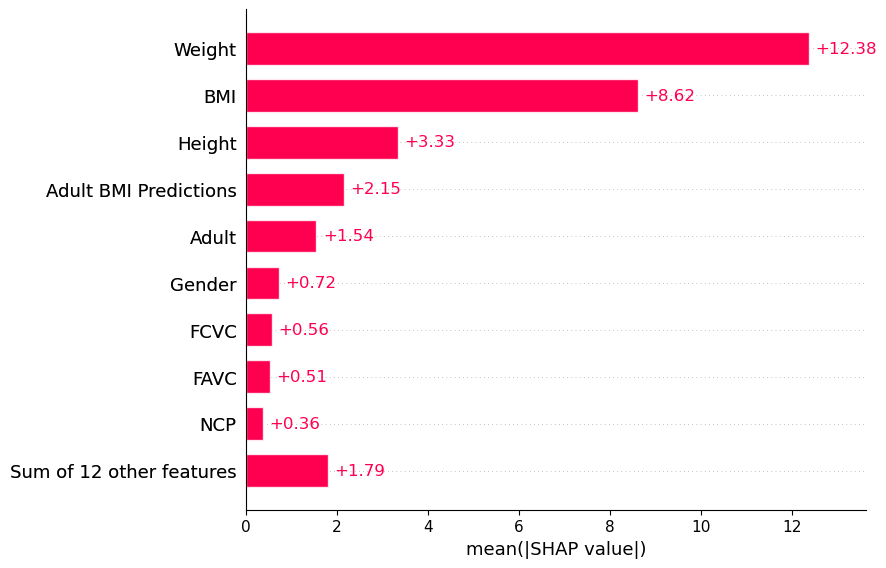

In [47]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.LinearExplainer(best_model, dataset)
shap_values = explainer(dataset)
print(shap_values.shape)

for i in range(shap_values.shape[2]):
    # summarize the effects of all the features
    shap.plots.beeswarm(shap_values[:, :, i])
    
    shap.plots.bar(shap_values[:, :, i])

QDA (Ordinal)


Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear


CV time 1.065 s


mean       std
fit_time                    0.018647  0.000494
score_time                  0.049388  0.001047
test_accuracy               0.858434  0.006097
train_accuracy              0.861830  0.000764
test_roc_auc_ovo_weighted   0.977304  0.001573
train_roc_auc_ovo_weighted  0.978502  0.000314
test_roc_auc_ovr_weighted   0.979591  0.001437
train_roc_auc_ovr_weighted  0.980663  0.000279

predict time 0.026 s
Confusion matrix: 


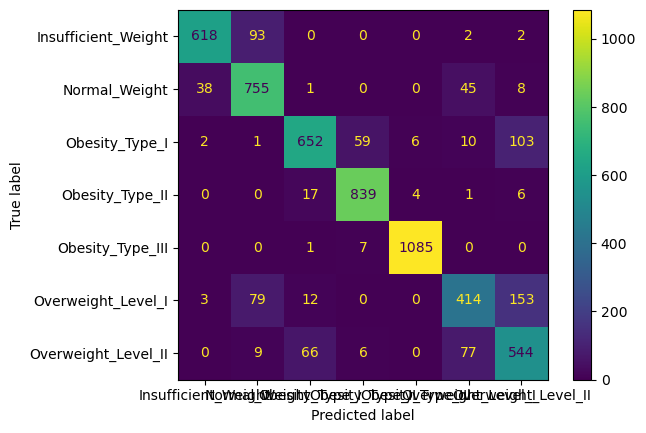

TRAIN - Accuracy: 0.861174275552446, AUC_ROC_OVO: 0.9762251035780177, AUC_ROC_OVR: 0.9786581038978676
TEST - Accuracy: 0.8581671913256383, AUC_ROC_OVO: 0.9750443288305894, AUC_ROC_OVR: 0.977663933469116

QDA (Ordinal Categorical Only - No Scaling)


Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear


CV time 1.064 s


mean       std
fit_time                    0.022384  0.003595
score_time                  0.049533  0.000731
test_accuracy               0.849338  0.005942
train_accuracy              0.852254  0.001657
test_roc_auc_ovo_weighted   0.975997  0.001776
train_roc_auc_ovo_weighted  0.977210  0.000437
test_roc_auc_ovr_weighted   0.978253  0.001671
train_roc_auc_ovr_weighted  0.979347  0.000400

predict time 0.025 s
Confusion matrix: 


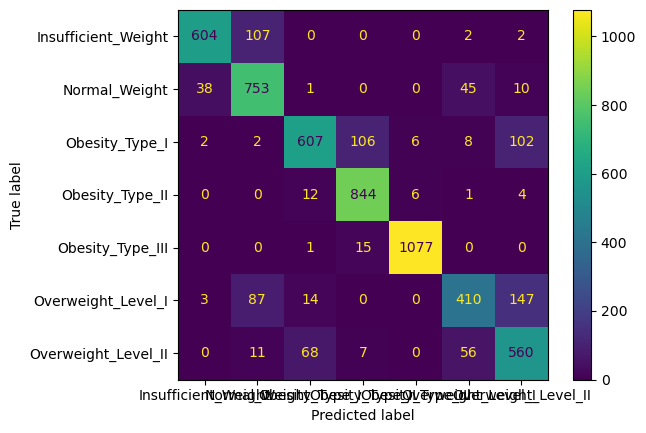

TRAIN - Accuracy: 0.8516121508949915, AUC_ROC_OVO: 0.9749700851442268, AUC_ROC_OVR: 0.9774335102961687
TEST - Accuracy: 0.8490731024833857, AUC_ROC_OVO: 0.9744131544433783, AUC_ROC_OVR: 0.9770443374185283

QDA (Ordinal Categorical Only - Standard Scaler)


Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear


CV time 1.106 s


mean       std
fit_time                    0.021159  0.002810
score_time                  0.049487  0.000933
test_accuracy               0.823450  0.005991
train_accuracy              0.826570  0.001243
test_roc_auc_ovo_weighted   0.972133  0.001822
train_roc_auc_ovo_weighted  0.973663  0.000320
test_roc_auc_ovr_weighted   0.974830  0.001718
train_roc_auc_ovr_weighted  0.976207  0.000297

predict time 0.025 s
Confusion matrix: 


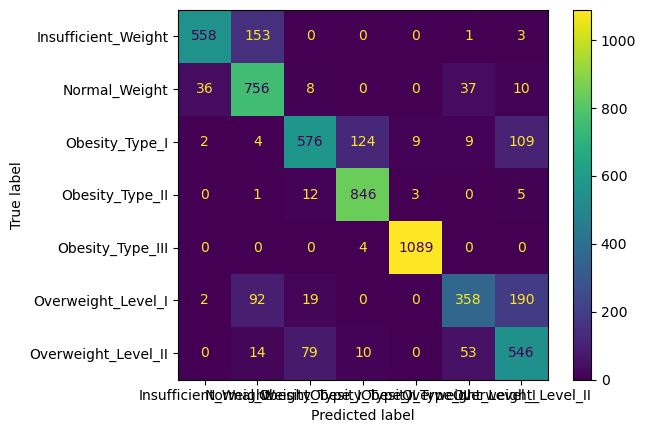

TRAIN - Accuracy: 0.8259576701066993, AUC_ROC_OVO: 0.970998170990572, AUC_ROC_OVR: 0.9739733663594375
TEST - Accuracy: 0.8270374256733124, AUC_ROC_OVO: 0.970264621912641, AUC_ROC_OVR: 0.9733801707373305

QDA (Ordinal Categorical Only - Robust Scaler)


Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear


CV time 1.153 s


mean       std
fit_time                    0.027497  0.009092
score_time                  0.048829  0.000729
test_accuracy               0.800886  0.005964
train_accuracy              0.803583  0.001155
test_roc_auc_ovo_weighted   0.965361  0.002154
train_roc_auc_ovo_weighted  0.967066  0.000258
test_roc_auc_ovr_weighted   0.968592  0.002053
train_roc_auc_ovr_weighted  0.970144  0.000236

predict time 0.025 s
Confusion matrix: 


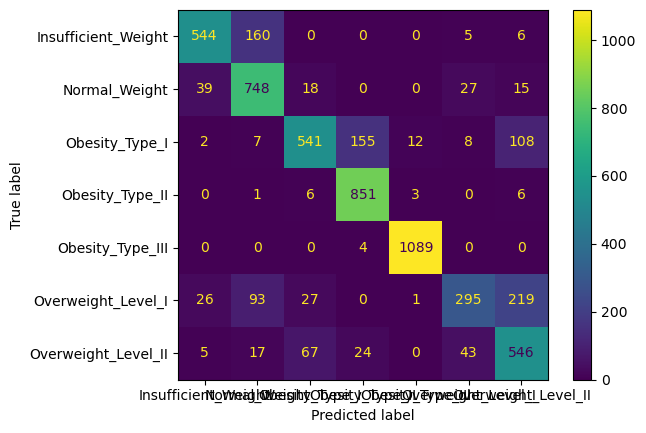

TRAIN - Accuracy: 0.8028686373972364, AUC_ROC_OVO: 0.9638142469875399, AUC_ROC_OVR: 0.9674071551185099
TEST - Accuracy: 0.8069254984260231, AUC_ROC_OVO: 0.9627406442466857, AUC_ROC_OVR: 0.966500617310424

QDA (One Hot Categorical Only - No Scaling)


Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear


CV time 1.421 s


mean       std
fit_time                    0.034581  0.001731
score_time                  0.065307  0.000263
test_accuracy               0.864614  0.003741
train_accuracy              0.868973  0.002175
test_roc_auc_ovo_weighted   0.979615  0.001018
train_roc_auc_ovo_weighted  0.980692  0.000376
test_roc_auc_ovr_weighted   0.981622  0.000944
train_roc_auc_ovr_weighted  0.982587  0.000343

predict time 0.07 s
Confusion matrix: 


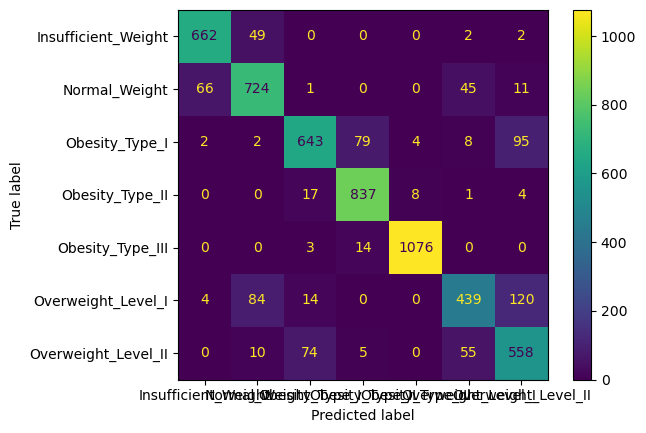

TRAIN - Accuracy: 0.8681126464929159, AUC_ROC_OVO: 0.9786867083670122, AUC_ROC_OVR: 0.9808369339352477
TEST - Accuracy: 0.8637635536901014, AUC_ROC_OVO: 0.977700111411337, AUC_ROC_OVR: 0.9799877953081646

QDA (One Hot Categorical Only - Standard Scaler)


Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear


CV time 1.469 s


mean       std
fit_time                    0.034643  0.000823
score_time                  0.064812  0.000894
test_accuracy               0.848055  0.005160
train_accuracy              0.852064  0.001143
test_roc_auc_ovo_weighted   0.977493  0.000853
train_roc_auc_ovo_weighted  0.978800  0.000269
test_roc_auc_ovr_weighted   0.979834  0.000772
train_roc_auc_ovr_weighted  0.980998  0.000248

predict time 0.065 s
Confusion matrix: 


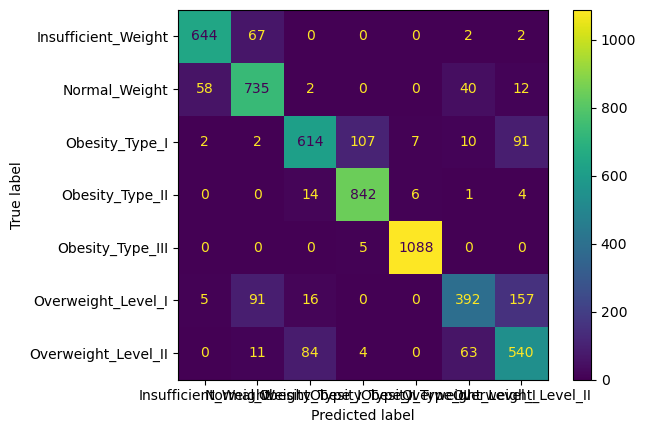

TRAIN - Accuracy: 0.8510290945134394, AUC_ROC_OVO: 0.9764678293555394, AUC_ROC_OVR: 0.9789768383601631
TEST - Accuracy: 0.8490731024833857, AUC_ROC_OVO: 0.975347595161459, AUC_ROC_OVR: 0.9780364867302582

QDA (One Hot Categorical Only - Robust Scaler)


Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear


CV time 1.427 s


mean       std
fit_time                    0.035673  0.002421
score_time                  0.064580  0.001293
test_accuracy               0.837444  0.004934
train_accuracy              0.841890  0.001312
test_roc_auc_ovo_weighted   0.975085  0.000813
train_roc_auc_ovo_weighted  0.976374  0.000256
test_roc_auc_ovr_weighted   0.977653  0.000731
train_roc_auc_ovr_weighted  0.978800  0.000234

predict time 0.064 s
Confusion matrix: 


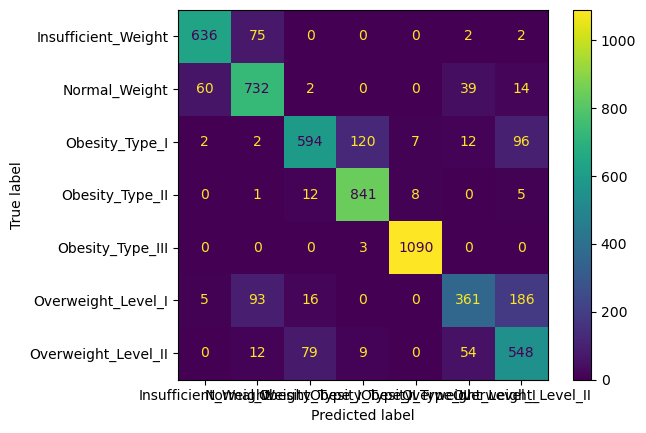

TRAIN - Accuracy: 0.8408256078362778, AUC_ROC_OVO: 0.9738263908202898, AUC_ROC_OVR: 0.9766091947967561
TEST - Accuracy: 0.8398041273172437, AUC_ROC_OVO: 0.9729194480011837, AUC_ROC_OVR: 0.975867287309721

QDA Manual Encoding 1


Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear


CV time 1.674 s


mean       std
fit_time                    0.095034  0.068321
score_time                  0.051473  0.000711
test_accuracy               0.867705  0.004484
train_accuracy              0.870503  0.001816
test_roc_auc_ovo_weighted   0.980008  0.001307
train_roc_auc_ovo_weighted  0.981073  0.000364
test_roc_auc_ovr_weighted   0.981941  0.001210
train_roc_auc_ovr_weighted  0.982895  0.000332

predict time 0.051 s
Confusion matrix: 


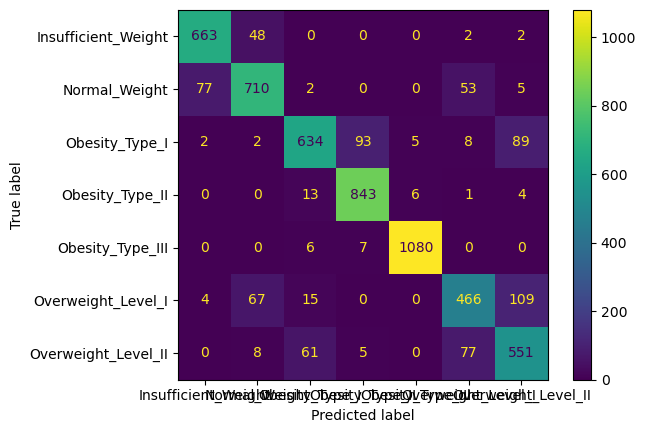

TRAIN - Accuracy: 0.8702116494665034, AUC_ROC_OVO: 0.9791563364171948, AUC_ROC_OVR: 0.9812367628290072
TEST - Accuracy: 0.8651626442812173, AUC_ROC_OVO: 0.9789249533658377, AUC_ROC_OVR: 0.9810786439928061

QDA Manual Encoding 2


Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear
Variables are collinear


CV time 3.743 s


mean       std
fit_time                    0.139399  0.021193
score_time                  0.136250  0.001913
test_accuracy               0.766019  0.003000
train_accuracy              0.774415  0.002903
test_roc_auc_ovo_weighted   0.965022  0.001033
train_roc_auc_ovo_weighted  0.967889  0.000319
test_roc_auc_ovr_weighted   0.968632  0.000942
train_roc_auc_ovr_weighted  0.971216  0.000297

predict time 0.294 s
Confusion matrix: 


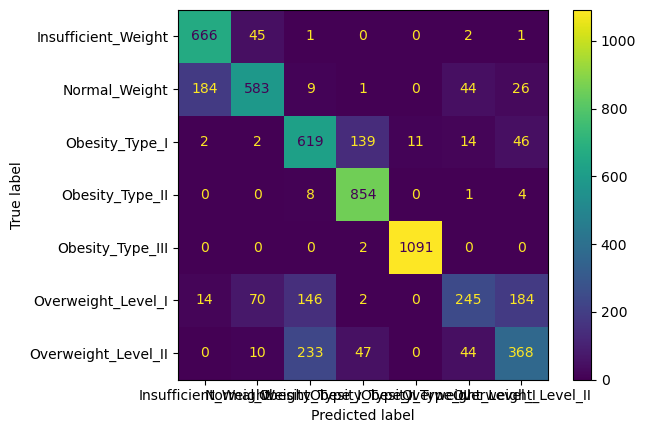

TRAIN - Accuracy: 0.7717917322605096, AUC_ROC_OVO: 0.964196417515462, AUC_ROC_OVR: 0.9680867589393213
TEST - Accuracy: 0.7740468695348024, AUC_ROC_OVO: 0.964303976110728, AUC_ROC_OVR: 0.9682911935670723



cv_test_mean  cv_test_std
(Ordinal)                                         0.858434     0.006097
(Ordinal Categorical Only - No Scaling)           0.849338     0.005942
(Ordinal Categorical Only - Standard Scaler)      0.823450     0.005991
(Ordinal Categorical Only - Robust Scaler)        0.800886     0.005964
(One Hot Categorical Only - No Scaling)           0.864614     0.003741
(One Hot Categorical Only - Standard Scaler)      0.848055     0.005160
(One Hot Categorical Only - Robust Scaler)        0.837444     0.004934
Manual Encoding 1                                 0.867705     0.004484
Manual Encoding 2                                 0.766019     0.003000

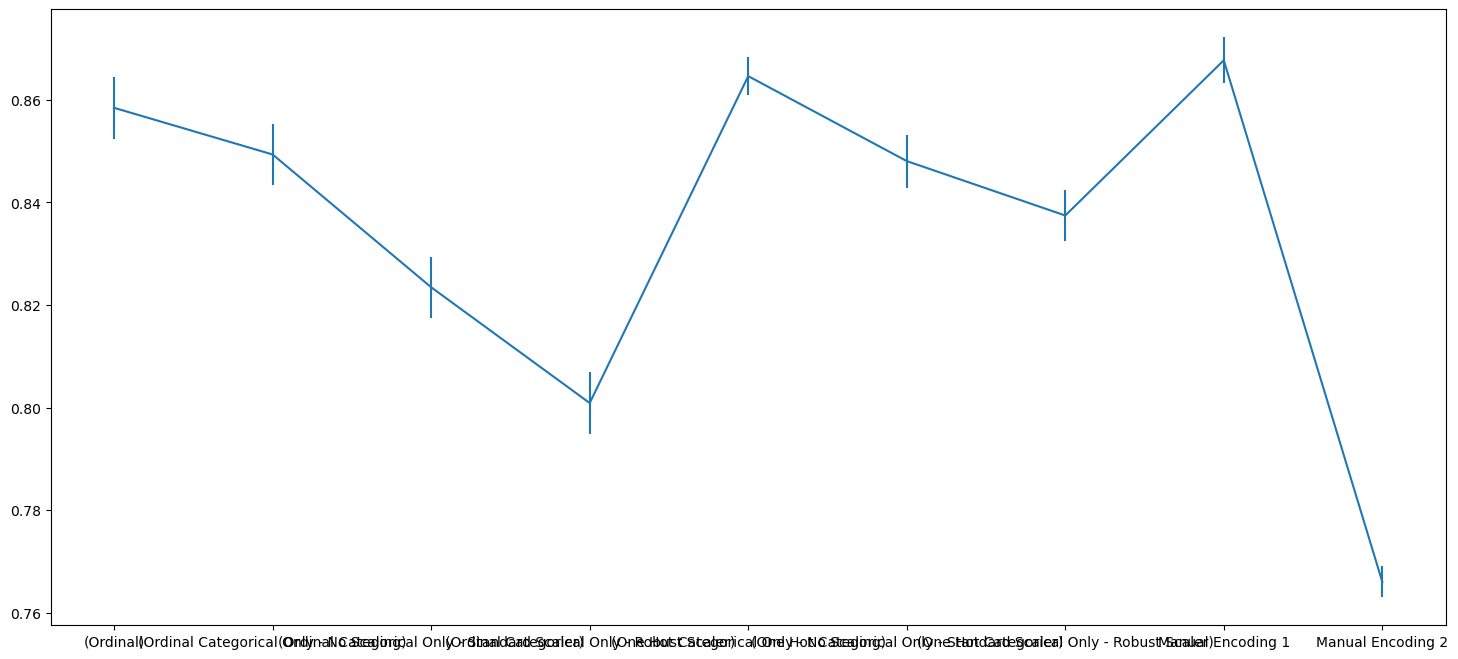

Best Preprocessing: Manual Encoding 1 - Test Accuracy: 0.8651626442812173


In [48]:
# Model 6b - QDA
test = []
models = []
summaries = []
for i, name in enumerate(preprocessed):
    model = QuadraticDiscriminantAnalysis(reg_param=0.125)
    if sci.sparse.issparse(X_train[i]) or sci.sparse.issparse(X_test[i]) == True:
        train_results, test_results, summary = train_and_evaluate_classifierCV(f"QDA {name}", 
                                                                                model, 
                                                                                X_train[i].values, 
                                                                                y_train[i], 
                                                                                X_test[i].values, 
                                                                                y_test[i], 
                                                                                confusion=True, 
                                                                                supress_outputs=False)
    else:
        train_results, test_results, summary = train_and_evaluate_classifierCV(f"QDA {name}", 
                                                                                model, 
                                                                                X_train[i], 
                                                                                y_train[i], 
                                                                                X_test[i], 
                                                                                y_test[i], 
                                                                                confusion=True, 
                                                                                supress_outputs=False)
    test.append(test_results[0])
    models.append(model)
    summaries.append(summary)
    print()

cv_test_mean = [summary['mean']['test_accuracy'] for summary in summaries]
cv_test_std =  [summary['std']['test_accuracy'] for summary in summaries]
cv_results = pd.DataFrame({'cv_test_mean':cv_test_mean, 'cv_test_std':cv_test_std})
cv_results.index = preprocessed
display(cv_results)
plt.figure(figsize=(18, 8))
plt.errorbar(cv_results.index, cv_results['cv_test_mean'], yerr=cv_results['cv_test_std'])
plt.show()

test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

In [49]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# explainer = shap.KernelExplainer(best_model.predict, dataset)
# shap_values = explainer(dataset.values)
# print(shap_values.shape)

# for i in range(shap_values.shape[2]):
#     # summarize the effects of all the features
#     shap.plots.beeswarm(shap_values[:, :, i])
    
#     shap.plots.bar(shap_values[:, :, i])

Gaussian Naive Bayes (Ordinal)
CV time 1.053 s


mean       std
fit_time                    0.019206  0.001635
score_time                  0.047978  0.001697
test_accuracy               0.802460  0.010733
train_accuracy              0.804180  0.002826
test_roc_auc_ovo_weighted   0.963537  0.001447
train_roc_auc_ovo_weighted  0.964470  0.000564
test_roc_auc_ovr_weighted   0.966743  0.001271
train_roc_auc_ovr_weighted  0.967630  0.000527

predict time 0.029 s
Confusion matrix: 


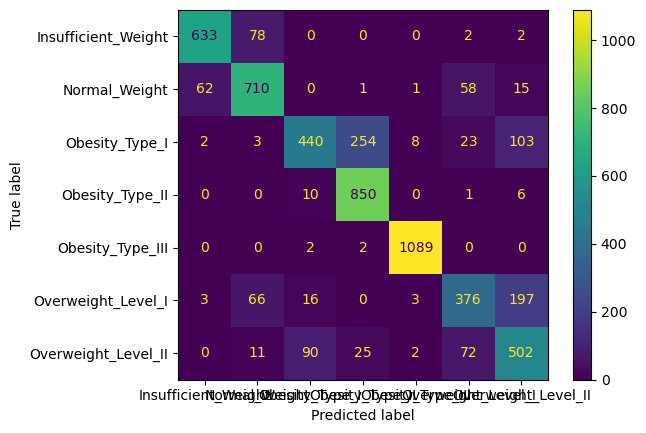

TRAIN - Accuracy: 0.8039764445221853, AUC_ROC_OVO: 0.9615110448455729, AUC_ROC_OVR: 0.9652674946510889
TEST - Accuracy: 0.8044770898915705, AUC_ROC_OVO: 0.9614558054900215, AUC_ROC_OVR: 0.965198079583934

Gaussian Naive Bayes (Ordinal Categorical Only - No Scaling)
CV time 1.035 s


mean       std
fit_time                    0.018775  0.000514
score_time                  0.048193  0.000813
test_accuracy               0.799545  0.009454
train_accuracy              0.801528  0.002924
test_roc_auc_ovo_weighted   0.961572  0.001551
train_roc_auc_ovo_weighted  0.962468  0.000629
test_roc_auc_ovr_weighted   0.964922  0.001369
train_roc_auc_ovr_weighted  0.965777  0.000590

predict time 0.024 s
Confusion matrix: 


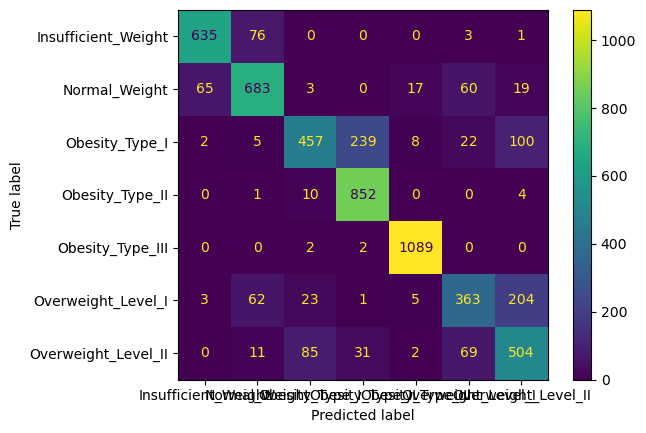

TRAIN - Accuracy: 0.8013526908052009, AUC_ROC_OVO: 0.9594168288209909, AUC_ROC_OVR: 0.9633690209402049
TEST - Accuracy: 0.8015040223854495, AUC_ROC_OVO: 0.9596137156129521, AUC_ROC_OVR: 0.9635433928380165

Gaussian Naive Bayes (Ordinal Categorical Only - Standard Scaler)
CV time 1.039 s


mean       std
fit_time                    0.019278  0.001202
score_time                  0.047462  0.000707
test_accuracy               0.798146  0.009444
train_accuracy              0.800303  0.003079
test_roc_auc_ovo_weighted   0.960842  0.001726
train_roc_auc_ovo_weighted  0.961738  0.000645
test_roc_auc_ovr_weighted   0.964237  0.001533
train_roc_auc_ovr_weighted  0.965091  0.000615

predict time 0.025 s
Confusion matrix: 


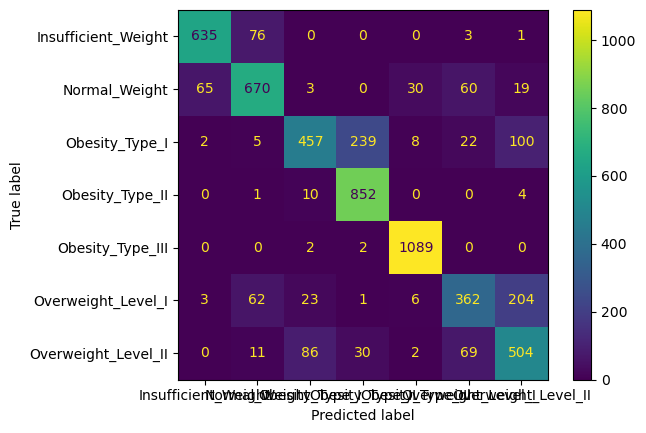

TRAIN - Accuracy: 0.8001865780420967, AUC_ROC_OVO: 0.9588285286996057, AUC_ROC_OVR: 0.9628630831529071
TEST - Accuracy: 0.7990556138509969, AUC_ROC_OVO: 0.9585909005662511, AUC_ROC_OVR: 0.9626435078003112

Gaussian Naive Bayes (Ordinal Categorical Only - Robust Scaler)
CV time 1.052 s


mean       std
fit_time                    0.019561  0.001105
score_time                  0.048328  0.001447
test_accuracy               0.798321  0.009384
train_accuracy              0.800420  0.003064
test_roc_auc_ovo_weighted   0.960912  0.001712
train_roc_auc_ovo_weighted  0.961806  0.000644
test_roc_auc_ovr_weighted   0.964303  0.001518
train_roc_auc_ovr_weighted  0.965155  0.000613

predict time 0.025 s
Confusion matrix: 


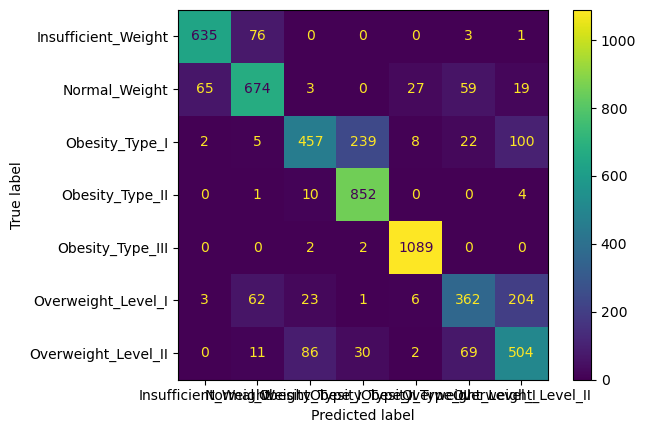

TRAIN - Accuracy: 0.8004198005947175, AUC_ROC_OVO: 0.958894900195545, AUC_ROC_OVR: 0.9629198558358035
TEST - Accuracy: 0.7997551591465547, AUC_ROC_OVO: 0.9587088290903084, AUC_ROC_OVR: 0.96274546584782

Gaussian Naive Bayes (One Hot Categorical Only - No Scaling)
CV time 1.354 s


mean       std
fit_time                    0.025875  0.000527
score_time                  0.063465  0.000963
test_accuracy               0.698793  0.012348
train_accuracy              0.699362  0.009571
test_roc_auc_ovo_weighted   0.952345  0.001814
train_roc_auc_ovo_weighted  0.954182  0.000943
test_roc_auc_ovr_weighted   0.955896  0.001675
train_roc_auc_ovr_weighted  0.957661  0.000866

predict time 0.066 s
Confusion matrix: 


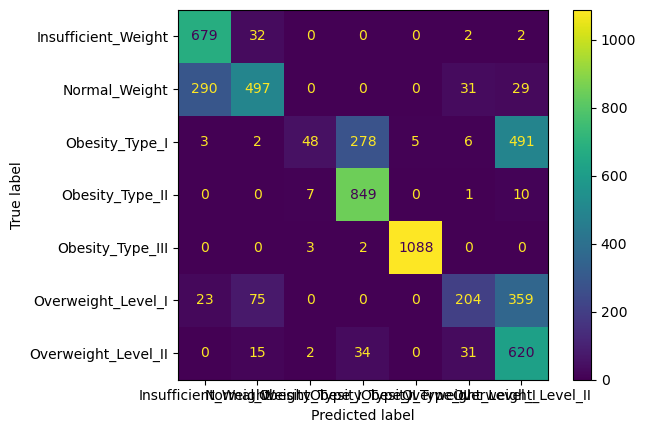

TRAIN - Accuracy: 0.6960527082968924, AUC_ROC_OVO: 0.9507638939573697, AUC_ROC_OVR: 0.9549352001805674
TEST - Accuracy: 0.6969220006995452, AUC_ROC_OVO: 0.951938225368646, AUC_ROC_OVR: 0.9560317034946244

Gaussian Naive Bayes (One Hot Categorical Only - Standard Scaler)
CV time 1.352 s


mean       std
fit_time                    0.026517  0.000546
score_time                  0.064625  0.001415
test_accuracy               0.662525  0.018544
train_accuracy              0.663927  0.017921
test_roc_auc_ovo_weighted   0.943796  0.002814
train_roc_auc_ovo_weighted  0.945601  0.002242
test_roc_auc_ovr_weighted   0.948138  0.002606
train_roc_auc_ovr_weighted  0.949880  0.002004

predict time 0.067 s
Confusion matrix: 


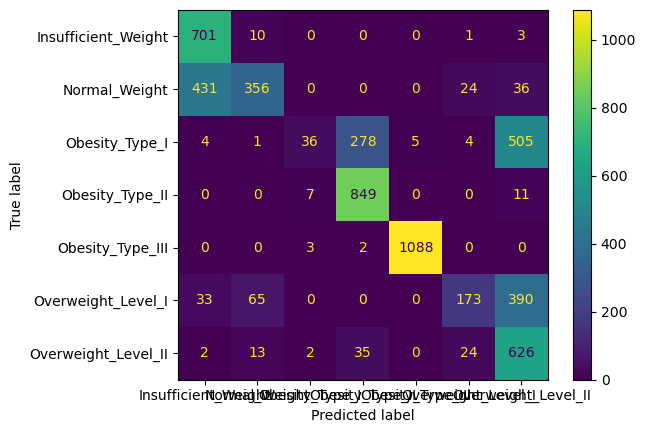

TRAIN - Accuracy: 0.6659669990088042, AUC_ROC_OVO: 0.9406167327820916, AUC_ROC_OVR: 0.9453822750918659
TEST - Accuracy: 0.6696397341727877, AUC_ROC_OVO: 0.9410549822557295, AUC_ROC_OVR: 0.9456541492142447

Gaussian Naive Bayes (One Hot Categorical Only - Robust Scaler)
CV time 1.353 s


mean       std
fit_time                    0.025927  0.001192
score_time                  0.064530  0.001154
test_accuracy               0.662408  0.018425
train_accuracy              0.663416  0.017987
test_roc_auc_ovo_weighted   0.943697  0.002845
train_roc_auc_ovo_weighted  0.945475  0.002268
test_roc_auc_ovr_weighted   0.948049  0.002633
train_roc_auc_ovr_weighted  0.949767  0.002028

predict time 0.064 s
Confusion matrix: 


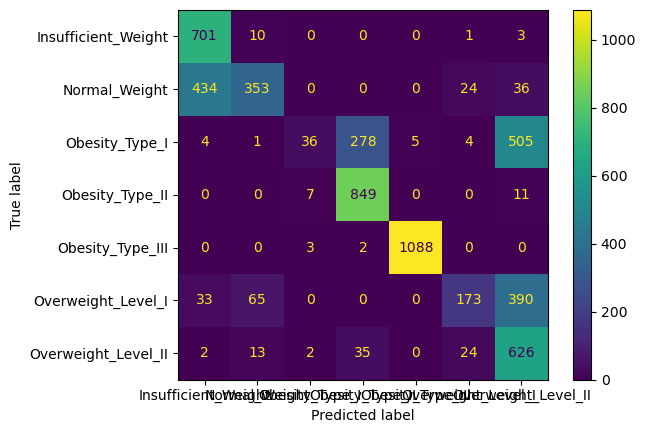

TRAIN - Accuracy: 0.6654422482654072, AUC_ROC_OVO: 0.9404807928386253, AUC_ROC_OVR: 0.9452558734818003
TEST - Accuracy: 0.6691150752011192, AUC_ROC_OVO: 0.9409368386342754, AUC_ROC_OVR: 0.9455458792370413

Gaussian Naive Bayes Manual Encoding 1
CV time 1.162 s


mean       std
fit_time                    0.022207  0.000624
score_time                  0.049574  0.000849
test_accuracy               0.767127  0.016214
train_accuracy              0.767463  0.005792
test_roc_auc_ovo_weighted   0.958727  0.001326
train_roc_auc_ovo_weighted  0.960363  0.001005
test_roc_auc_ovr_weighted   0.962329  0.001216
train_roc_auc_ovr_weighted  0.963885  0.000891

predict time 0.05 s
Confusion matrix: 


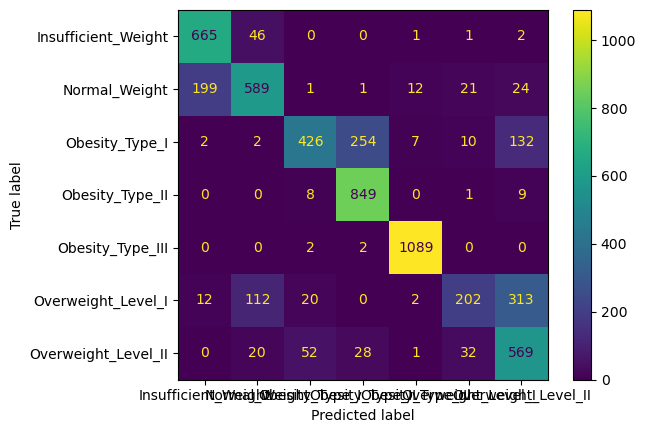

TRAIN - Accuracy: 0.7633957203661594, AUC_ROC_OVO: 0.9576384169341, AUC_ROC_OVR: 0.961868222111045
TEST - Accuracy: 0.7675760755508919, AUC_ROC_OVO: 0.958502919427122, AUC_ROC_OVR: 0.9626562413849543

Gaussian Naive Bayes Manual Encoding 2
CV time 3.06 s


mean       std
fit_time                    0.075205  0.003769
score_time                  0.118519  0.002820
test_accuracy               0.605795  0.019111
train_accuracy              0.606670  0.023462
test_roc_auc_ovo_weighted   0.868134  0.002384
train_roc_auc_ovo_weighted  0.870506  0.003720
test_roc_auc_ovr_weighted   0.880077  0.001992
train_roc_auc_ovr_weighted  0.882265  0.003287

predict time 0.328 s
Confusion matrix: 


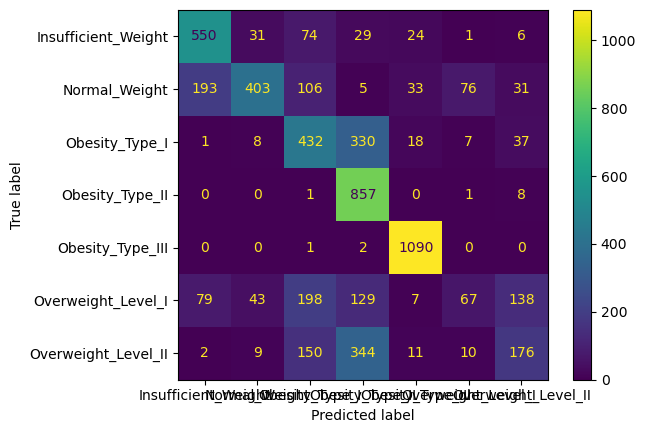

TRAIN - Accuracy: 0.6224126873068626, AUC_ROC_OVO: 0.8619734616191648, AUC_ROC_OVR: 0.8748247249474342
TEST - Accuracy: 0.6252186079048618, AUC_ROC_OVO: 0.8599677296784782, AUC_ROC_OVR: 0.8724429636813171



cv_test_mean  cv_test_std
(Ordinal)                                         0.802460     0.010733
(Ordinal Categorical Only - No Scaling)           0.799545     0.009454
(Ordinal Categorical Only - Standard Scaler)      0.798146     0.009444
(Ordinal Categorical Only - Robust Scaler)        0.798321     0.009384
(One Hot Categorical Only - No Scaling)           0.698793     0.012348
(One Hot Categorical Only - Standard Scaler)      0.662525     0.018544
(One Hot Categorical Only - Robust Scaler)        0.662408     0.018425
Manual Encoding 1                                 0.767127     0.016214
Manual Encoding 2                                 0.605795     0.019111

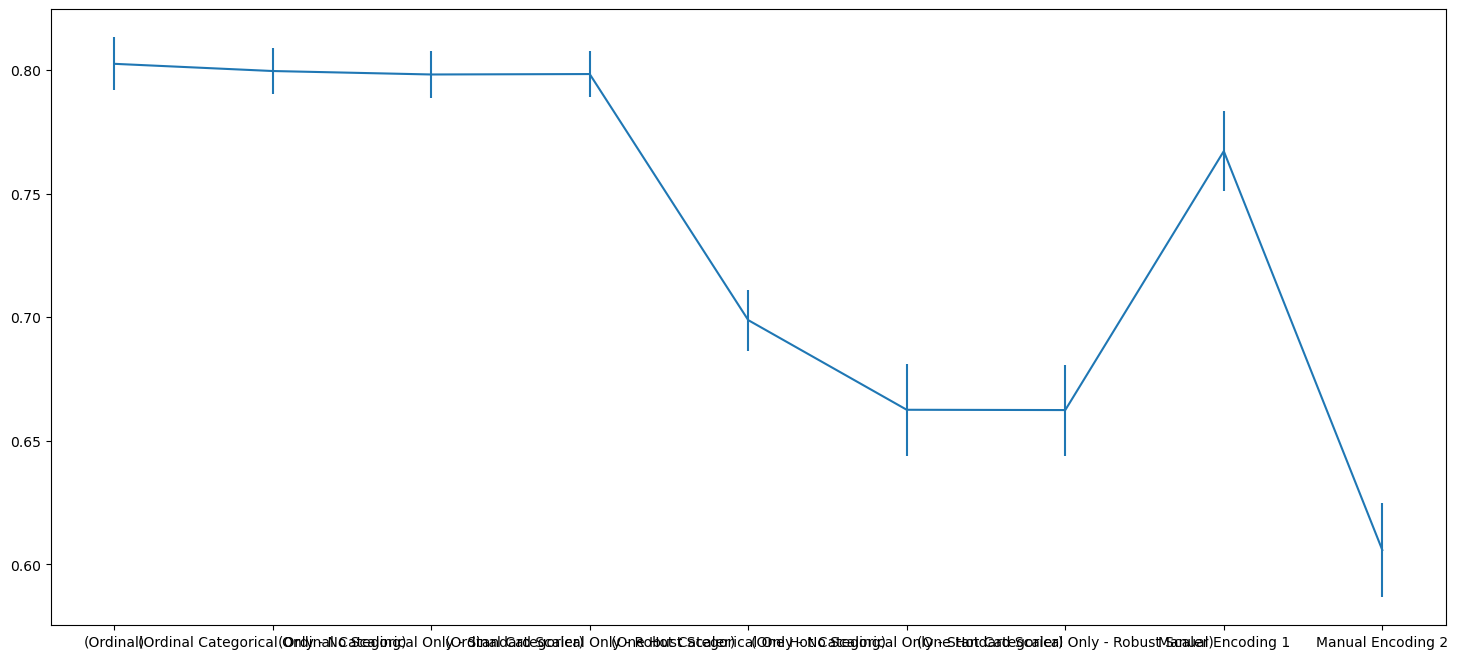

Best Preprocessing: (Ordinal) - Test Accuracy: 0.8044770898915705


In [51]:
# Model 7a - Gaussian Naive Bayes
test = []
models = []
summaries = []
indexes = [0, 1, 2, 3, 4, 5, 6, 7, 8]
for i in indexes:
    name = preprocessed[i]
    model = GaussianNB()
    if sci.sparse.issparse(X_train[i]) or sci.sparse.issparse(X_test[i]) == True:
        train_results, test_results, summary = train_and_evaluate_classifierCV(f"Gaussian Naive Bayes {name}", 
                                                                                model, 
                                                                                X_train[i].toarray(), 
                                                                                y_train[i], 
                                                                                X_test[i].toarray(), 
                                                                                y_test[i], 
                                                                                confusion=True, 
                                                                                supress_outputs=False)
    else:
        train_results, test_results, summary = train_and_evaluate_classifierCV(f"Gaussian Naive Bayes {name}", 
                                                                                model, 
                                                                                X_train[i], 
                                                                                y_train[i],
                                                                                X_test[i], 
                                                                                y_test[i], 
                                                                                confusion=True, 
                                                                                supress_outputs=False)
    test.append(test_results[0])
    models.append(model)
    summaries.append(summary)
    print()

cv_test_mean = [summary['mean']['test_accuracy'] for summary in summaries]
cv_test_std =  [summary['std']['test_accuracy'] for summary in summaries]
cv_results = pd.DataFrame({'cv_test_mean':cv_test_mean, 'cv_test_std':cv_test_std})
cv_results.index = preprocessed
display(cv_results)
plt.figure(figsize=(18, 8))
plt.errorbar(cv_results.index, cv_results['cv_test_mean'], yerr=cv_results['cv_test_std'])
plt.show()

test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

In [52]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# explainer = shap.KernelExplainer(best_model.predict, dataset)
# shap_values = explainer(dataset.values)
# print(shap_values.shape)

# for i in range(shap_values.shape[2]):
#     # summarize the effects of all the features
#     shap.plots.beeswarm(shap_values[:, :, i])
    
#     shap.plots.bar(shap_values[:, :, i])

In [53]:
# Model 7e - Categorical Naive Bayes
test = []
models = []
summaries = []
indexes = [0, 1, 4]
for i in indexes:
    name = preprocessed[i]
    model = CategoricalNB()
    if sci.sparse.issparse(X_train[i]) or sci.sparse.issparse(X_test[i]) == True:
        train_results, test_results, summary = train_and_evaluate_classifierCV(f"Categorical Naive Bayes {name}", 
                                                                                model, 
                                                                                X_train[i].toarray(), 
                                                                                y_train[i], 
                                                                                X_test[i].toarray(),
                                                                                y_test[i], 
                                                                                confusion=True, 
                                                                                supress_outputs=False)
    else:
        train_results, test_results, summary = train_and_evaluate_classifierCV(f"Categorical Naive Bayes {name}", 
                                                                                model, 
                                                                                X_train[i], 
                                                                                y_train[i], 
                                                                                X_test[i], 
                                                                                y_test[i], 
                                                                                confusion=True, 
                                                                                supress_outputs=False)
    test.append(test_results[0])
    models.append(model)
    summaries.append(summary)
    print()

cv_test_mean = [summary['mean']['test_accuracy'] for summary in summaries]
cv_test_std =  [summary['std']['test_accuracy'] for summary in summaries]
cv_results = pd.DataFrame({'cv_test_mean':cv_test_mean, 'cv_test_std':cv_test_std})
cv_results.index = preprocessed
display(cv_results)
plt.figure(figsize=(18, 8))
plt.errorbar(cv_results.index, cv_results['cv_test_mean'], yerr=cv_results['cv_test_std'])
plt.show()

test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

Categorical Naive Bayes (Ordinal)


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "D:\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "D:\miniconda3\Lib\site-packages\sklearn\utils\_response.py", line 85, in _get_response_values
    y_pred = prediction_method(X)
             ^^^^^^^^^^^^^^^^^^^^
  File "D:\miniconda3\Lib\site-packages\sklearn\naive_bayes.py", line 102, in predict
    jll = self._joint_log_likelihood(X)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\mini

CV time 1.043 s


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "D:\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "D:\miniconda3\Lib\site-packages\sklearn\utils\_response.py", line 85, in _get_response_values
    y_pred = prediction_method(X)
             ^^^^^^^^^^^^^^^^^^^^
  File "D:\miniconda3\Lib\site-packages\sklearn\naive_bayes.py", line 102, in predict
    jll = self._joint_log_likelihood(X)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\mini

mean       std
fit_time                    0.051228  0.000591
score_time                  0.024800  0.020175
test_accuracy               0.882507  0.007289
train_accuracy              0.911361  0.001453
test_roc_auc_ovo_weighted   0.983514  0.001019
train_roc_auc_ovo_weighted  0.990536  0.000105
test_roc_auc_ovr_weighted   0.985277  0.000890
train_roc_auc_ovr_weighted  0.991479  0.000097

IndexError: index 841 is out of bounds for axis 1 with size 841

In [ ]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# explainer = shap.KernelExplainer(best_model.predict, dataset.values)
# shap_values = explainer(dataset.values)
# print(shap_values.shape)

# for i in range(shap_values.shape[2]):
#     # summarize the effects of all the features
#     shap.plots.beeswarm(shap_values[:, :, i])
    
#     shap.plots.bar(shap_values[:, :, i])